In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from comparers import ModelComparer
from util import RuleClassifier, get_complexity, evaluate_counterfactual_fidelity
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, plot_joint_feature_dependence, compare_indiv_dep_plots
from tasks.boston_housing import make_task3 as make_task
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from shap.plots import bar
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

# Setup Task

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [5]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='mclass_diff', space_type='log_odds')
with open('indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Using Exact algorithm
Using Exact algorithm
Using Exact algorithm


Exact explainer: 247it [01:55,  2.07it/s]                         
Exact explainer: 247it [01:47,  2.08it/s]                         
Exact explainer: 247it [07:35,  1.90s/it]                         

CPU times: user 12min 31s, sys: 2min 17s, total: 14min 49s
Wall time: 11min 18s


# Traditional SHAP Explanations

In [3]:
with open('indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

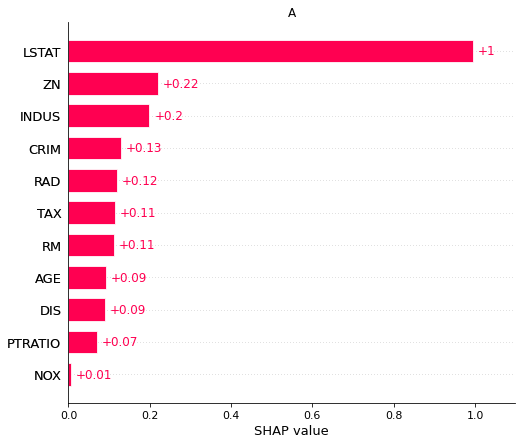

In [4]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['A.0', 'A.1', 'A.2']])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

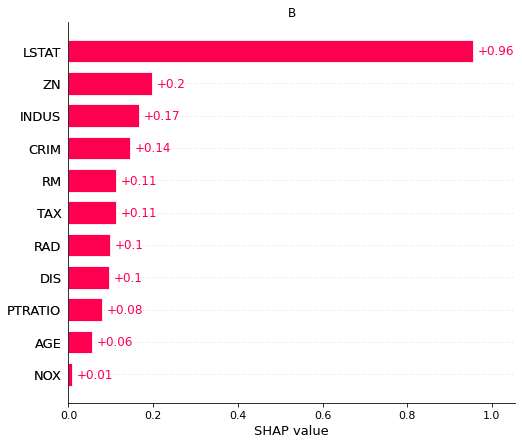

In [5]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['B.0', 'B.1', 'B.2']])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [6]:
feature_order, _ = calc_feature_order(indiv_shap_values)

In [7]:
feature_order = feature_order[:-1]

In [8]:
node = make_clustering(comparer, indiv_shap_values, categorical_features=categorical_features)

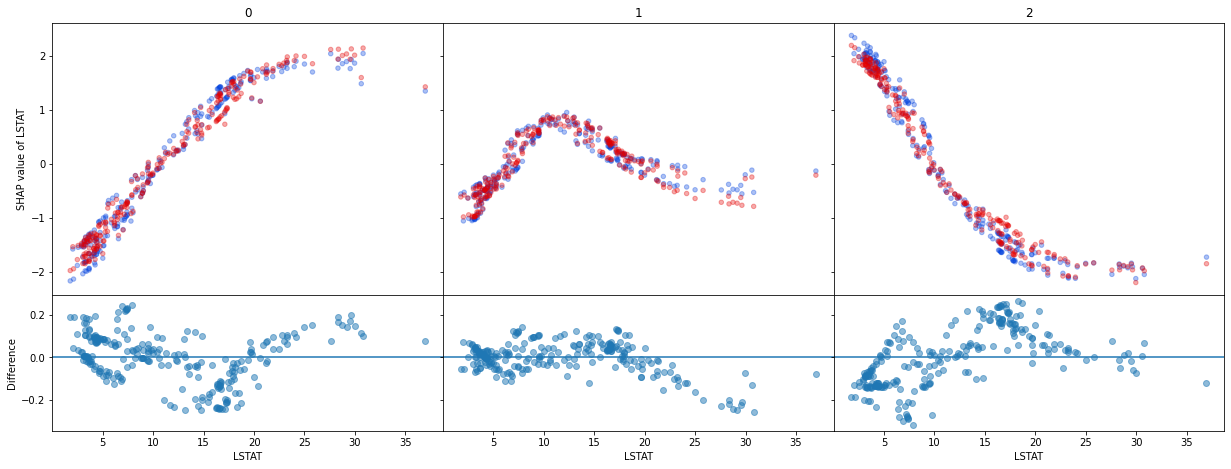

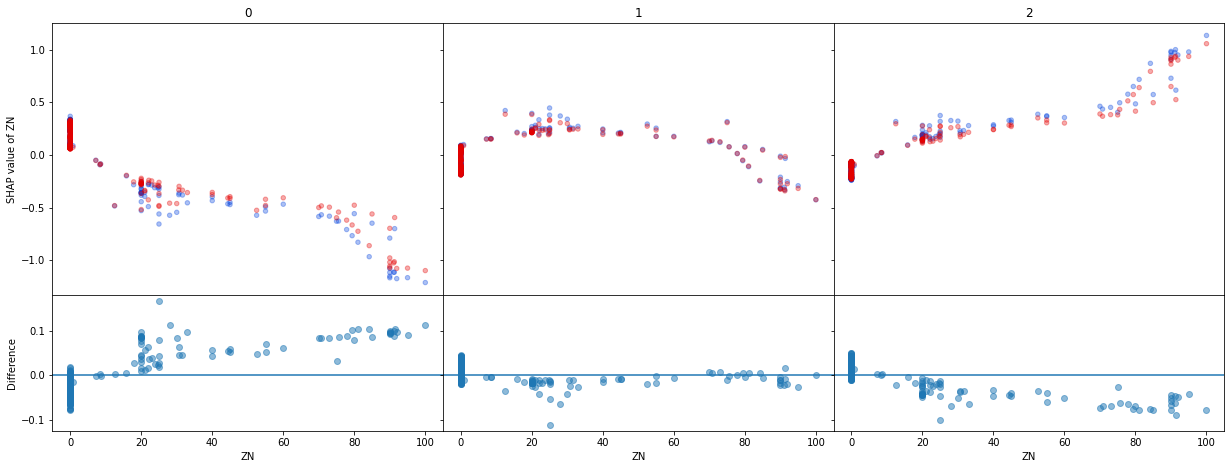

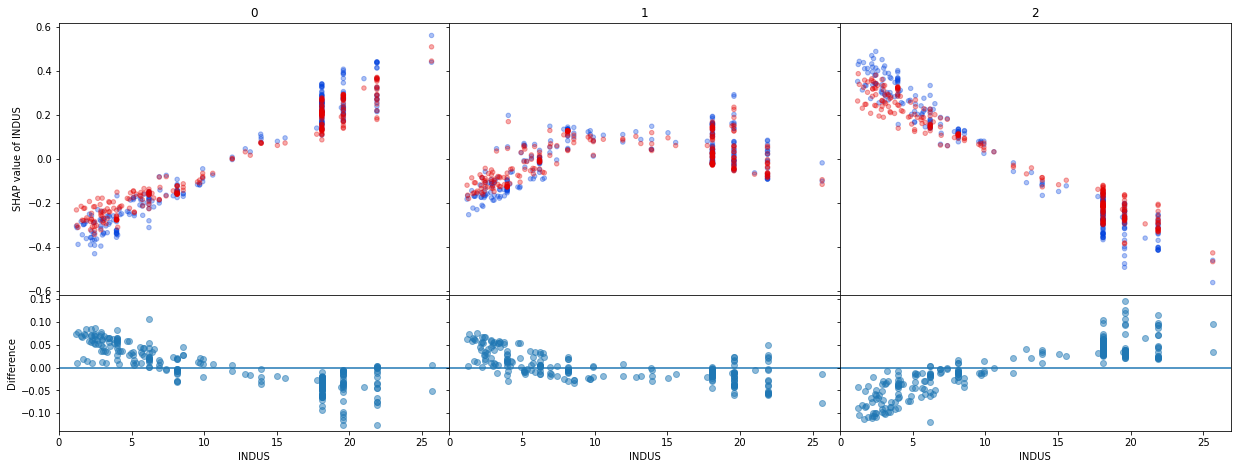

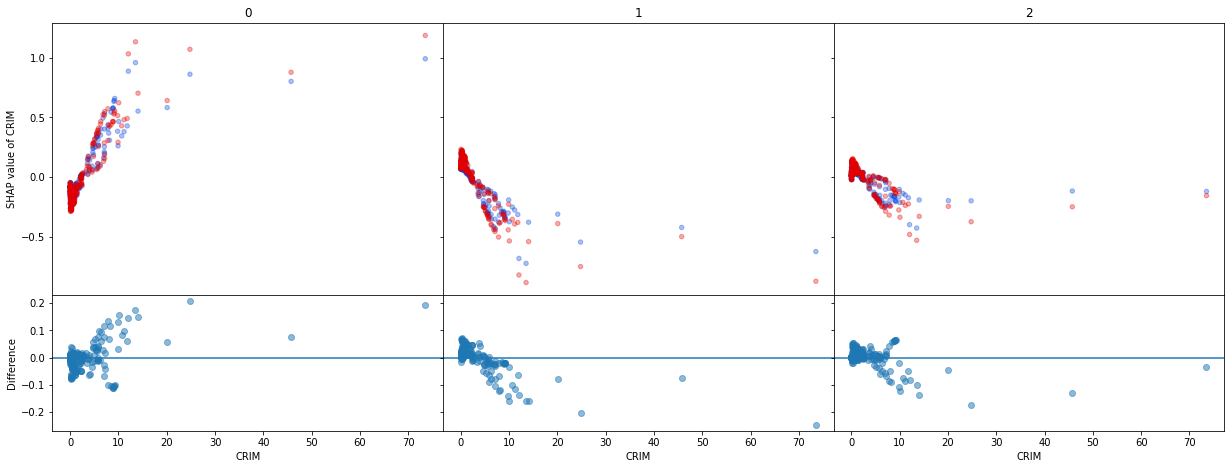

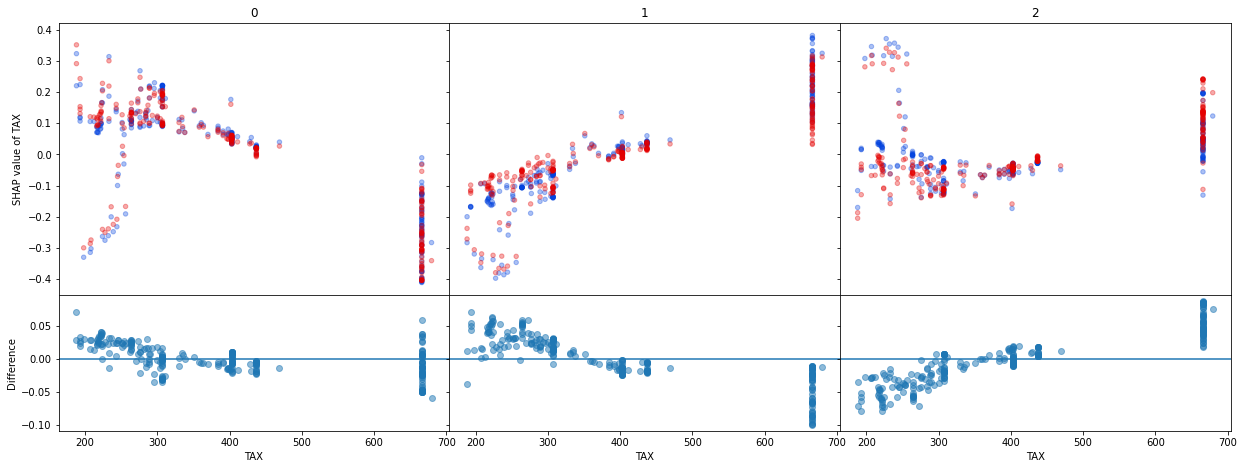

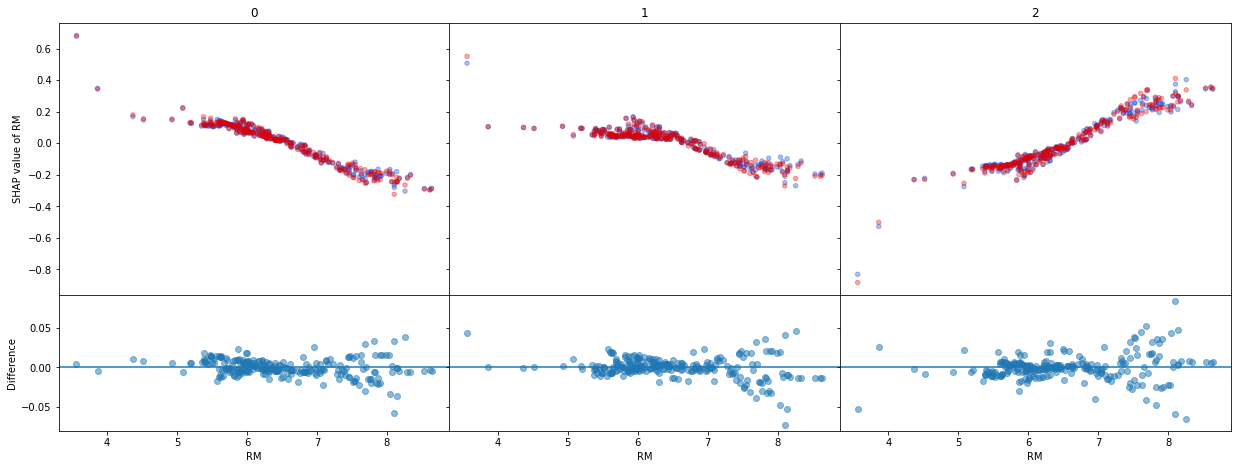

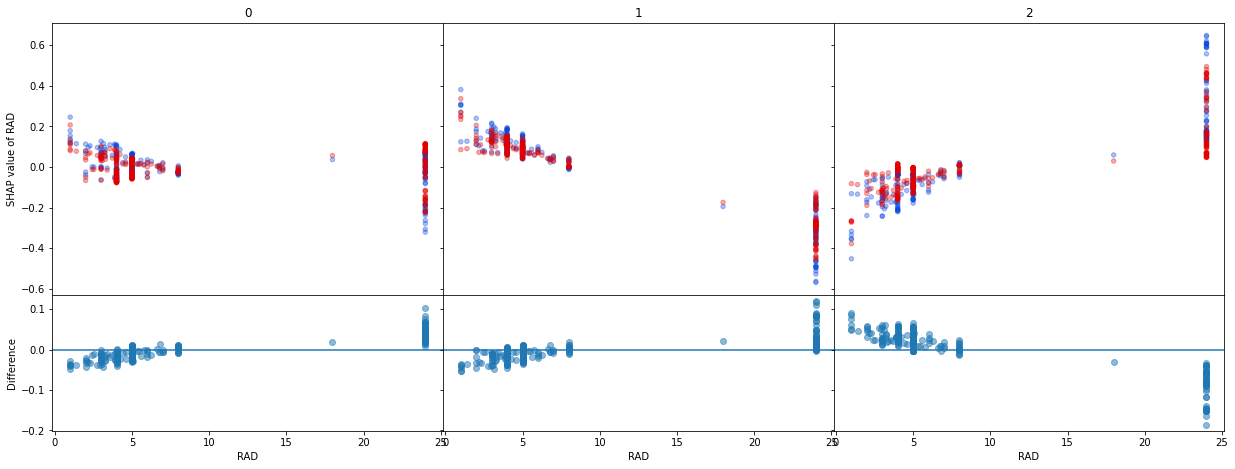

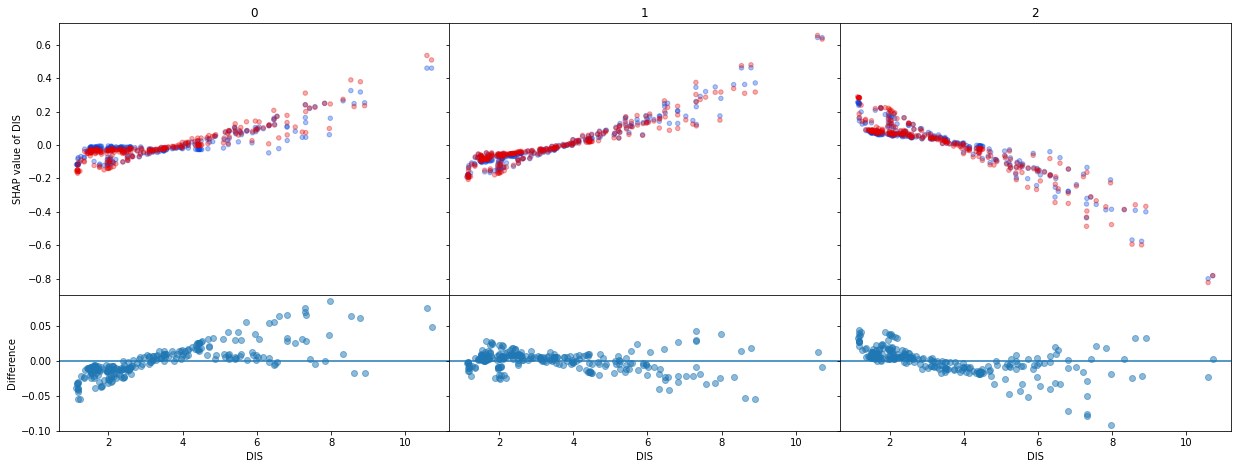

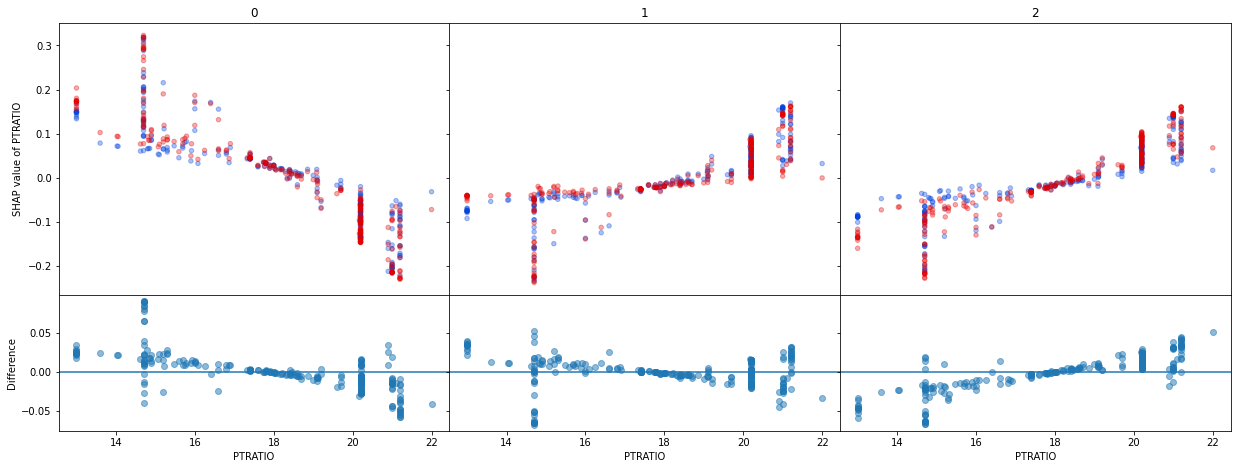

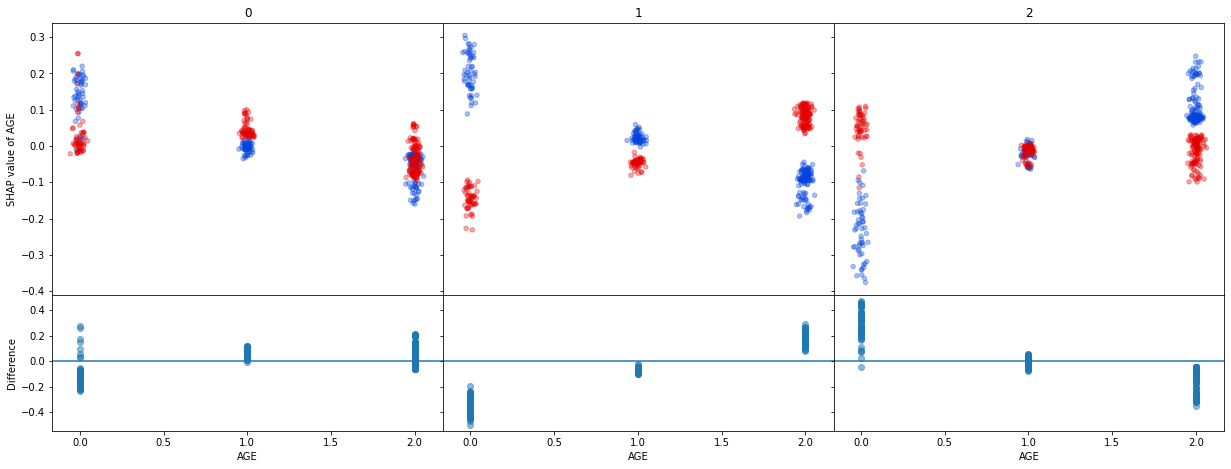

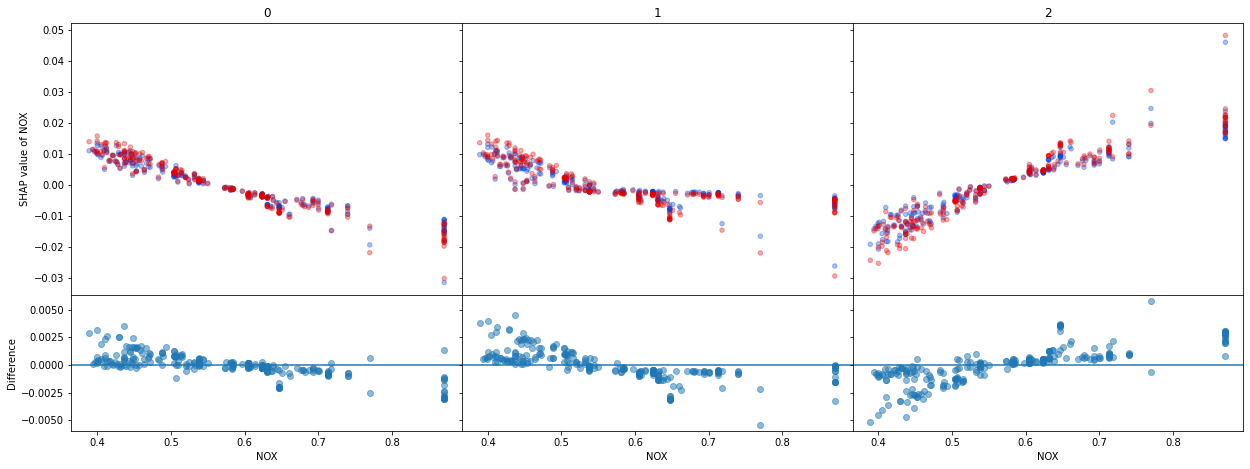

In [9]:
for feature in node.features_ordered:
    compare_indiv_dep_plots(node, feature)
    plt.show()

In [71]:
feature_it = iter(feature_order)

In [72]:
def plot_next_feature():
    feature = next(feature_it)
    for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
        node.plot_feature_dependence(feature, classes=list(classes), alpha=0.5)

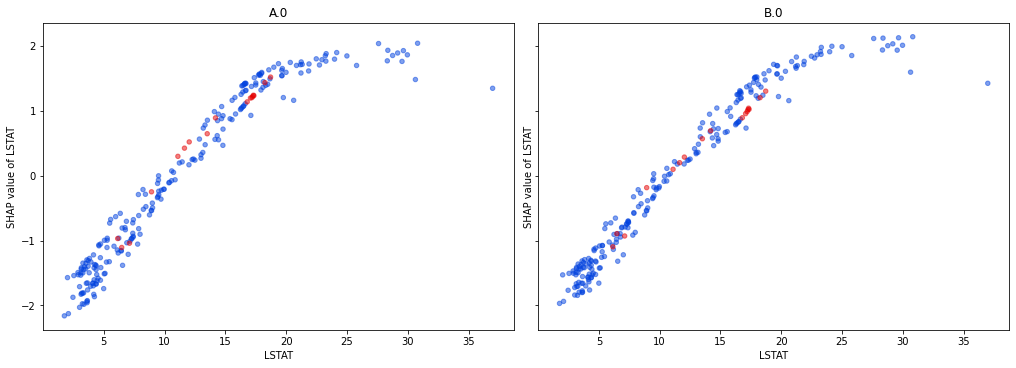

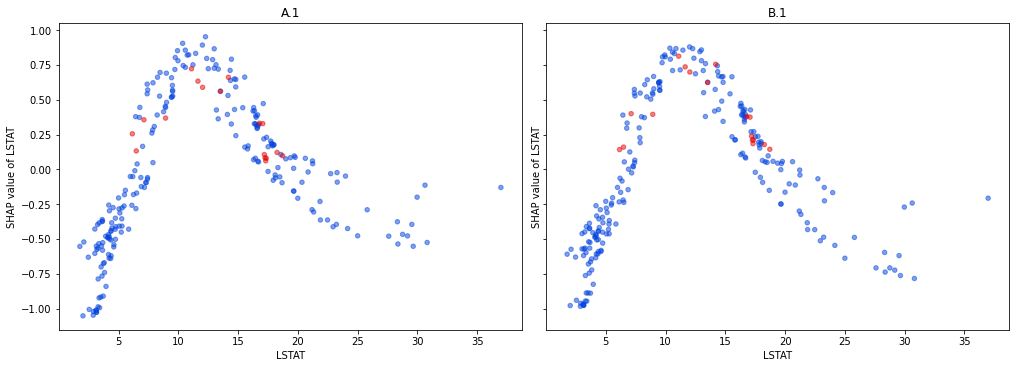

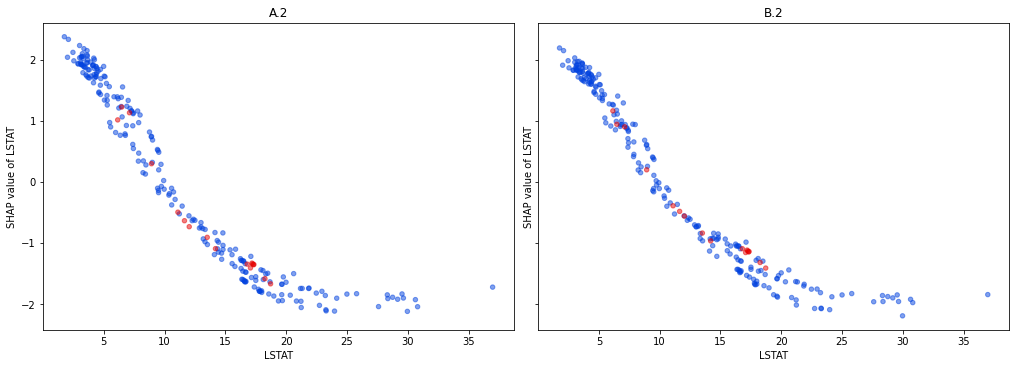

In [13]:
plot_next_feature()

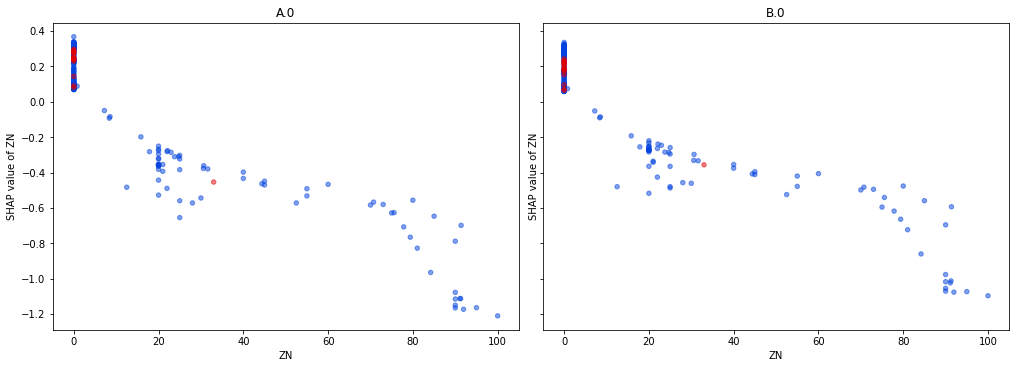

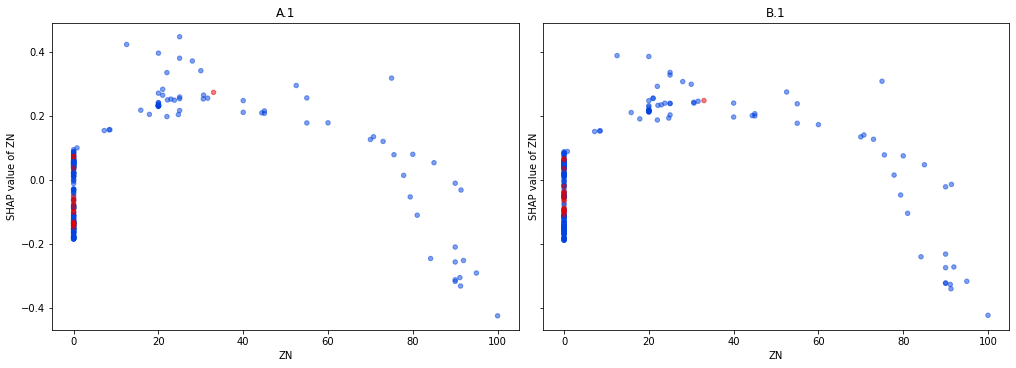

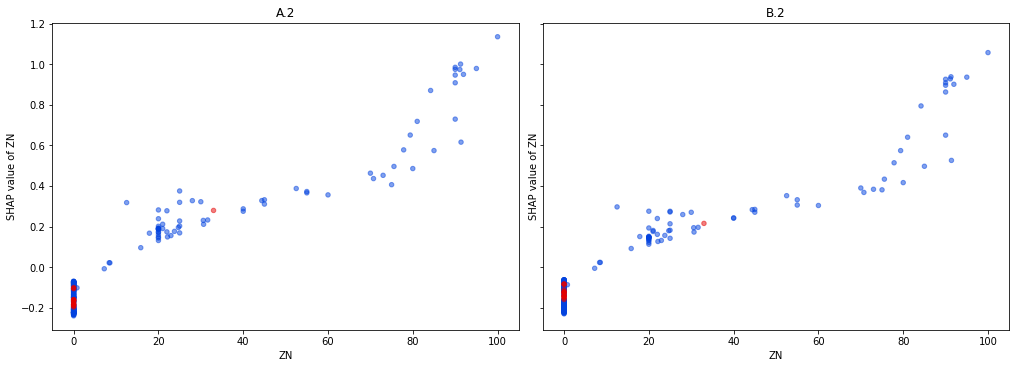

In [14]:
plot_next_feature()

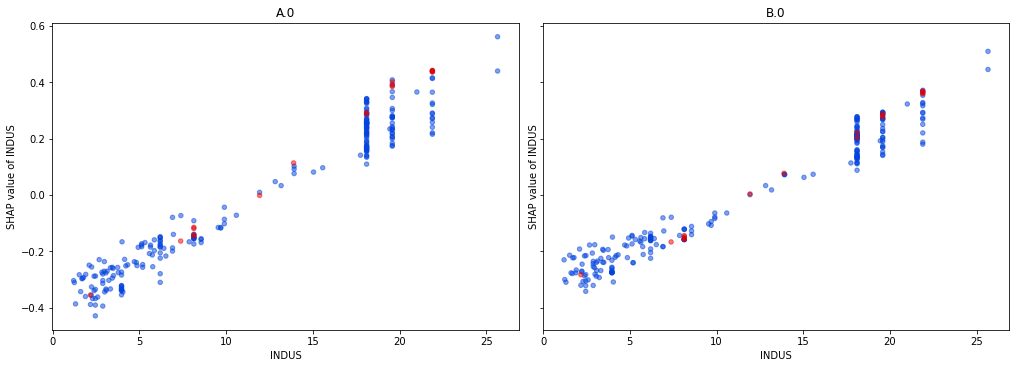

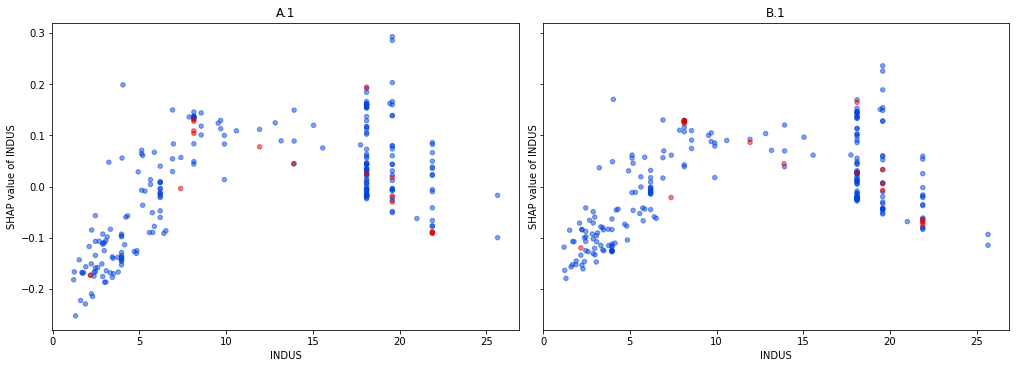

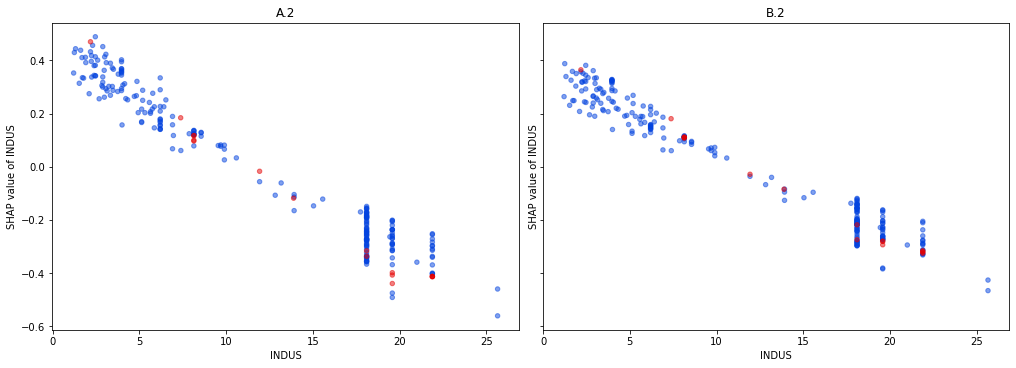

In [15]:
plot_next_feature()

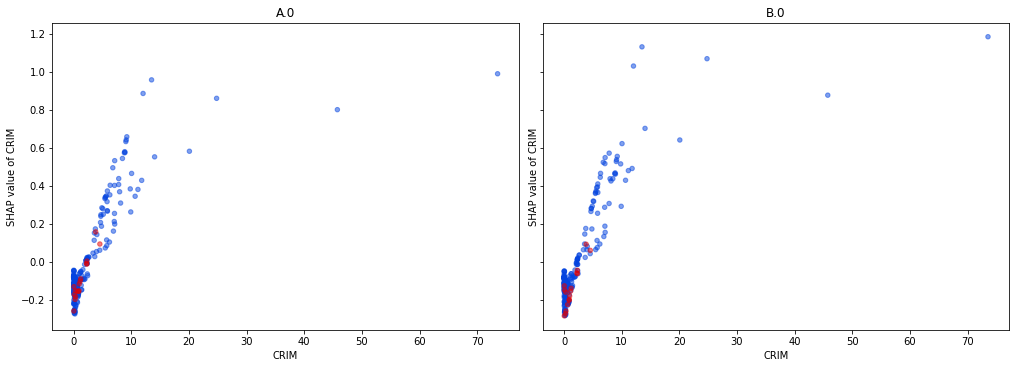

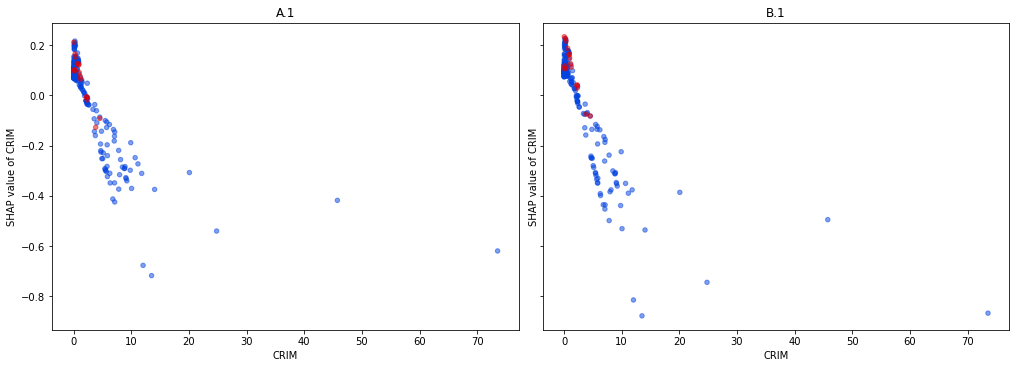

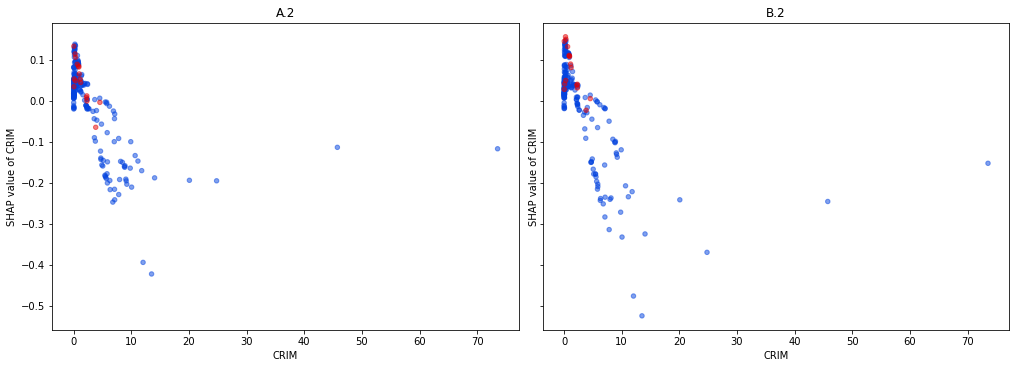

In [16]:
plot_next_feature()

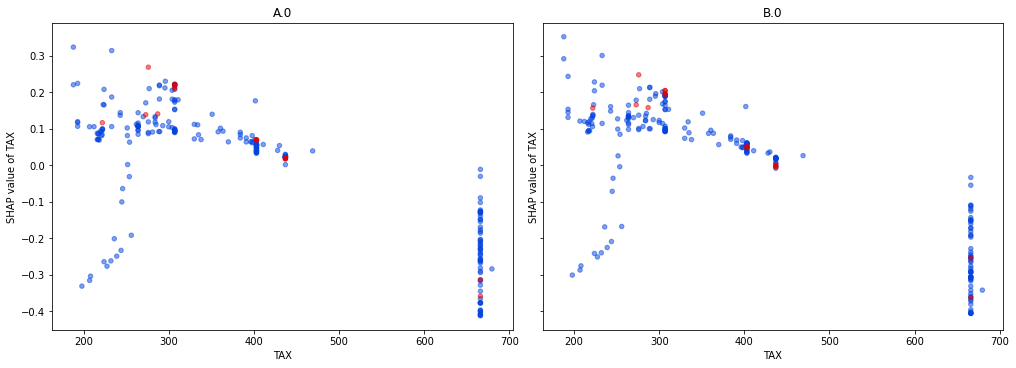

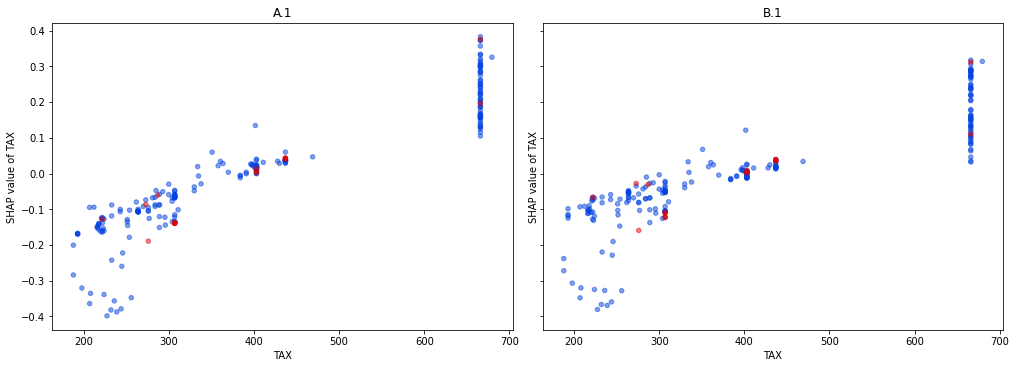

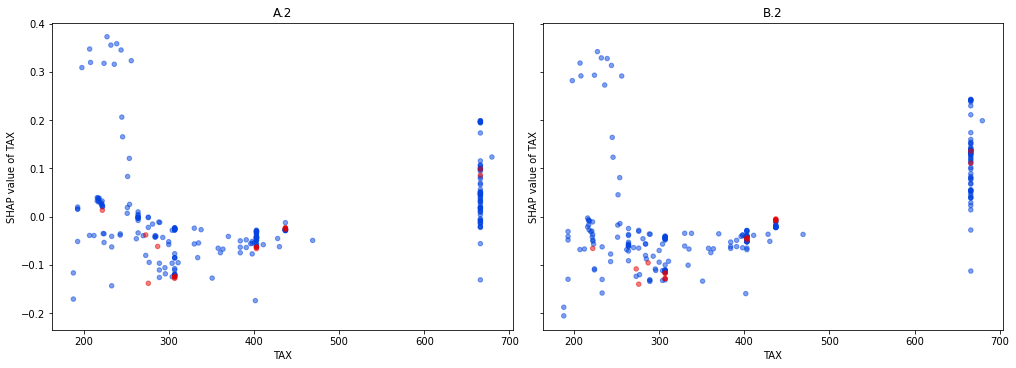

In [17]:
plot_next_feature()

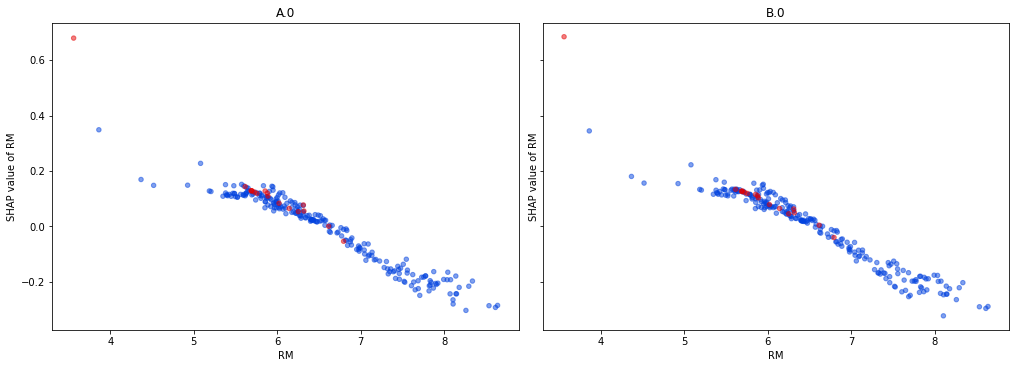

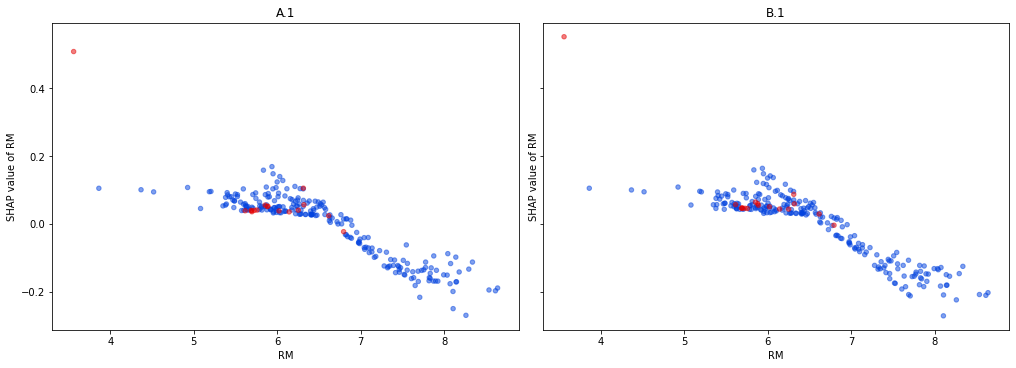

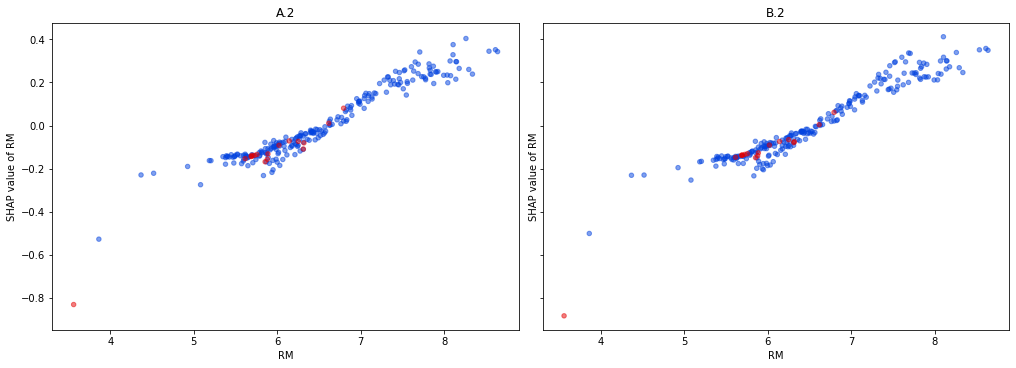

In [18]:
plot_next_feature()

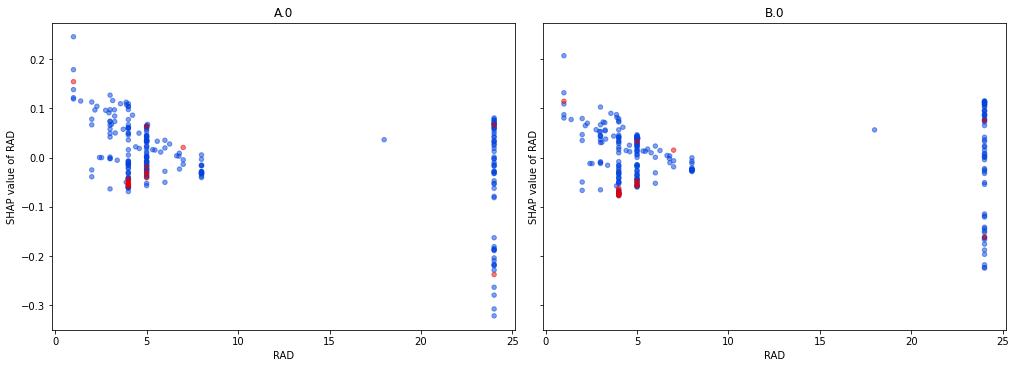

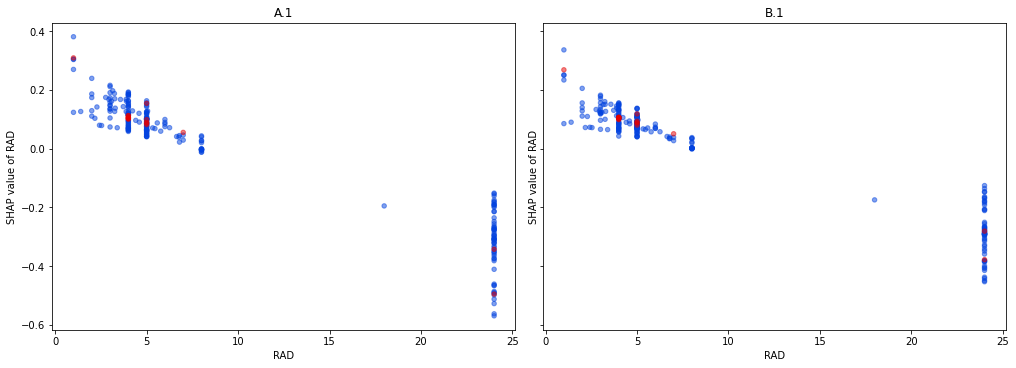

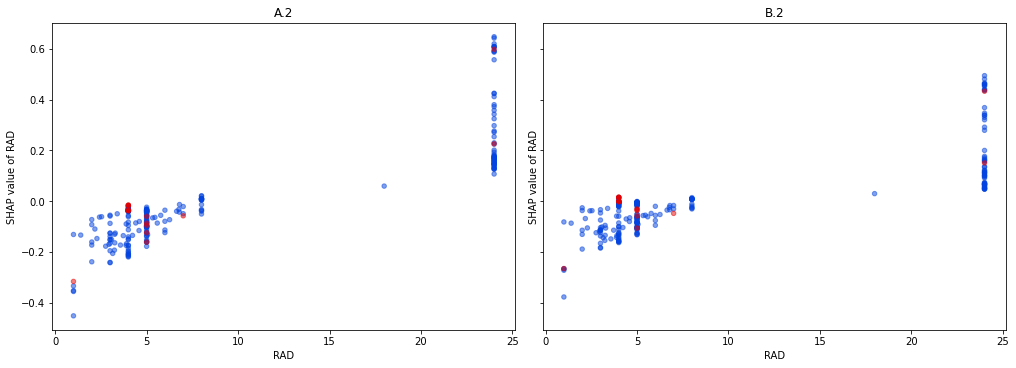

In [19]:
plot_next_feature()

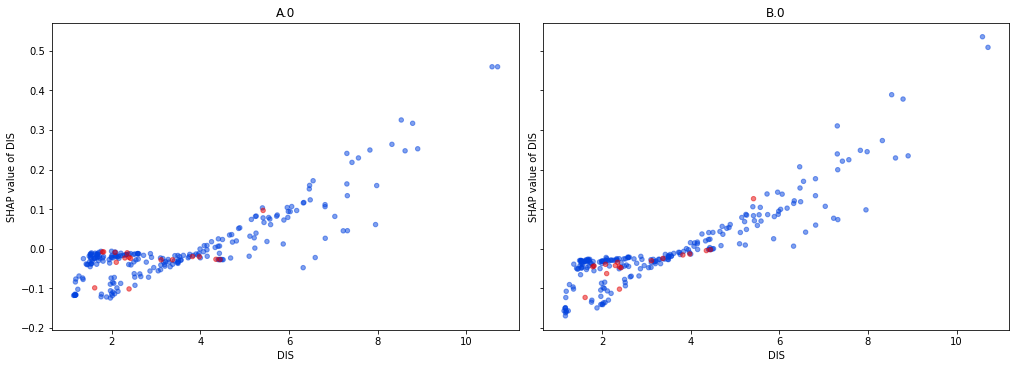

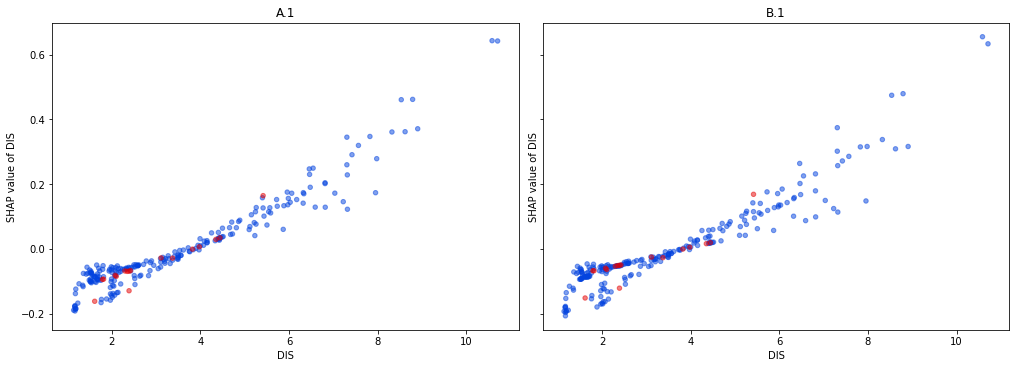

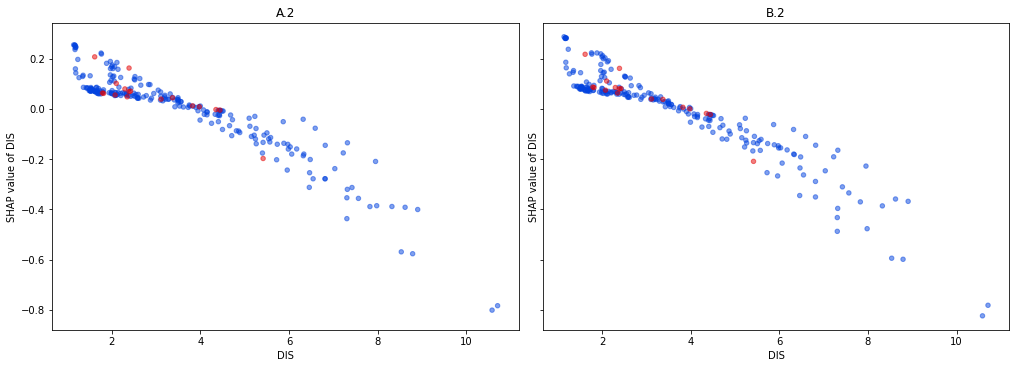

In [20]:
plot_next_feature()

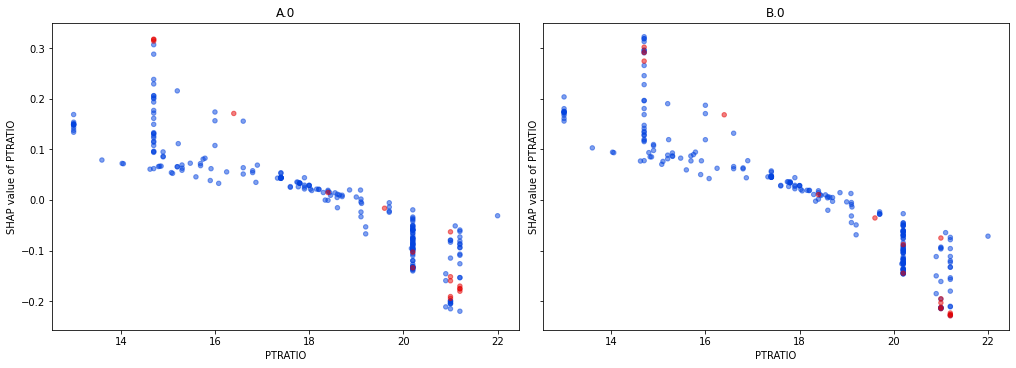

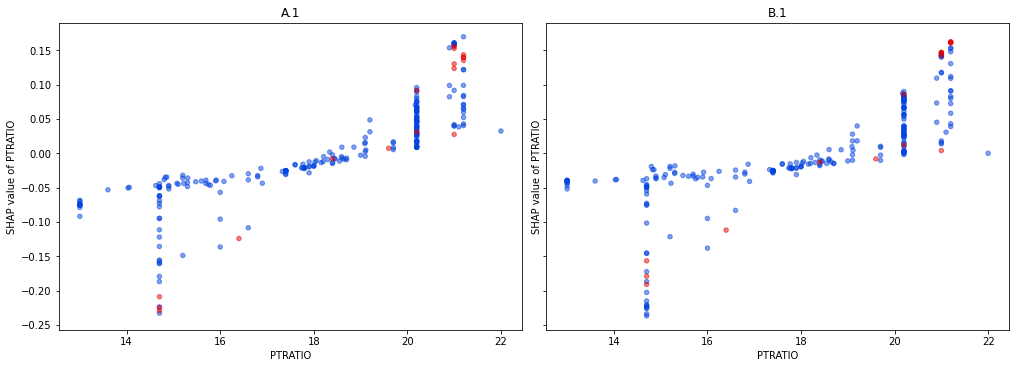

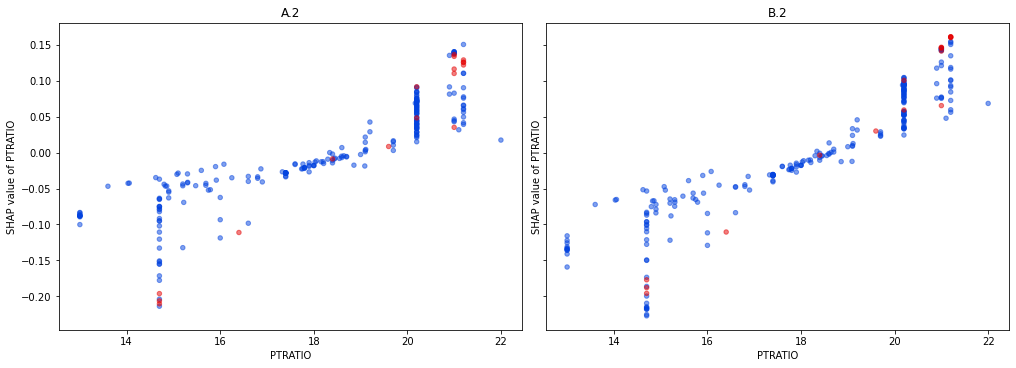

In [21]:
plot_next_feature()

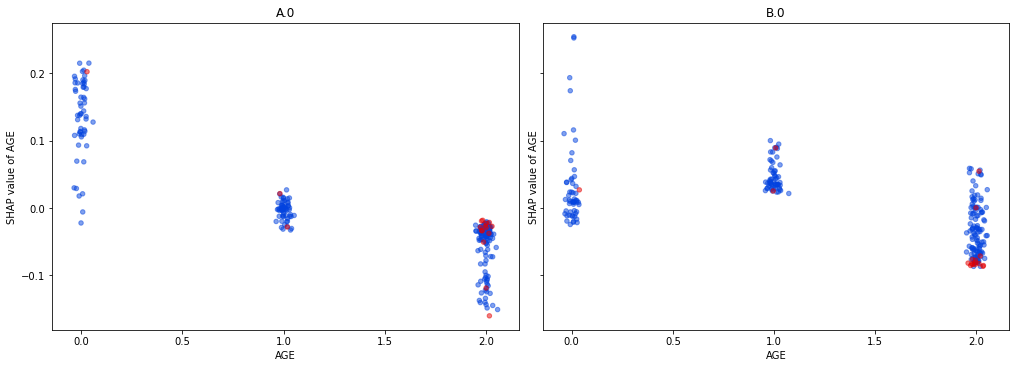

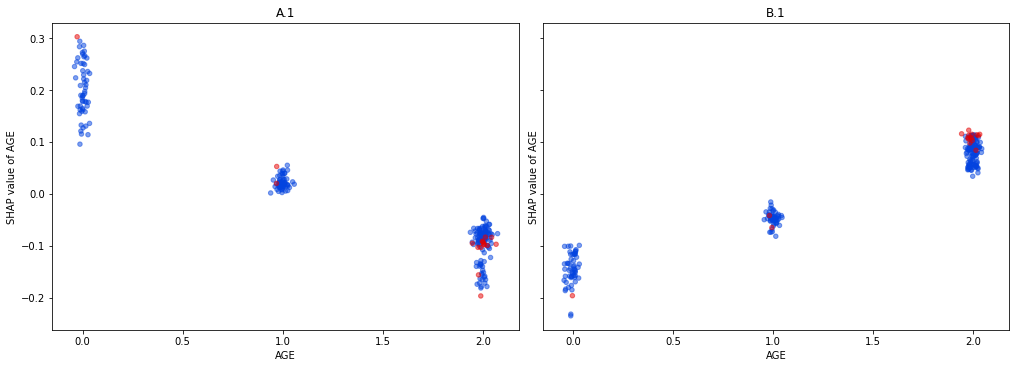

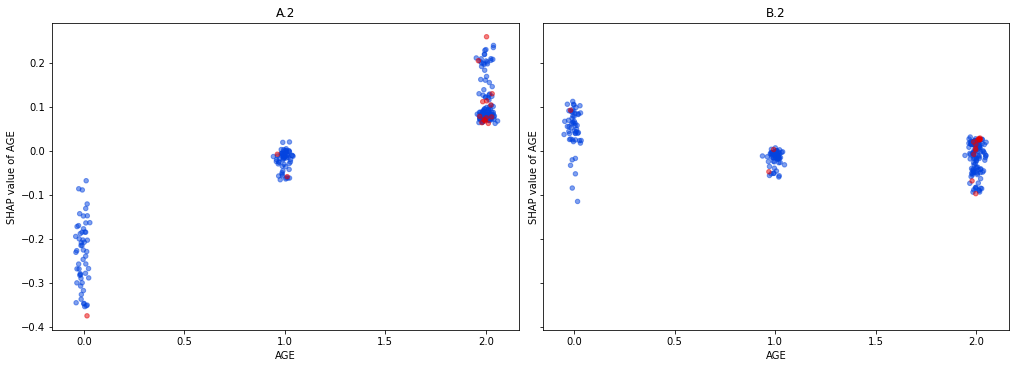

In [22]:
plot_next_feature()

AGE has a strong, directly related effect to its feature values on A's class 0 outcome and constant effect on that of B, however only if LSTAT is low

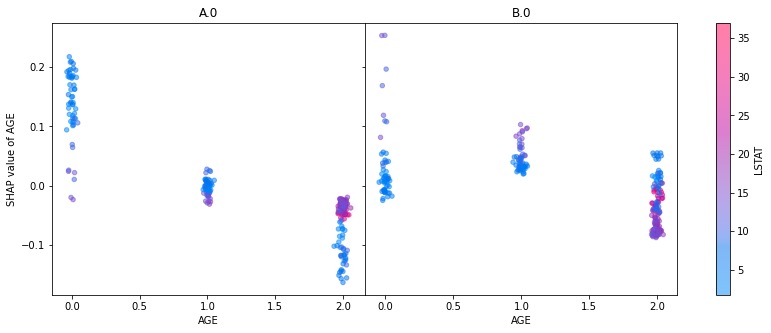

In [73]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'A.0'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.0', 'B.0'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

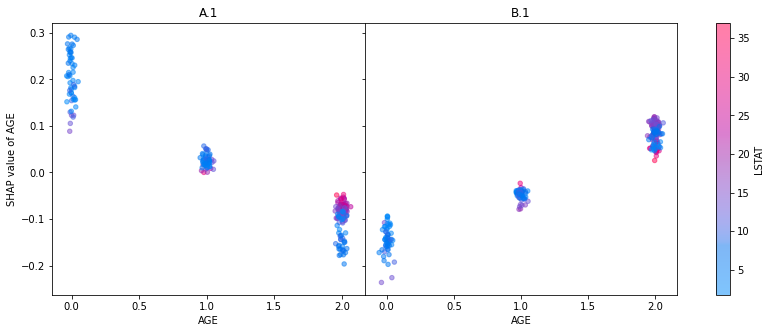

In [78]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'A.1'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.1', 'B.1'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

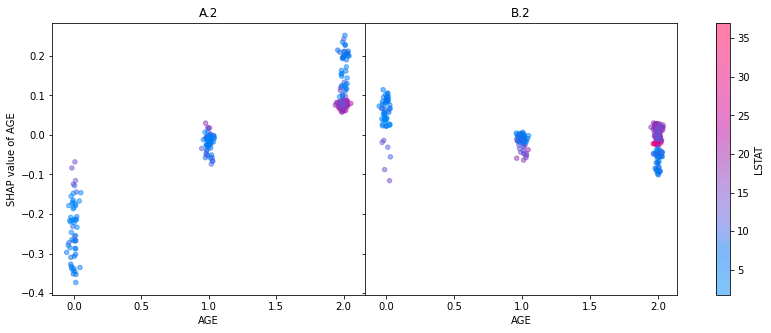

In [81]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'A.2'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.2', 'B.2'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

# Difference Classifier SHAP Explanations

In [6]:
with open('diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

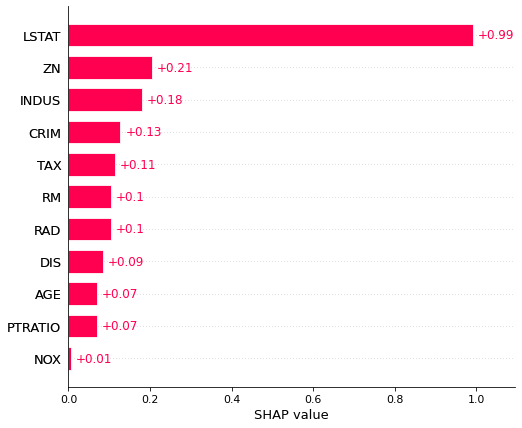

In [7]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

In [8]:
feature_order = feature_order[:-1]

The equality classes (0,0) and (2,2) have the highest mean absolute SHAP value, which means that the influences to and from these classes are highest. 

(0,2) and (2,0) have the least importances.

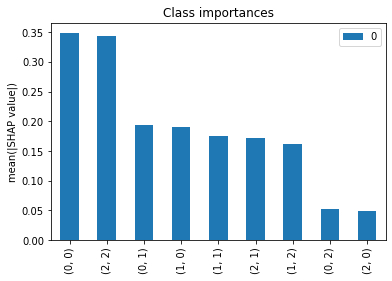

In [9]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

In [10]:
class_order = np.sort(class_order[:-2])

In [11]:
def plot(feature, **kwargs):
    node.describe_feature_differences(feature)
    pprint(node.counterfactuals[feature])
    if 'focus' not in kwargs:
        kwargs['focus'] = node
    node.root.plot_feature_dependence(feature, alpha=0.5, **kwargs)

In [12]:
def plot_2d(node, x, y):
    comparer.plot_decision_boundaries(node.root.data, x=x, y=y, alpha=0.5)
    for cf in node.counterfactuals[x]:
        plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
    for cf in node.counterfactuals[y]:
        plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

In [13]:
global_fidelities = {}
local_fidelities = {}
complexities = {}

## Clustering of Class $(0,1)$ SHAP Values

In [58]:
focus_class = '(0, 1)'

In [17]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       focus_class, ['(0, 0)', '(0, 1)', '(1, 1)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
with open(f'clustering.{focus_class}.pickle', 'wb') as f:
    pickle.dump(node, f)
node.class_counts, node.distance

CPU times: user 34.5 s, sys: 157 ms, total: 34.6 s
Wall time: 34.8 s


((2, 2)    95
 (0, 0)    76
 (1, 1)    58
 (0, 1)    13
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 53.48179984991664)

In [59]:
with open(f'clustering.{focus_class}.pickle', 'rb') as f:
    node = pickle.load(f)
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

### Main Node (L)

In [24]:
node = node.root.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(L,
 (0, 0)    76
 (1, 1)    33
 (0, 1)    13
 dtype: int64,
 15.373174011970239)

In [17]:
feature_it = iter(node.features_with_counterfactuals)

The differences are in a certain range, where the dependence curve of the difference class has a global high.

11.1 <= LSTAT <= 18.72
[Lower CF: LSTAT == 10.24 --> {'(1, 1)': 13},
 Upper CF: LSTAT == 19.17 --> {'(0, 0)': 13}]


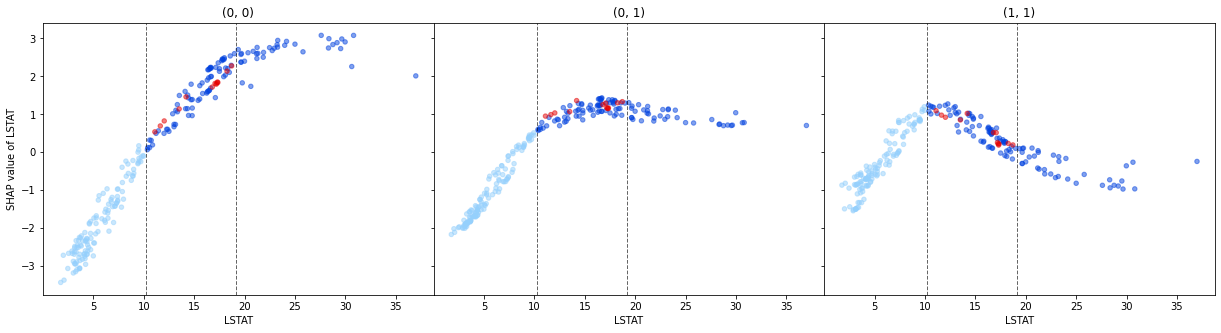

In [24]:
feature = next(feature_it)
plot(feature)

ZN is zero for all instances classified differently, and at 6, all instances flip to $(1,1)$, which has highest outcome increase there.

ZN == 0.0
[Upper CF: ZN == 6.0 --> {'(1, 1)': 13}]


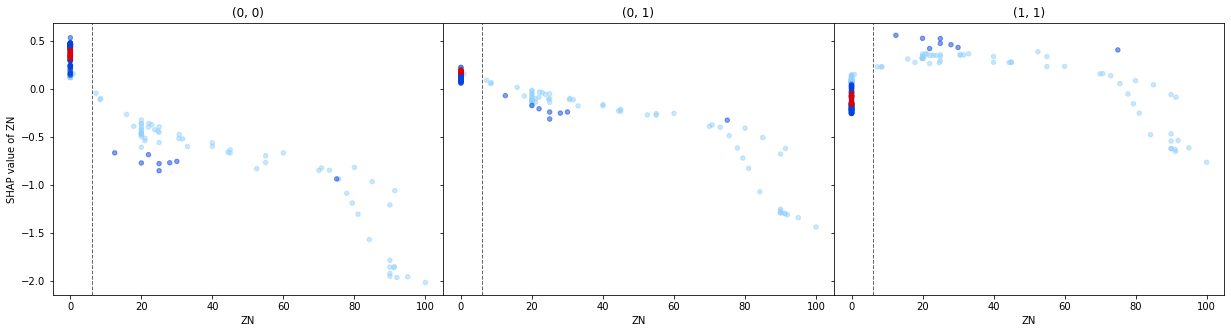

In [25]:
feature = next(feature_it)
plot(feature)

The $(0,0)$ outcomes of CRIM increase linearly for increasing values, at 7 all instances classified differently flip to this class.

0.0456 <= CRIM <= 3.83684
[Upper CF: CRIM == 7.0 --> {'(0, 0)': 13}]


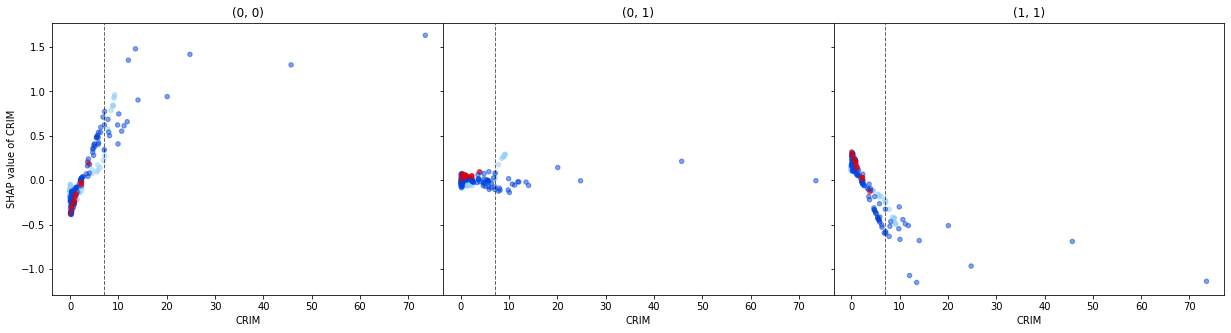

In [26]:
feature = next(feature_it)
plot(feature)

For AGE, I see a linear trend for the current cluster for all classes. Higher values tend to increase the outcome of the difference class, and to a lesser extent that of $(1,1)$.

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(0, 0)': 8, '(1, 0)': 5}]


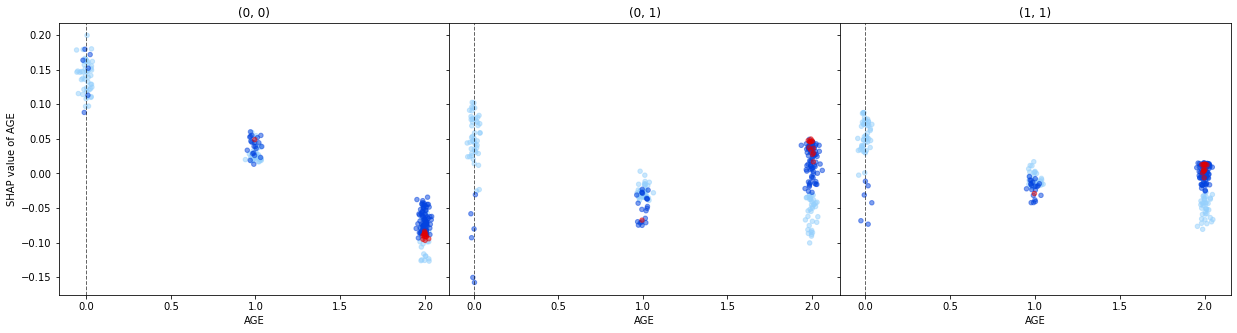

In [27]:
feature = next(feature_it)
plot(feature)

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(0, 0)': 8, '(1, 0)': 5}]


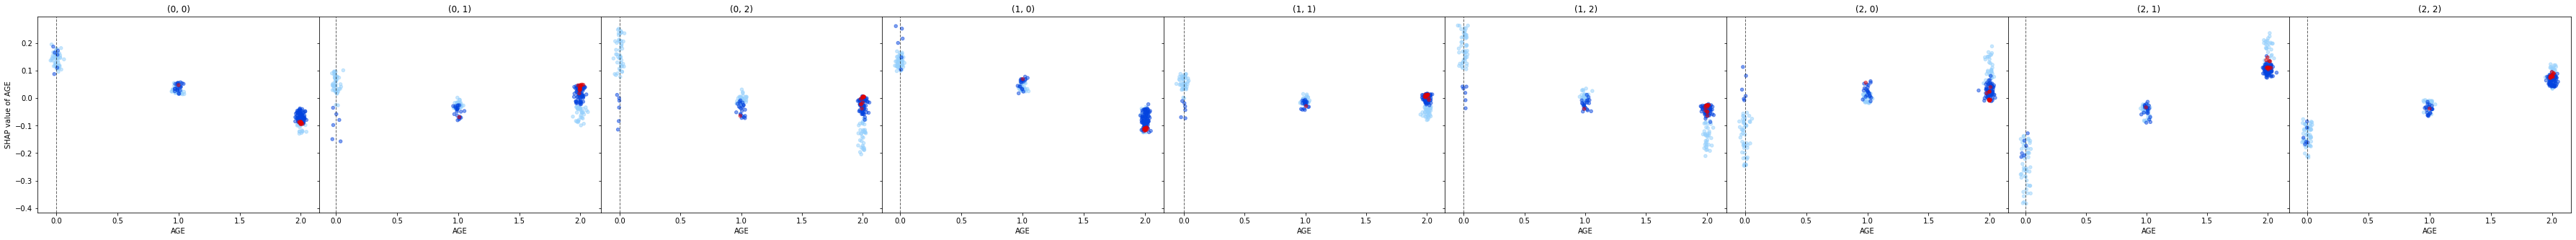

In [26]:
plot('AGE', classes=comparer.class_names)

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(0, 0)': 8, '(1, 0)': 5}]


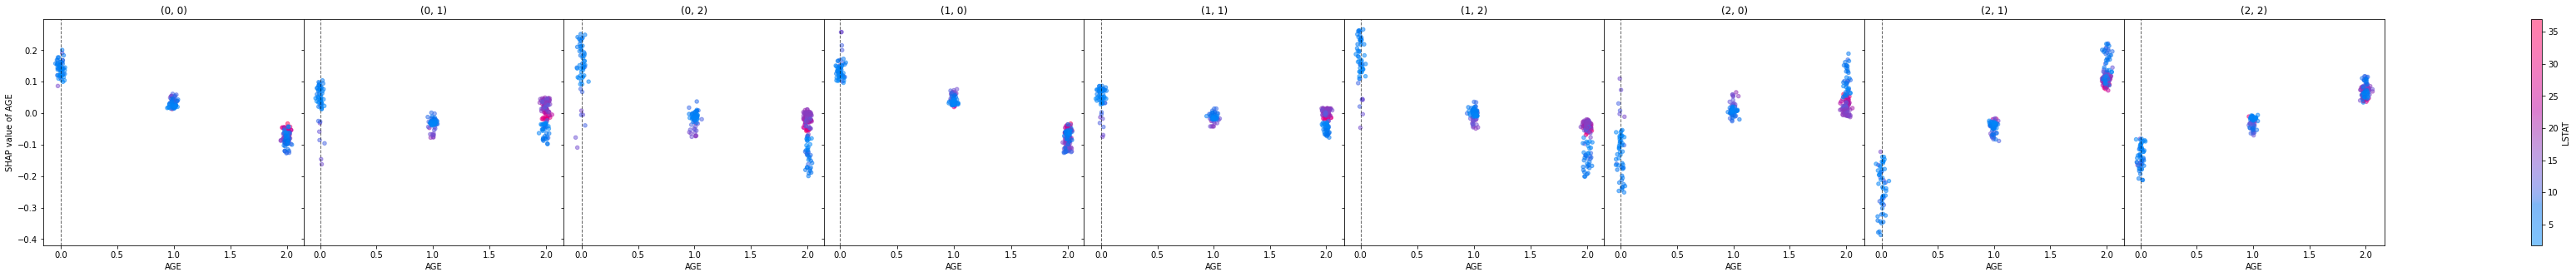

In [32]:
plot('AGE', focus=None, color='LSTAT', classes=comparer.class_names)

In [61]:
part = node.root.filter((10.24 < node.root.data['LSTAT']) & (node.root.data['LSTAT'] <= 19.16))

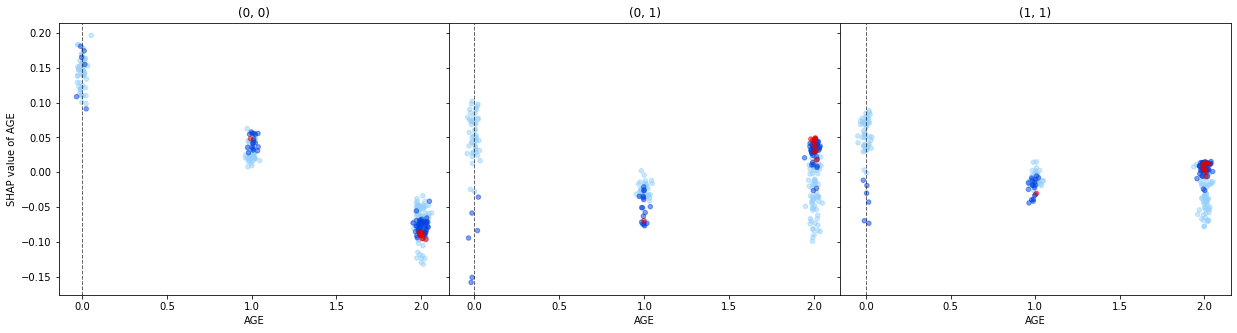

In [23]:
node.root.plot_feature_dependence('AGE', alpha=0.5, focus=part)

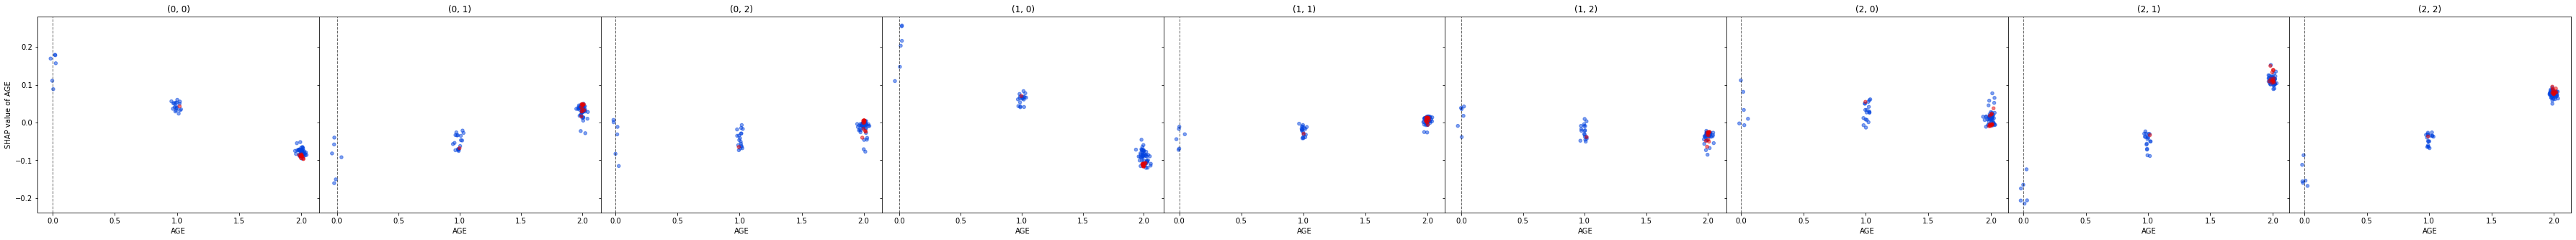

In [26]:
part.plot_feature_dependence('AGE', alpha=0.5, classes=comparer.class_names)

in this LSTAT range, high AGE increases the outcome of (2,1), (2,2) and (0,1). So why are some classified (0,1)? LSTAT has a much bigger negative influence in this range, thus preventing the first two labels and enforcing the third.

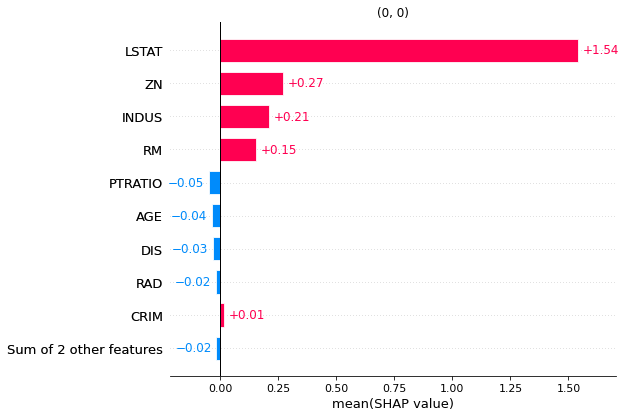

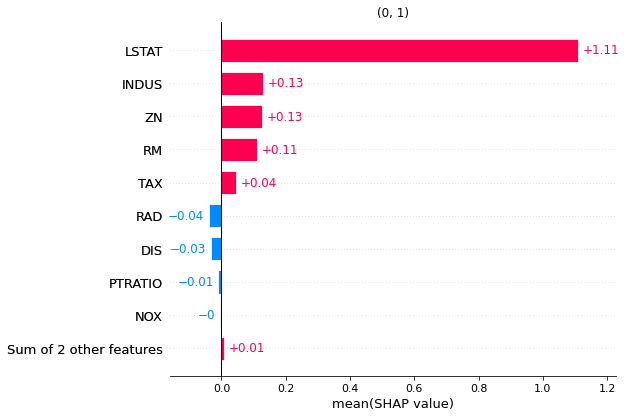

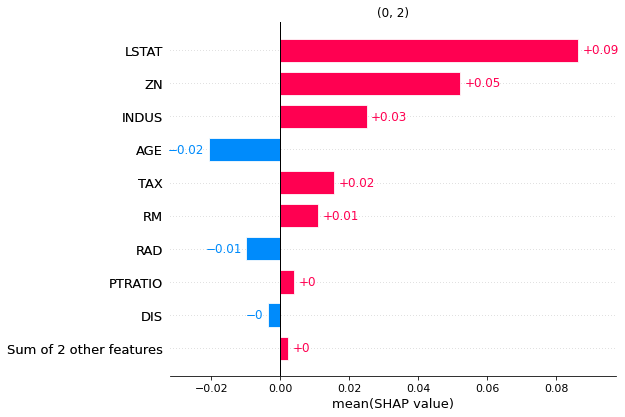

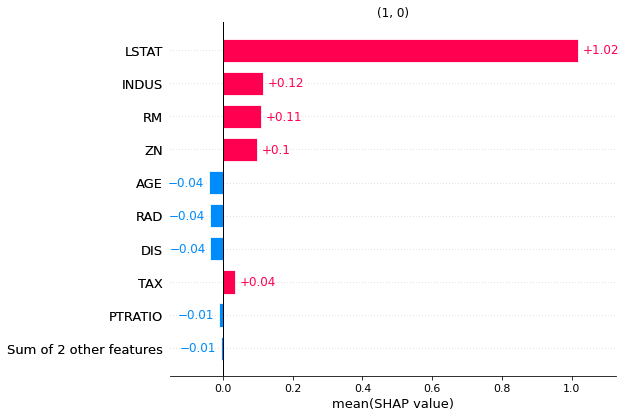

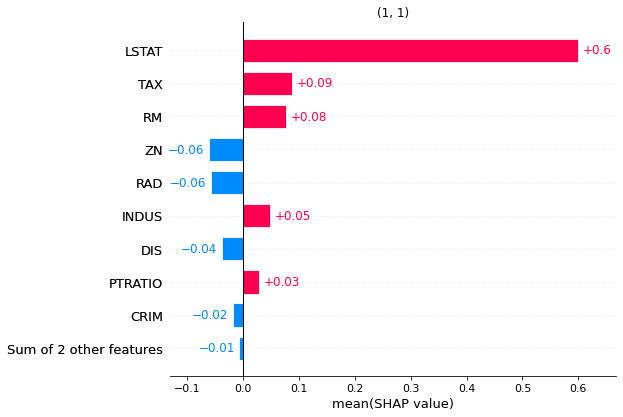

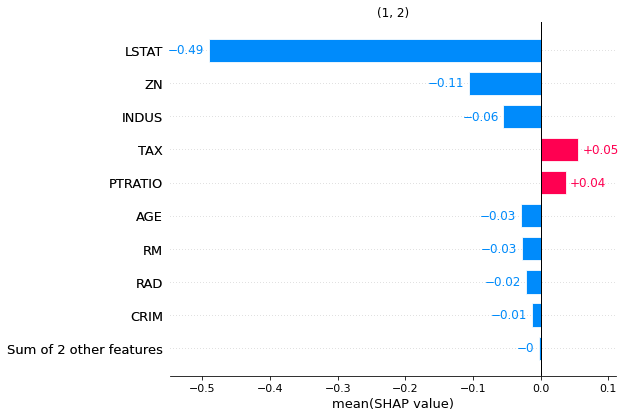

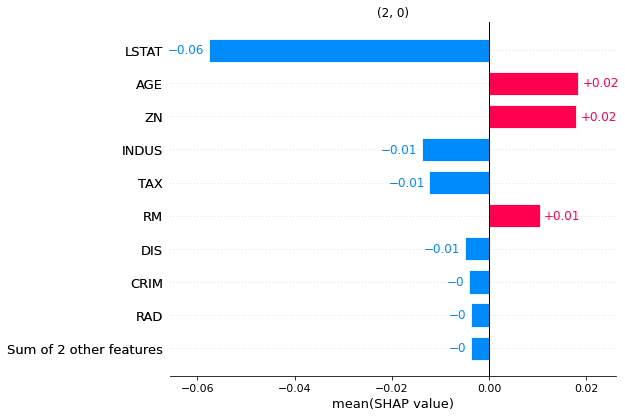

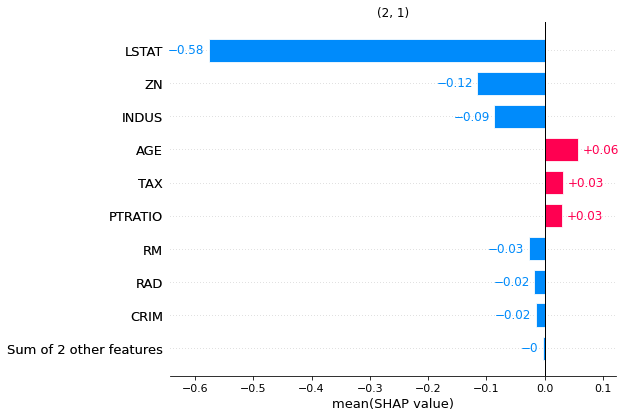

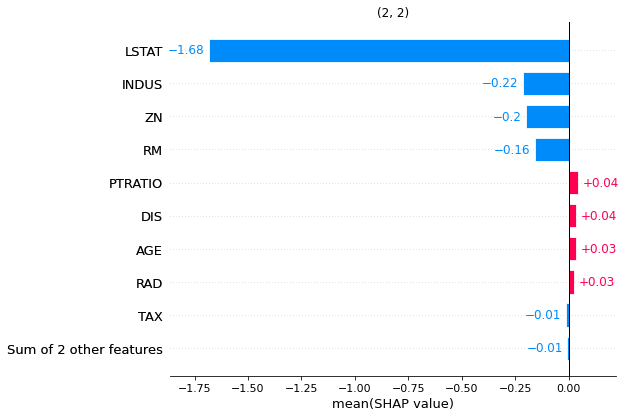

In [62]:
for class_name in comparer.class_names:
    bar(part.shap_values[:, :, class_name].mean(0), show=False)
    plt.title(class_name)
    plt.show()

In [28]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'ZN', 'CRIM', 'AGE')
print(rule)
node.evaluate_rules(rule)

10.24 < LSTAT <= 19.16 and ZN <= 5.0 and CRIM <= 6.0 and AGE > 0.0
              precision    recall  f1-score   support

       False       1.00      0.52      0.69       109
        True       0.20      1.00      0.33        13

    accuracy                           0.57       122
   macro avg       0.60      0.76      0.51       122
weighted avg       0.91      0.57      0.65       122



Precision    Recall  F1 Score  Support
False        1.0  0.522936  0.686747      109
True         0.2  1.000000  0.333333       13

In [35]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'AGE')
print(rule)
node.evaluate_rules(rule)

10.24 < LSTAT <= 19.16 and AGE > 0.0
              precision    recall  f1-score   support

       False       0.96      0.69      0.80       233
        True       0.08      0.46      0.13        13

    accuracy                           0.67       246
   macro avg       0.52      0.57      0.47       246
weighted avg       0.91      0.67      0.76       246



Precision    Recall  F1 Score  Support
False   0.958084  0.686695  0.800000      233
True    0.075949  0.461538  0.130435       13

In [29]:
explanations_global = [(rule, constraint, instance_indices)]

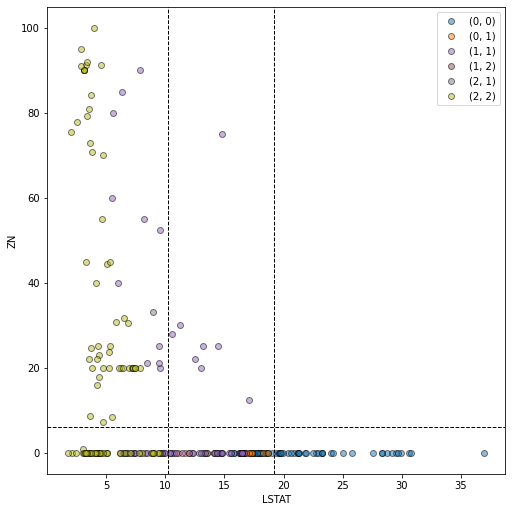

In [32]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Node 1 (LLRRR)

In [13]:
node = node.root.get('LLRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LLRRR,
 (0, 0)    8
 (0, 1)    6
 dtype: int64,
 1.8116858657052968)

The log-odds of $(0,1)$ of the instances classified differently are closer to $(0,0)$ than to $(1,1)$.

In [101]:
feature_it = iter(node.features_with_counterfactuals)

These six instances are in the upper part of the LSTAT range of differences. The lower counterfactual is higher than the global one, even higher than other instances classified differently.

17.19 <= LSTAT <= 18.72
[Lower CF: LSTAT == 14.9 --> {'(1, 1)': 6},
 Upper CF: LSTAT == 18.95 --> {'(0, 0)': 6}]


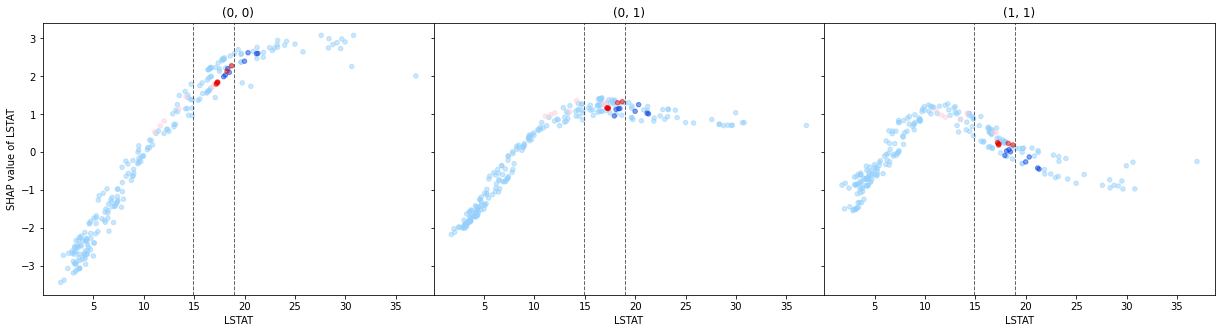

In [35]:
feature = next(feature_it)
plot(feature)

has particularly high influence on instances in this cluster, compared to other instances with ZN=0.

ZN == 0.0
[Upper CF: ZN == 6.0 --> {'(1, 1)': 6}]


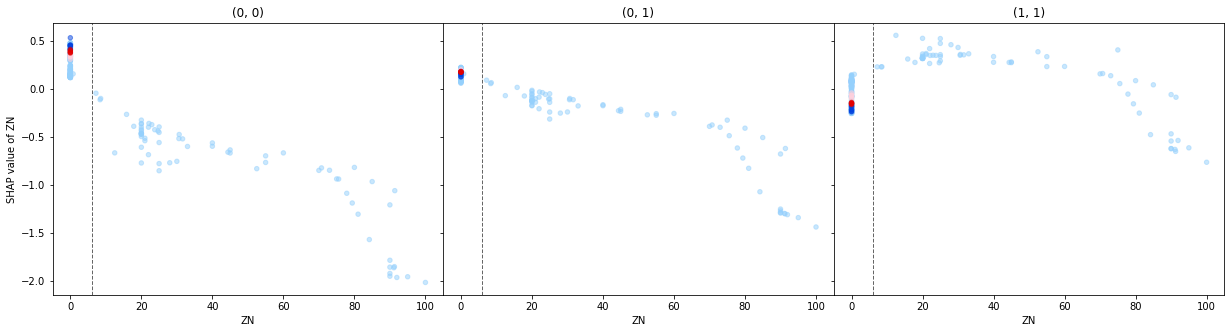

In [37]:
feature = next(feature_it)
plot(feature)

Instances in this cluster have a low CRIM value and its counterfactual is lower as well.

0.25915 <= CRIM <= 1.23247
[Upper CF: CRIM == 2.0 --> {'(0, 0)': 6}]


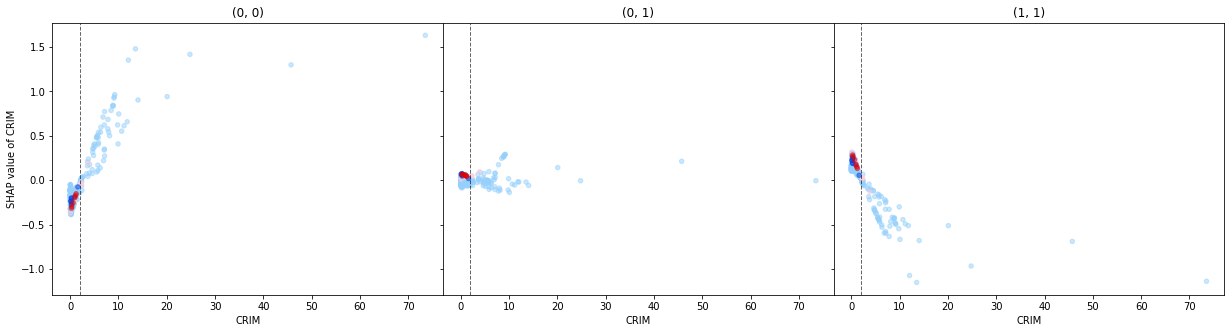

In [38]:
feature = next(feature_it)
plot(feature)

Especially the PTRATIO values are high, with a high counterfactual value as well.

21.0 <= PTRATIO <= 21.2
[Lower CF: PTRATIO == 19.53 --> {'(0, 0)': 6}]


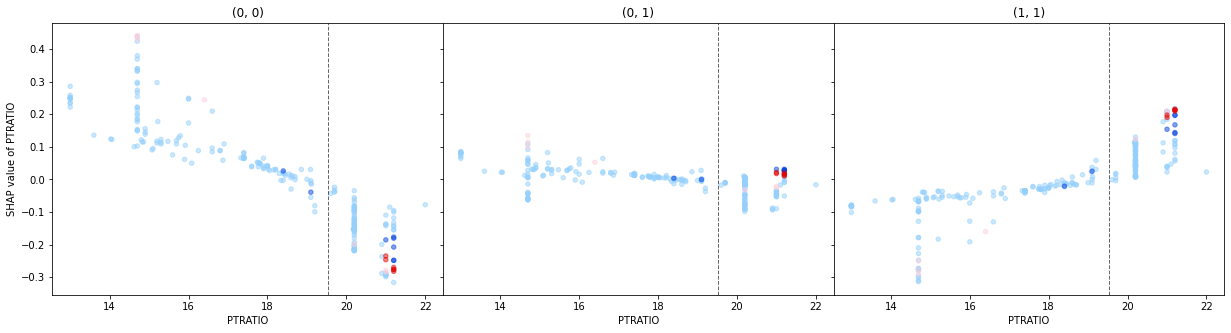

In [39]:
feature = next(feature_it)
plot(feature)

Different linear effects visible, but counterfactual is outside of main part of feature values, therefore not including it.

5.685294968854628 <= RM <= 6.142
[Lower CF: RM == 3.93 --> {'(0, 0)': 6}]


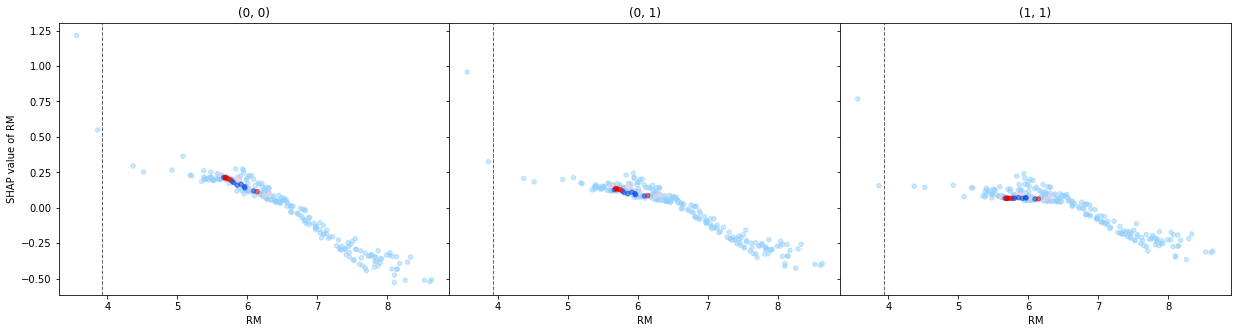

In [40]:
feature = next(feature_it)
plot(feature)

differences are in lower part of range

307.0 <= TAX <= 437.0
[Lower CF: TAX == 260.0 --> {'(0, 0)': 6},
 Upper CF: TAX == 619.0 --> {'(1, 1)': 6}]


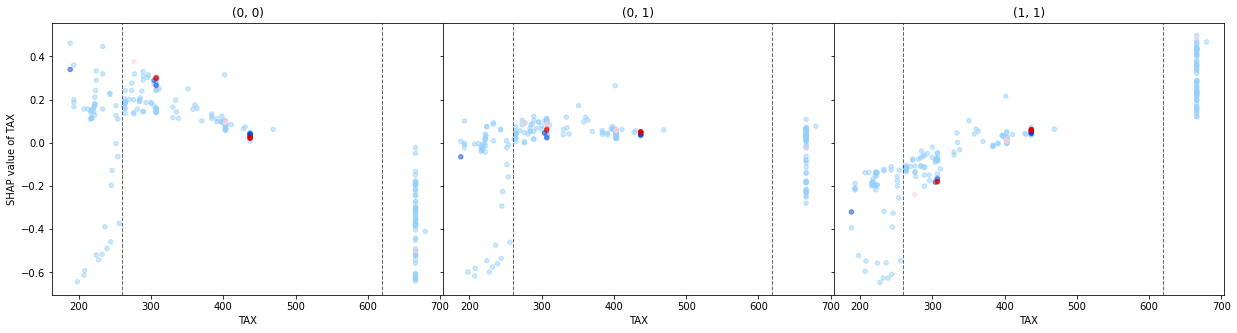

In [41]:
feature = next(feature_it)
plot(feature)

differences are in lower part of range

RAD == 4.0
[Upper CF: RAD == 12.41 --> {'(0, 0)': 6}]


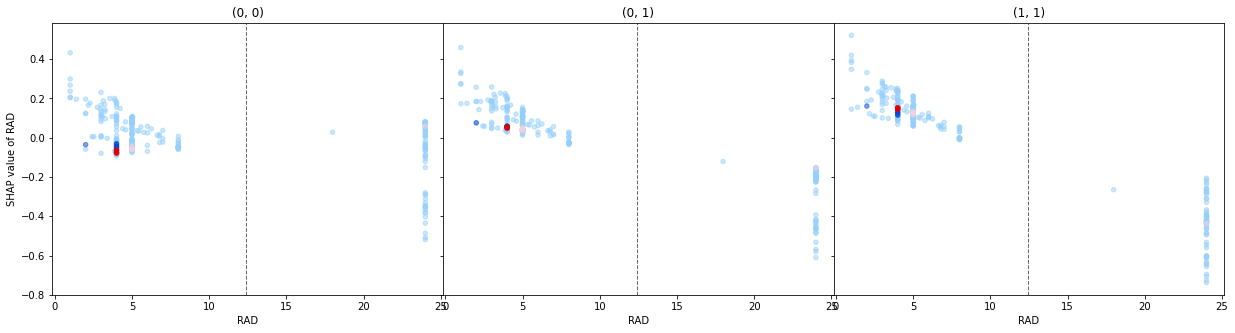

In [42]:
feature = next(feature_it)
plot(feature)

cf now higher at 1

AGE == 2.0
[Lower CF: AGE == 1.0 --> {'(0, 0)': 6}]


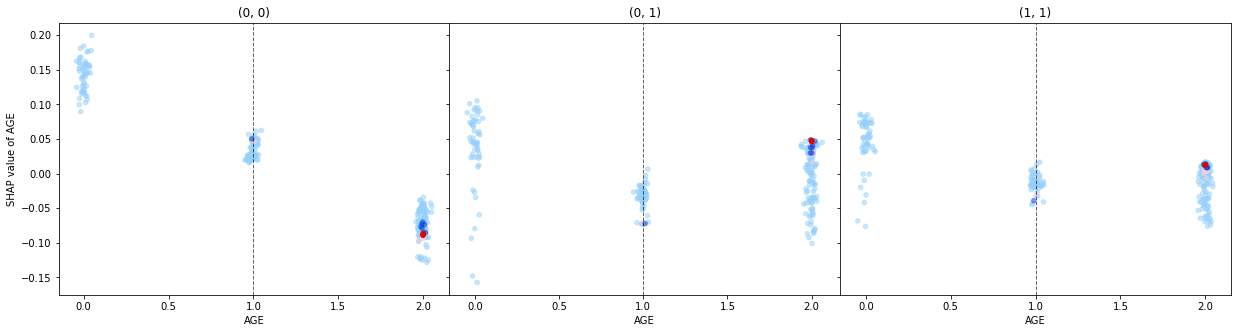

In [43]:
feature = next(feature_it)
plot(feature)

In [44]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'ZN', 'CRIM', 'AGE', 'PTRATIO', 'TAX', 'RAD')
print(rule)
node.evaluate_rules(rule)

14.9 < LSTAT <= 18.94 and ZN <= 5.0 and CRIM <= 1.0 and PTRATIO > 19.53 and 260.0 < TAX <= 618.0 and RAD <= 12.4 and AGE > 1.0
              precision    recall  f1-score   support

       False       0.75      0.75      0.75         8
        True       0.67      0.67      0.67         6

    accuracy                           0.71        14
   macro avg       0.71      0.71      0.71        14
weighted avg       0.71      0.71      0.71        14



Precision    Recall  F1 Score  Support
False   0.750000  0.750000  0.750000        8
True    0.666667  0.666667  0.666667        6

In [45]:
explanations_l1 = [(rule, constraint, instance_indices)]

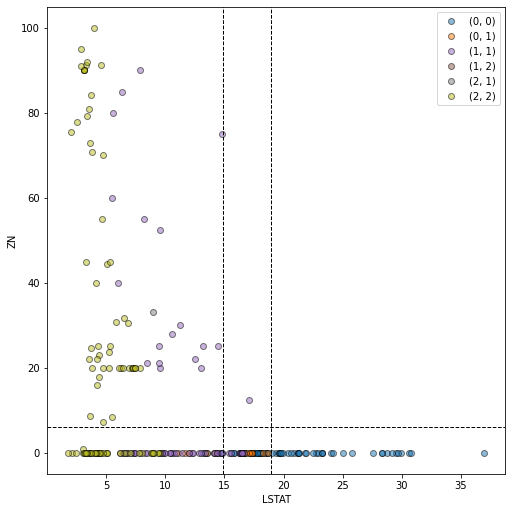

In [46]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Node 1.1 (LLRRRLRR)

In [47]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LLRRRLRR,
 (0, 1)    2
 dtype: int64,
 0.03473529736076898)

In [48]:
feature_it = iter(node.features_with_counterfactuals)

differences are in upper half of parent's differences range. 

18.25726553185902 <= LSTAT <= 18.72
[Lower CF: LSTAT == 16.39 --> {'(1, 1)': 2},
 Upper CF: LSTAT == 18.95 --> {'(0, 0)': 2}]


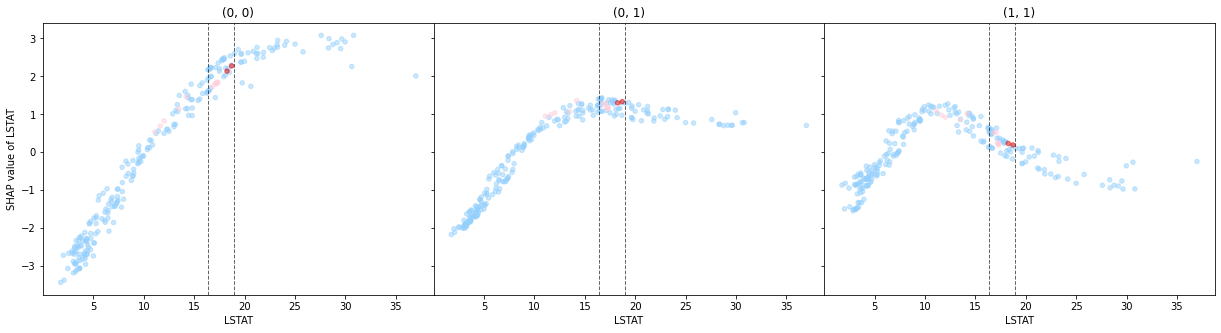

In [49]:
feature = next(feature_it)
plot(feature)

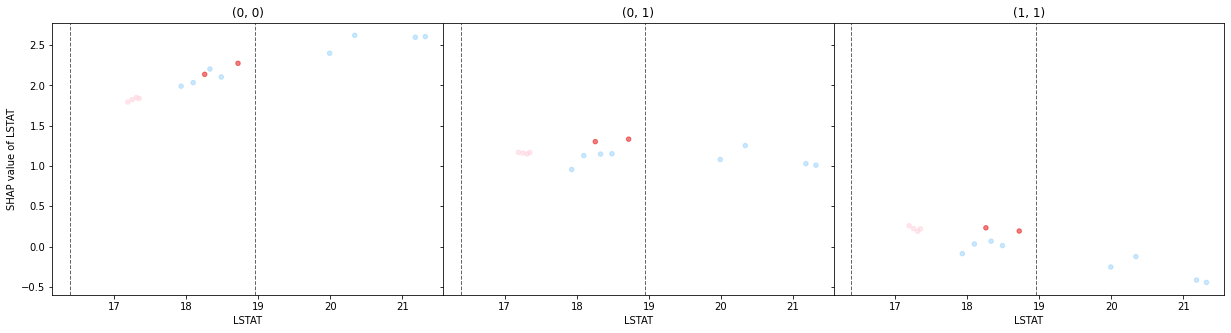

In [50]:
node.get_parent(3).plot_feature_dependence(feature, focus=node, alpha=0.5)

Equal to parent.

ZN == 0.0
[Upper CF: ZN == 6.0 --> {'(1, 1)': 2}]


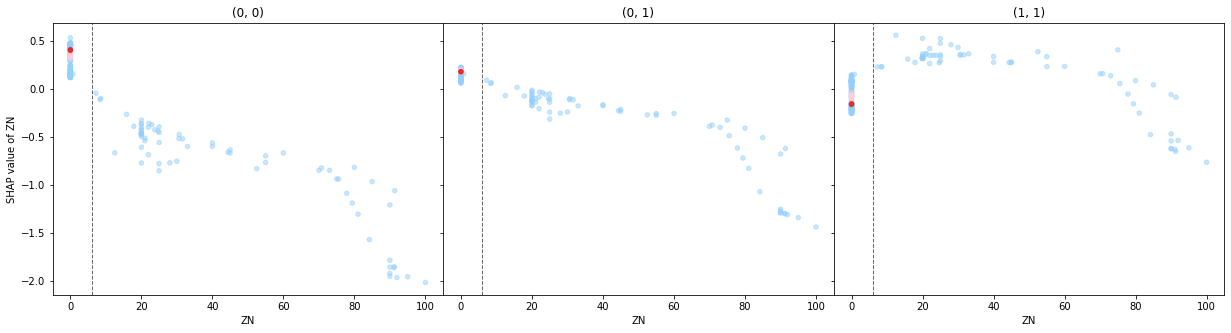

In [51]:
feature = next(feature_it)
plot(feature)

still in lower part of range, but with upper counterfactual being lower than for parent

TAX == 307.0
[Lower CF: TAX == 260.0 --> {'(0, 0)': 2},
 Upper CF: TAX == 468.0 --> {'(1, 1)': 2}]


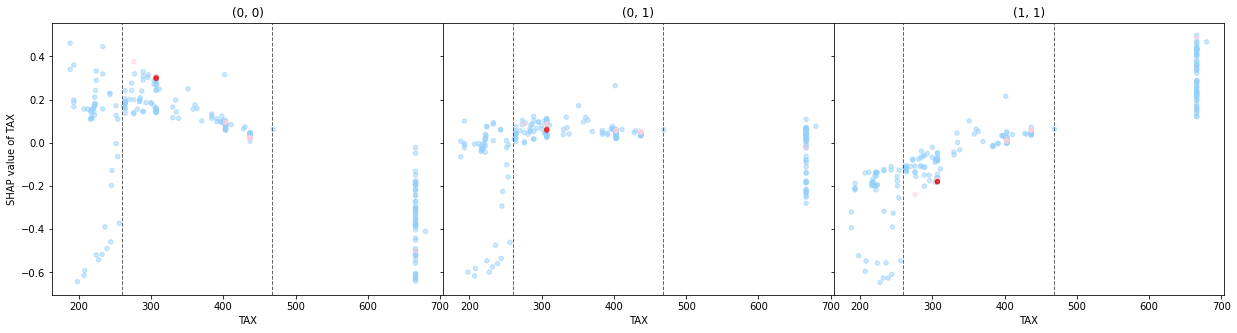

In [52]:
feature = next(feature_it)
plot(feature)

lower counterfactual is slightly higher than in parent cluster.

PTRATIO == 21.0
[Lower CF: PTRATIO == 20.07 --> {'(0, 0)': 2}]


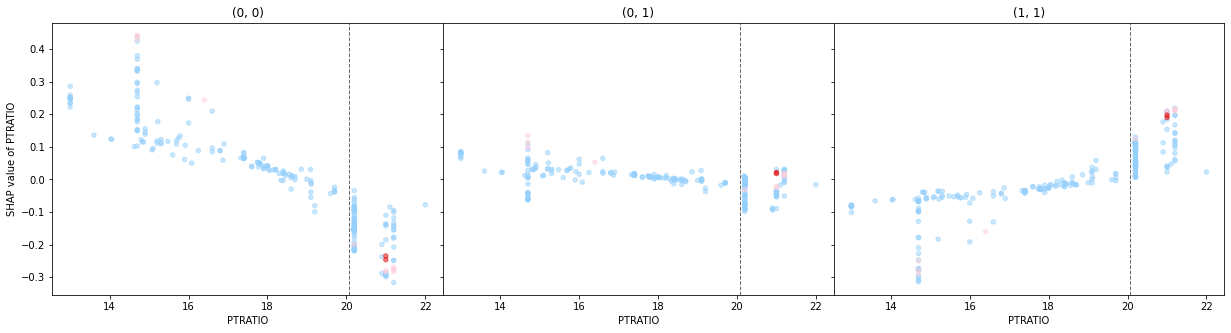

In [53]:
feature = next(feature_it)
plot(feature)

Now has a upper counterfactual, shows linear dependencies.

INDUS == 8.14
[Upper CF: INDUS == 10.64 --> {'(0, 0)': 2}]


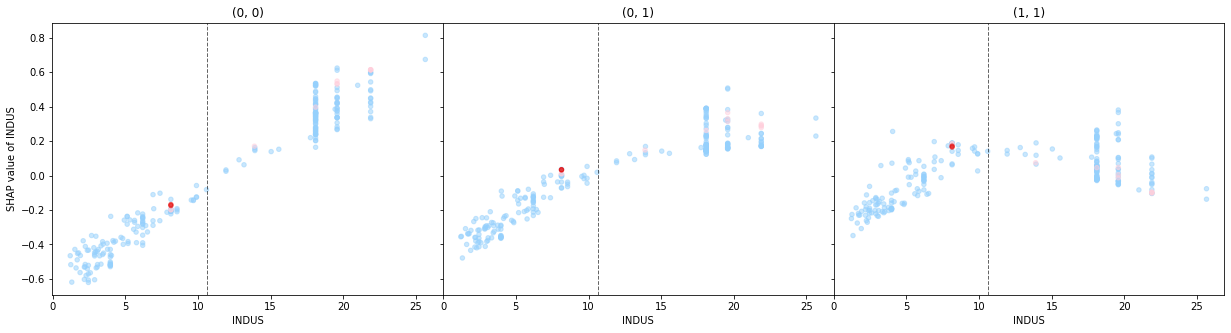

In [54]:
feature = next(feature_it)
plot(feature)

Upper CF is now lower.

1.136036787067331 <= CRIM <= 1.23247
[Upper CF: CRIM == 2.0 --> {'(0, 0)': 2}]


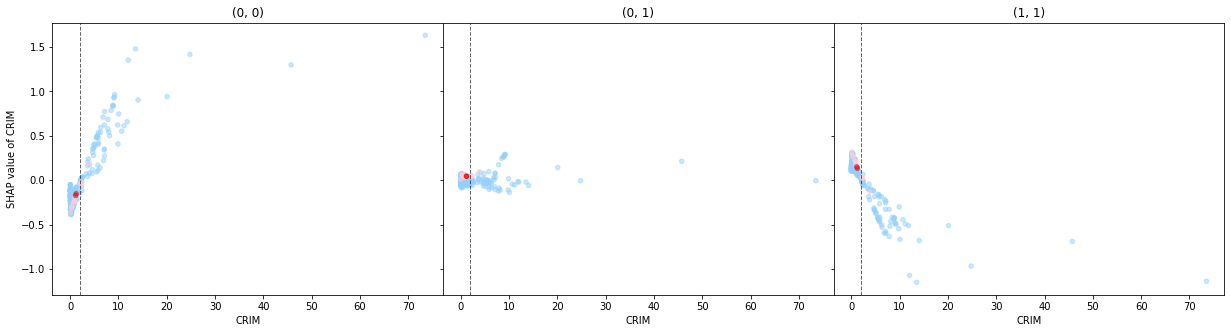

In [55]:
feature = next(feature_it)
plot(feature)

Equal to parent.

5.695859284918272 <= RM <= 6.142
[Lower CF: RM == 4.71 --> {'(0, 0)': 2}]


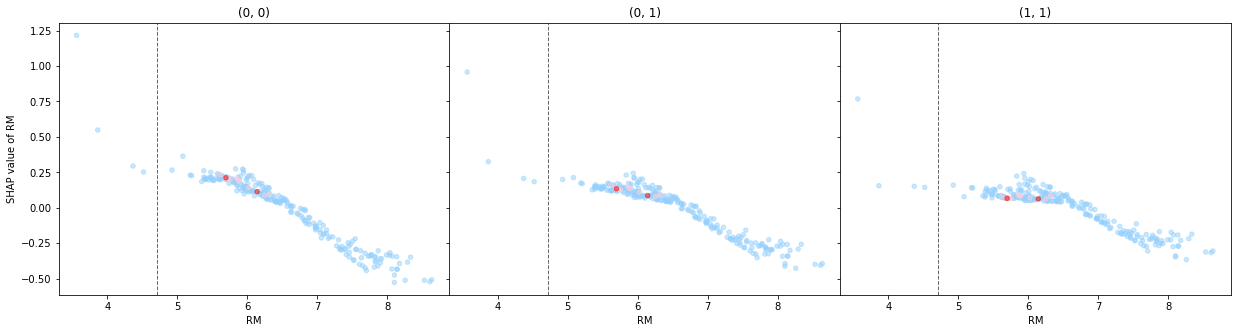

In [56]:
feature = next(feature_it)
plot(feature)

Upper Cf is lower than in parent.

RAD == 4.0
[Upper CF: RAD == 8.68 --> {'(0, 0)': 2}]


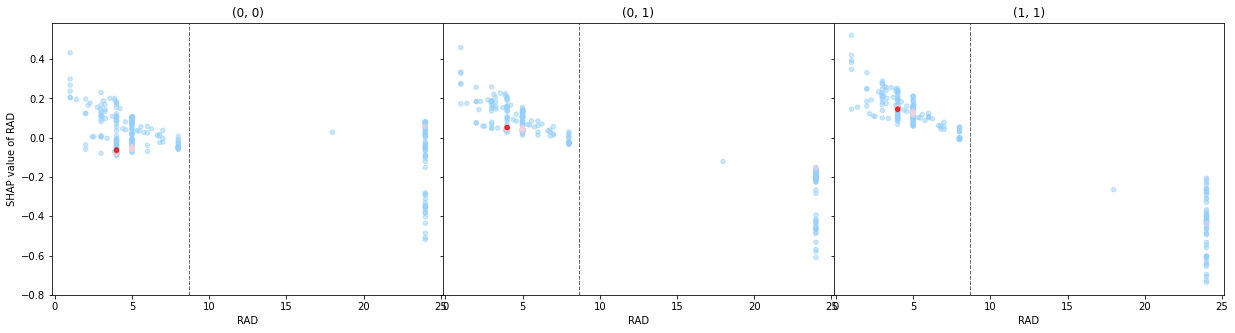

In [57]:
feature = next(feature_it)
plot(feature)

Equal to parent.

AGE == 2.0
[Lower CF: AGE == 1.0 --> {'(0, 0)': 2}]


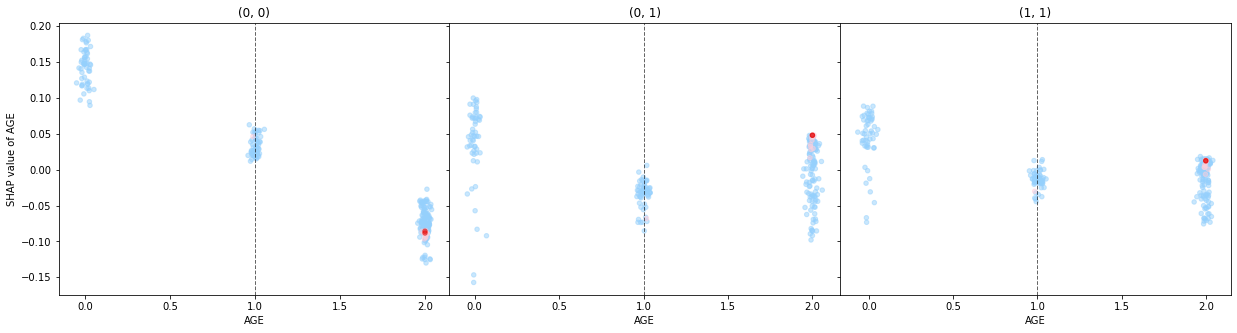

In [58]:
feature = next(feature_it)
plot(feature)

In [59]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'ZN', 'CRIM', 'AGE', 'PTRATIO', 'TAX', 'RAD', 'INDUS')
print(rule)
node.evaluate_rules(rule)

16.39 < LSTAT <= 18.94 and ZN <= 5.0 and 260.0 < TAX <= 467.0 and PTRATIO > 20.07 and INDUS <= 10.63 and CRIM <= 1.0 and RAD <= 8.67 and AGE > 1.0
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       0.0
        True       0.00      0.00      0.00       2.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



Precision  Recall  F1 Score  Support
False        0.0     0.0       0.0        0
True         0.0     0.0       0.0        2

In [60]:
explanations_l2 = [(rule, constraint, instance_indices)]

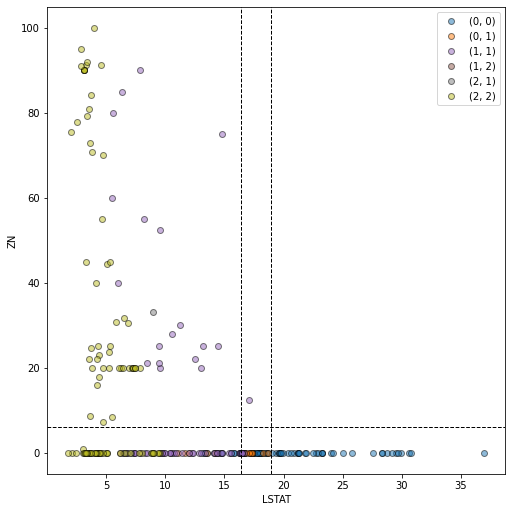

In [61]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Node 1.2 (LLRRRRRRR)

In [62]:
node = node.root.get('LLRRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LLRRRRRRR,
 (0, 1)    4
 dtype: int64,
 0.036446207974129216)

In [63]:
feature_it = iter(node.features_with_counterfactuals)

counterfactuals are more restricted than in parent.

17.19 <= LSTAT <= 17.348228318163887
[Lower CF: LSTAT == 14.9 --> {'(1, 1)': 4},
 Upper CF: LSTAT == 18.14 --> {'(0, 0)': 4}]


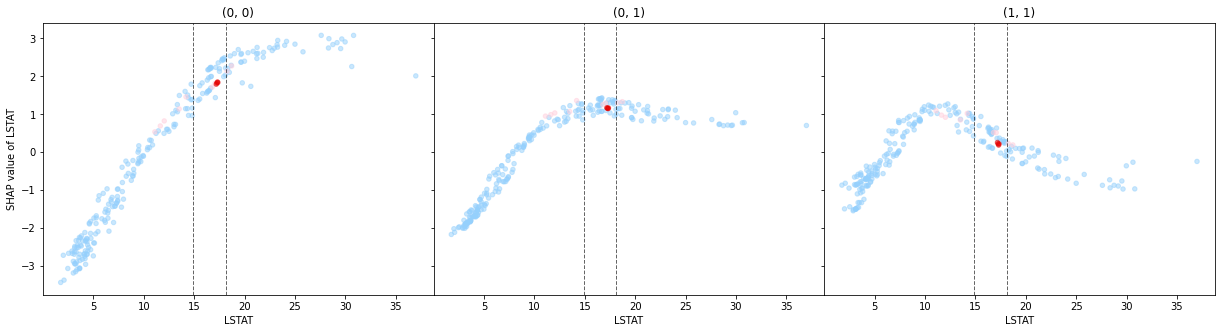

In [64]:
feature = next(feature_it)
plot(feature)

differences are upper range of parent; now adds a lower counterfactual

INDUS == 21.89
[Lower CF: INDUS == 11.88 --> {'(1, 1)': 4}]


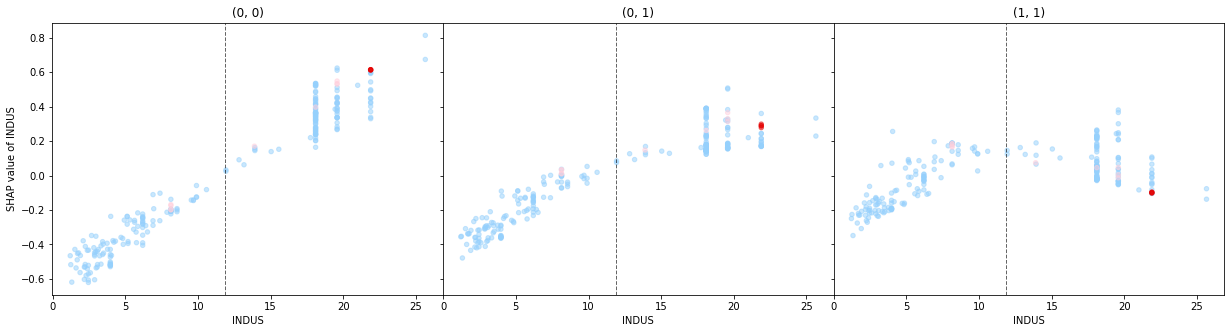

In [65]:
feature = next(feature_it)
plot(feature)

Same as parent

ZN == 0.0
[Upper CF: ZN == 6.0 --> {'(1, 1)': 4}]


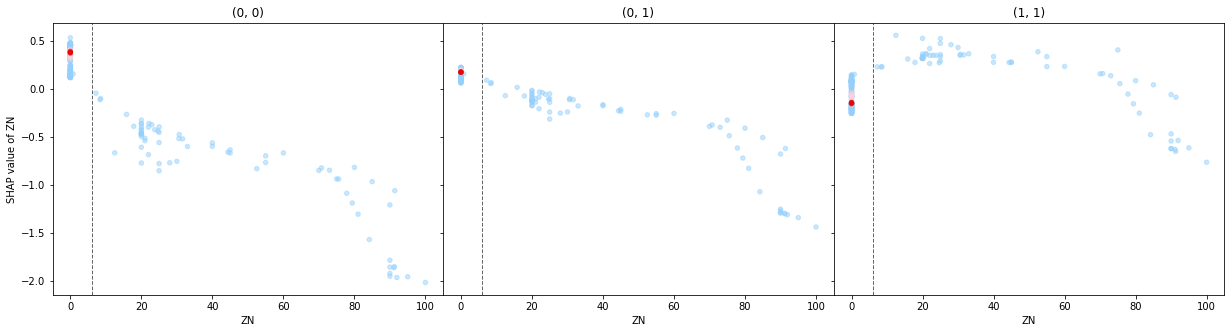

In [66]:
feature = next(feature_it)
plot(feature)

Same as parent.

0.25915 <= CRIM <= 0.97617
[Upper CF: CRIM == 2.0 --> {'(0, 0)': 4}]


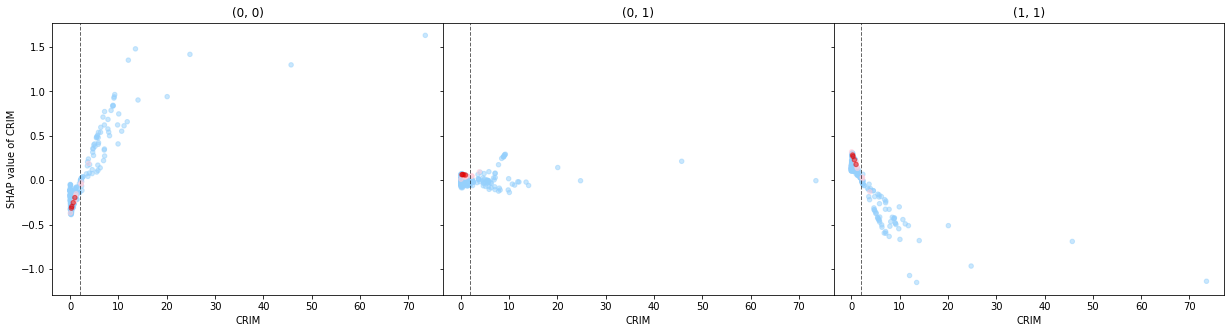

In [67]:
feature = next(feature_it)
plot(feature)

Same as parent.

PTRATIO == 21.2
[Lower CF: PTRATIO == 19.53 --> {'(0, 0)': 4}]


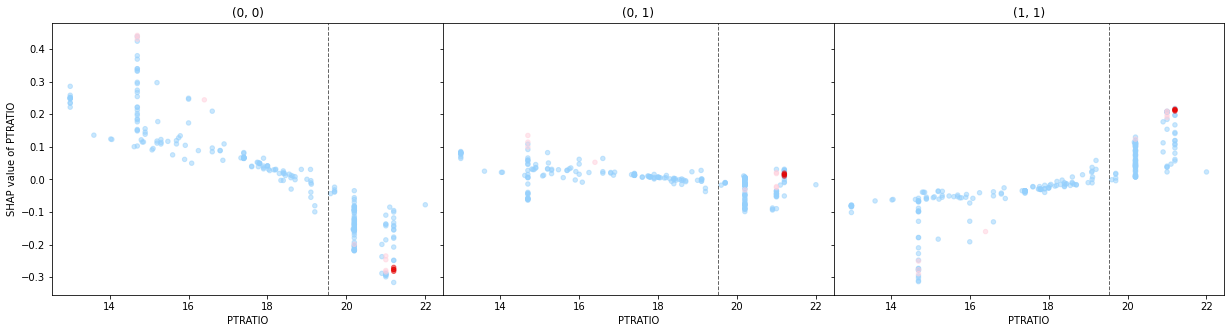

In [68]:
feature = next(feature_it)
plot(feature)

CF outside main feature value distribution.

5.685294968854628 <= RM <= 5.757
[Lower CF: RM == 3.93 --> {'(0, 0)': 4}]


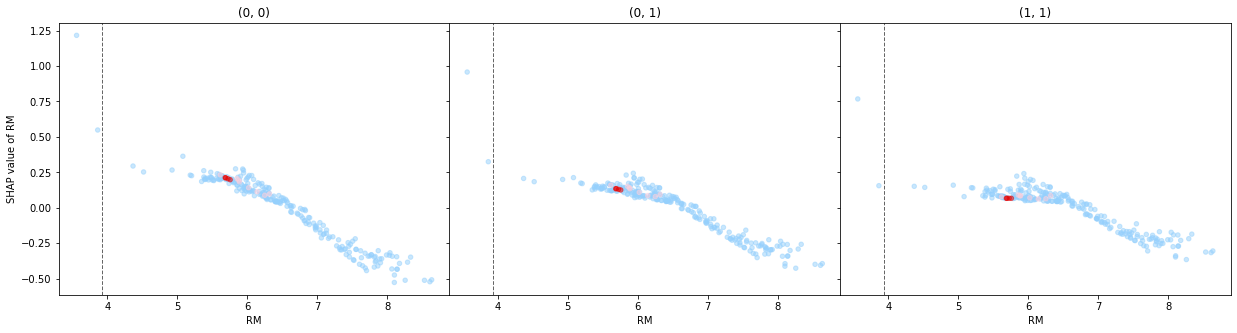

In [69]:
feature = next(feature_it)
plot(feature)

Same as parent.

RAD == 4.0
[Upper CF: RAD == 12.41 --> {'(0, 0)': 4}]


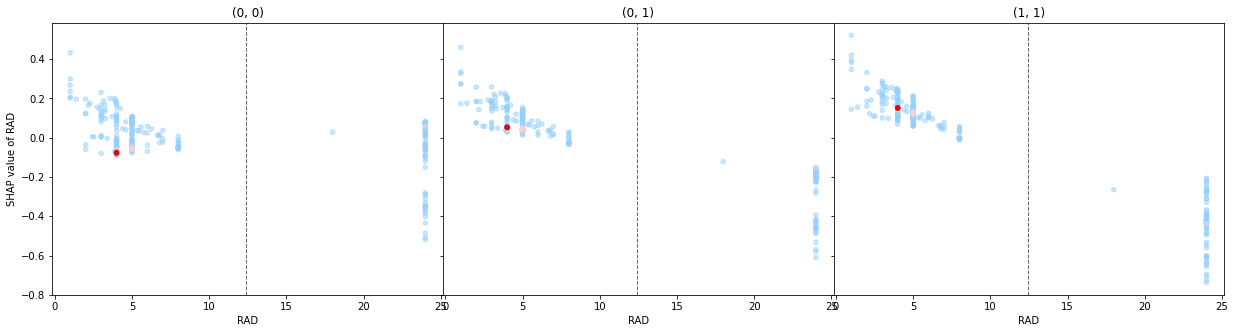

In [70]:
feature = next(feature_it)
plot(feature)

Same as parent.

AGE == 2.0
[Lower CF: AGE == 1.0 --> {'(0, 0)': 4}]


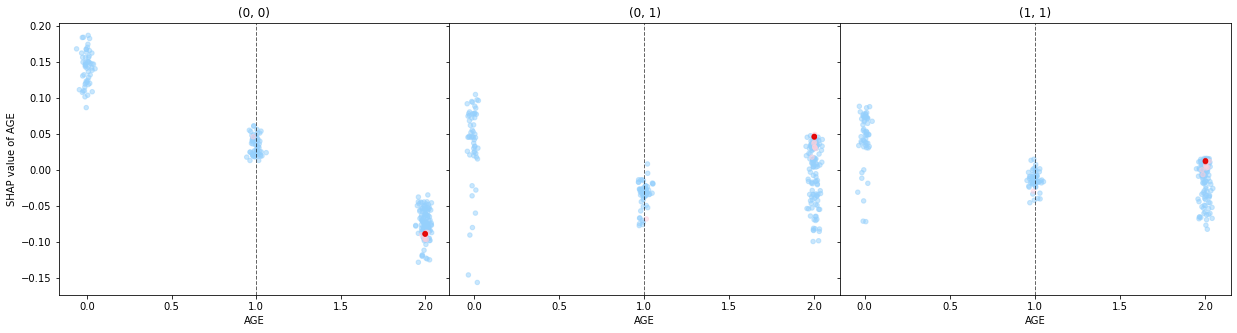

In [71]:
feature = next(feature_it)
plot(feature)

Differences in upper part of parent; lower CF is now higher

TAX == 437.0
[Lower CF: TAX == 353.0 --> {'(0, 0)': 4},
 Upper CF: TAX == 619.0 --> {'(1, 1)': 4}]


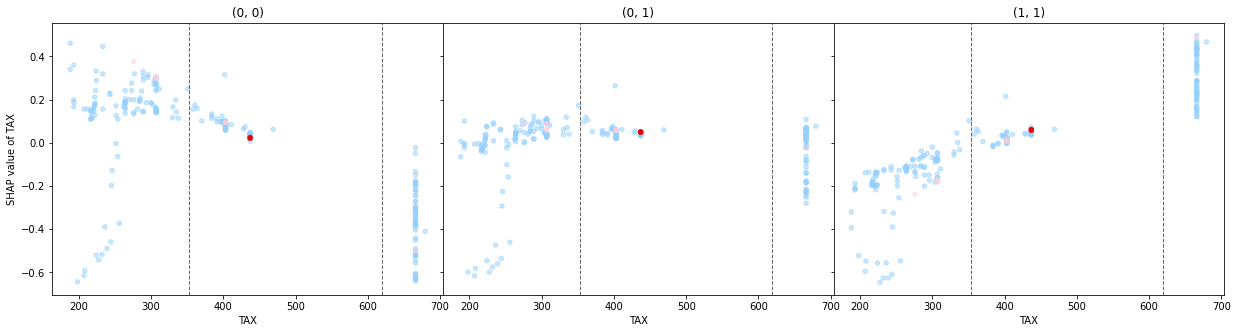

In [72]:
feature = next(feature_it)
plot(feature)

In [73]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'ZN', 'CRIM', 'AGE', 'PTRATIO', 'TAX', 'RAD', 'INDUS')
print(rule)
node.evaluate_rules(rule)

14.9 < LSTAT <= 18.13 and INDUS > 11.88 and ZN <= 5.0 and CRIM <= 1.0 and PTRATIO > 19.53 and RAD <= 12.4 and AGE > 1.0 and 353.0 < TAX <= 618.0
              precision    recall  f1-score   support

        True       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



Precision  Recall  F1 Score  Support
False        0.0     0.0       0.0        0
True         1.0     1.0       1.0        4

In [74]:
explanations_l2.append((rule, constraint, instance_indices))

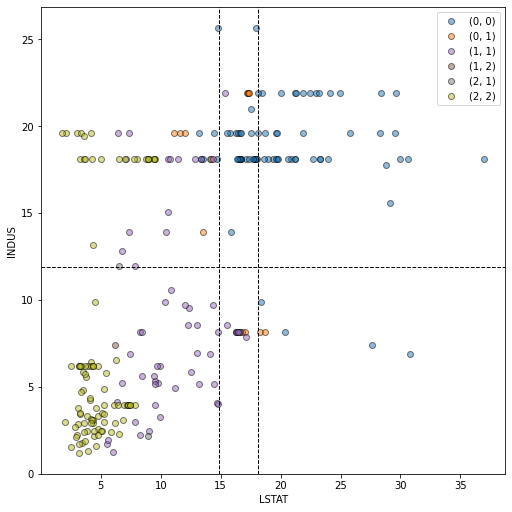

In [75]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Node 2 (LRR)

In [18]:
node = node.root.get('LR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LRR,
 (1, 1)    33
 (0, 1)     7
 (0, 0)     4
 dtype: int64,
 6.309925804736736)

The distance of this cluster is much higher than the one of the previously explained cluster. It indicates, that the cluster is more diverse in terms of its influences.

The instances classified differently are just slightly closer to $(1,1)$ than to $(0,0)$.

In [77]:
feature_it = iter(node.features_with_counterfactuals)

Same as parent.

11.1 <= LSTAT <= 17.066695066513088
[Lower CF: LSTAT == 10.24 --> {'(1, 1)': 7},
 Upper CF: LSTAT == 19.17 --> {'(0, 0)': 7}]


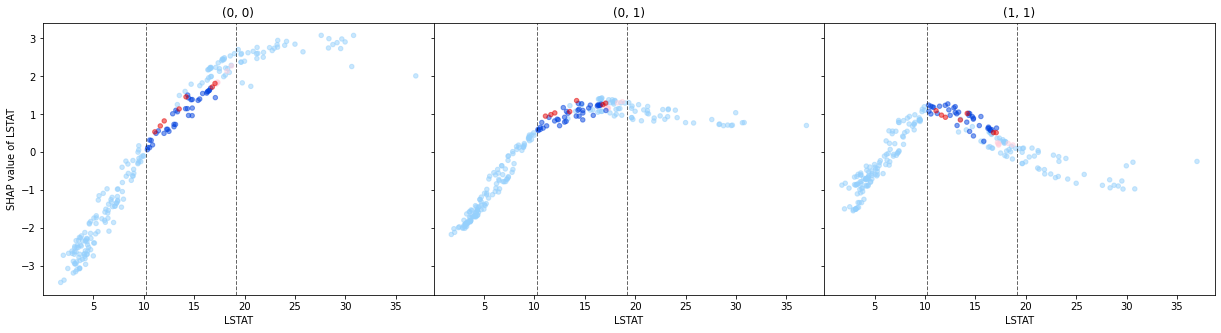

In [78]:
feature = next(feature_it)
plot(feature)

Same as parent.

ZN == 0.0
[Upper CF: ZN == 5.0 --> {'(1, 1)': 7}]


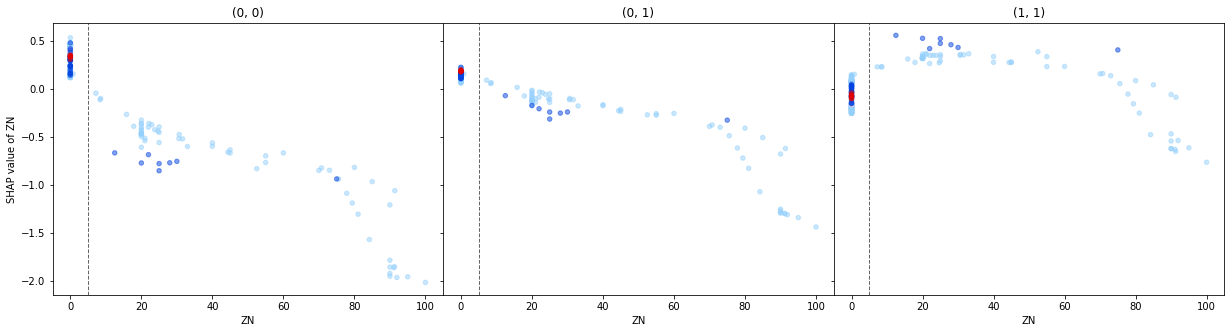

In [79]:
feature = next(feature_it)
plot(feature)

Now with lower CF, clear linear dependence curves where increasing values tend to increase the outcome of $(0,0)$ and to a lesser extent that of the difference class.

8.14 <= INDUS <= 19.58
[Lower CF: INDUS == 7.25 --> {'(1, 1)': 7}]


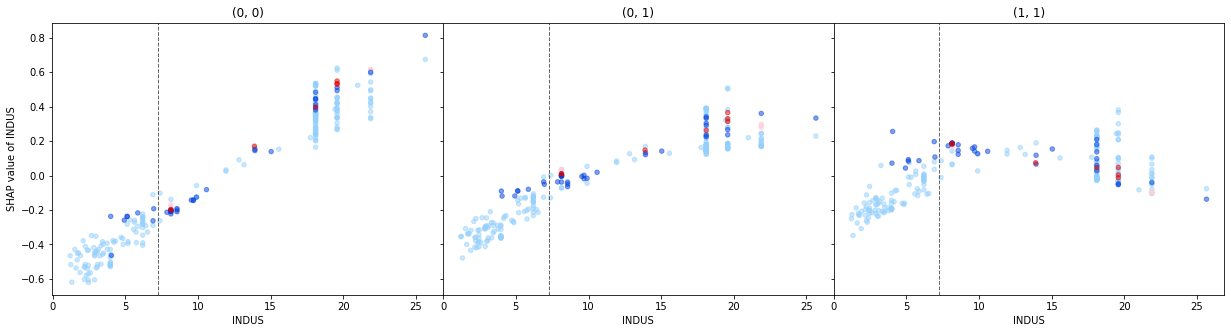

In [80]:
feature = next(feature_it)
plot(feature)

Same to parent.

0.0456 <= CRIM <= 3.83684
[Upper CF: CRIM == 7.0 --> {'(0, 0)': 7}]


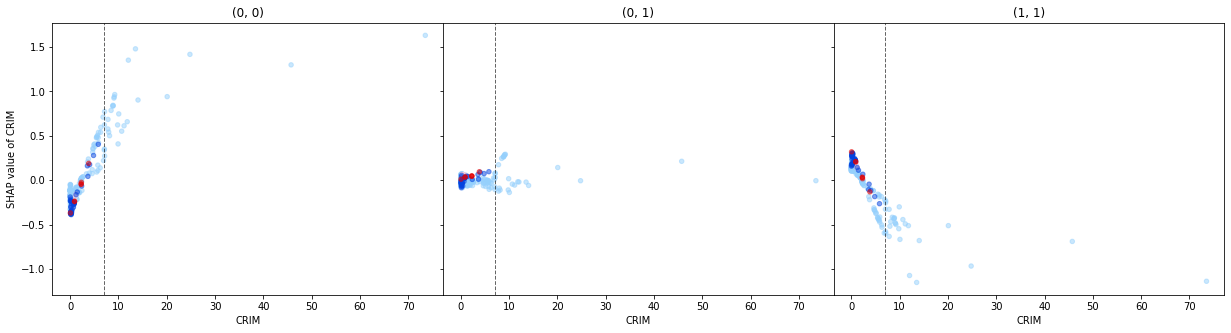

In [81]:
feature = next(feature_it)
plot(feature)

CF outside main feature value distribution.

14.7 <= PTRATIO <= 21.0
[Upper CF: PTRATIO == 21.37 --> {'(1, 1)': 7}]


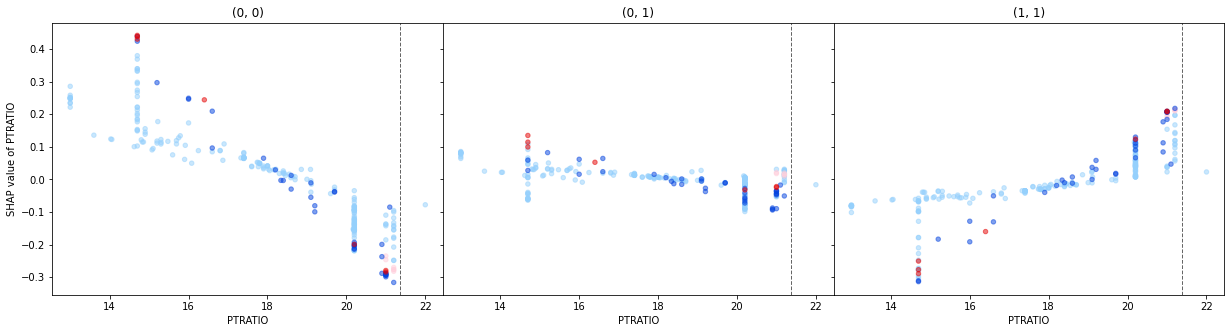

In [82]:
feature = next(feature_it)
plot(feature)

Same as parent.

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(1, 0)': 5, '(0, 0)': 2}]


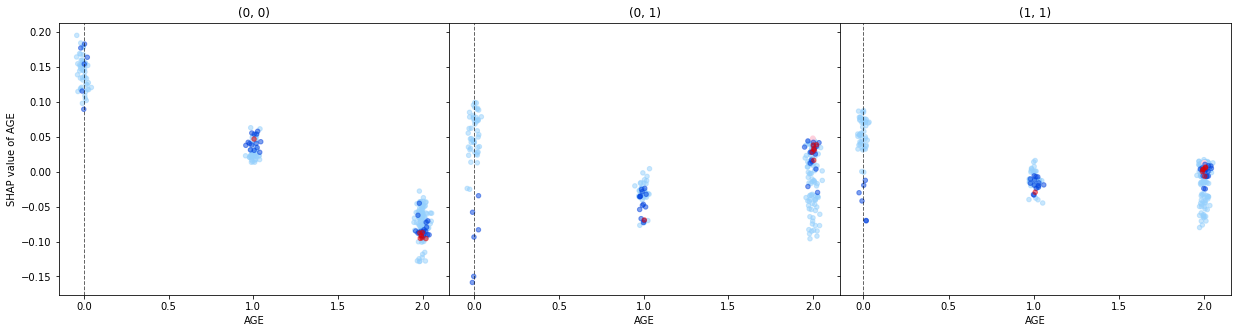

In [83]:
feature = next(feature_it)
plot(feature)

In [84]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'ZN', 'CRIM', 'AGE', 'INDUS')
print(rule)
node.evaluate_rules(rule)

10.24 < LSTAT <= 19.16 and ZN <= 4.0 and INDUS > 7.25 and CRIM <= 6.0 and AGE > 0.0
              precision    recall  f1-score   support

       False       1.00      0.35      0.52        37
        True       0.23      1.00      0.37         7

    accuracy                           0.45        44
   macro avg       0.61      0.68      0.44        44
weighted avg       0.88      0.45      0.50        44



Precision    Recall  F1 Score  Support
False   1.000000  0.351351  0.520000       37
True    0.225806  1.000000  0.368421        7

In [85]:
explanations_l1.append((rule, constraint, instance_indices))

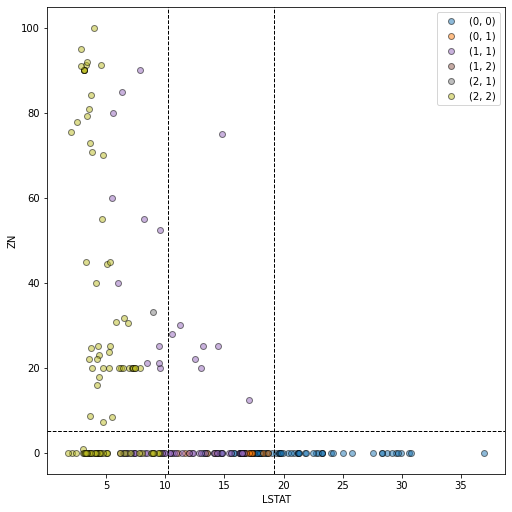

In [86]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Node 2.1 (LRRLRLL)

In [87]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LRRLRLL,
 (0, 1)    1
 dtype: int64,
 0)

Now there's only one instance classified differently left to explain.

In [88]:
feature_it = iter(node.features_with_counterfactuals)

LSTAT is in the middle of the parent cluster's range. Its counterfactuals are closer to the instance. Yet the lower counterfactual is very close, while the upper counterfactual is not so close.

LSTAT == 14.19
[Lower CF: LSTAT == 13.9 --> {'(1, 1)': 1},
 Upper CF: LSTAT == 16.13 --> {'(0, 0)': 1}]


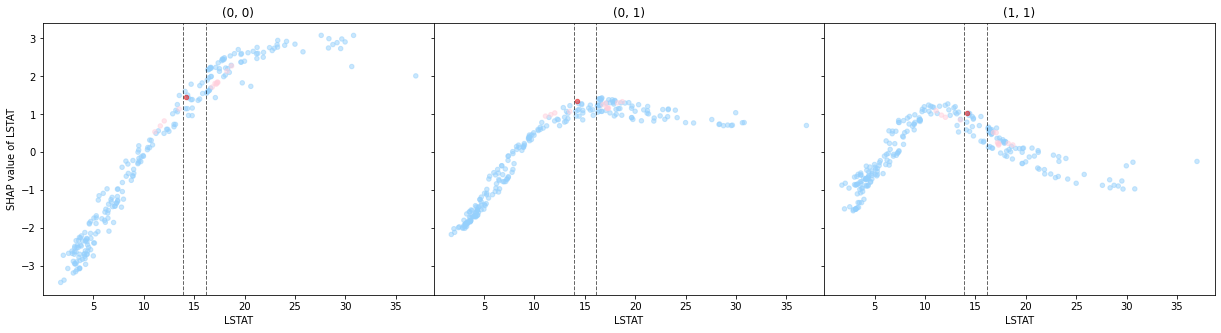

In [89]:
feature = next(feature_it)
plot(feature)

TAX is the second most important feature locally, showing that instances in this cluster have very high feature values. The lower counterfactual is very high.

TAX == 666.0
[Lower CF: TAX == 499.0 --> {'(0, 0)': 1}]


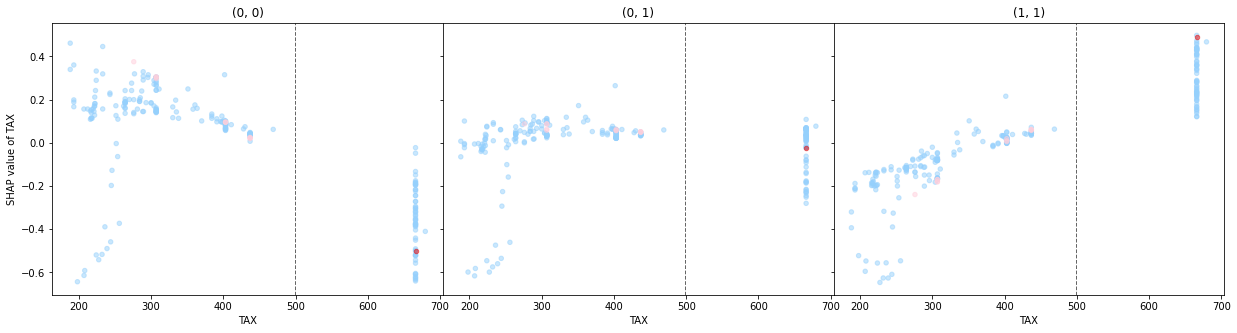

In [90]:
feature = next(feature_it)
plot(feature)

The INDUS values are high too, but there are higher values present in the parent cluster.

INDUS == 18.1
[Lower CF: INDUS == 16.87 --> {'(1, 1)': 1}]


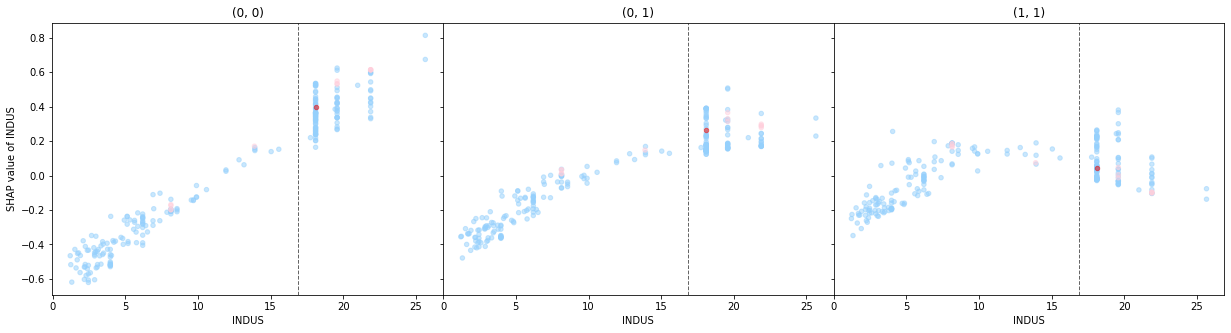

In [91]:
feature = next(feature_it)
plot(feature)

RAD is also very high for this cluster.

RAD == 24.0
[Lower CF: RAD == 21.4 --> {'(1, 1)': 1}]


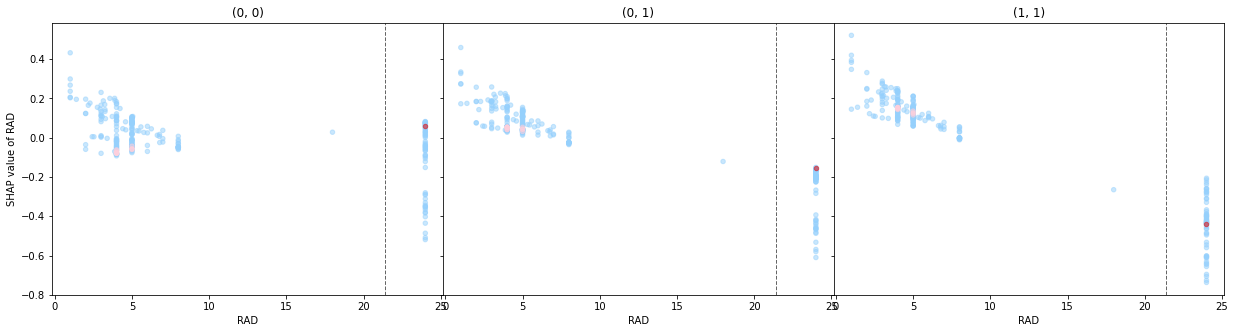

In [92]:
feature = next(feature_it)
plot(feature)

ZN is ranked lower, but has a very low upper counterfactual.

ZN == 0.0
[Upper CF: ZN == 1.0 --> {'(1, 1)': 1}]


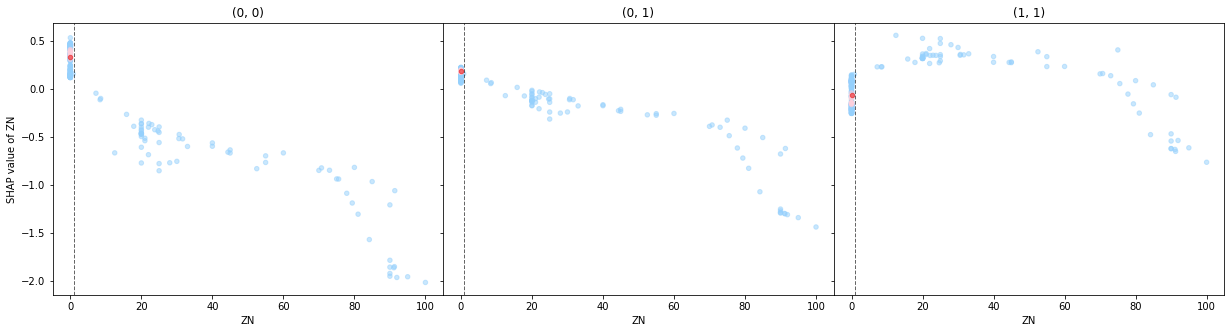

In [93]:
feature = next(feature_it)
plot(feature)

PTRATIO is in the middle range for this cluster.

PTRATIO == 20.2
[Lower CF: PTRATIO == 16.71 --> {'(0, 0)': 1},
 Upper CF: PTRATIO == 20.74 --> {'(1, 1)': 1}]


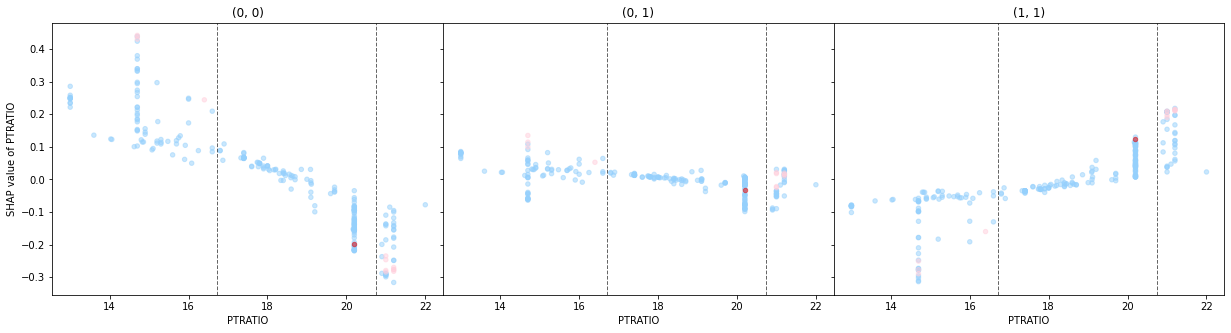

In [94]:
feature = next(feature_it)
plot(feature)

Interestingly, CRIM is now rather high and even has a lower counterfactual.

CRIM == 3.83684
[Lower CF: CRIM == 3.0 --> {'(1, 1)': 1},
 Upper CF: CRIM == 7.0 --> {'(0, 0)': 1}]


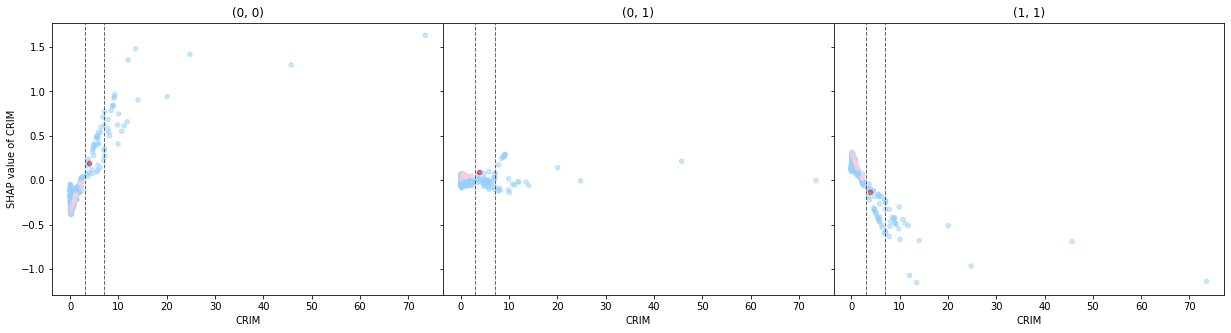

In [95]:
feature = next(feature_it)
plot(feature)

AGE lower CF is now higher

AGE == 2.0
[Lower CF: AGE == 1.0 --> {'(1, 1)': 1}]


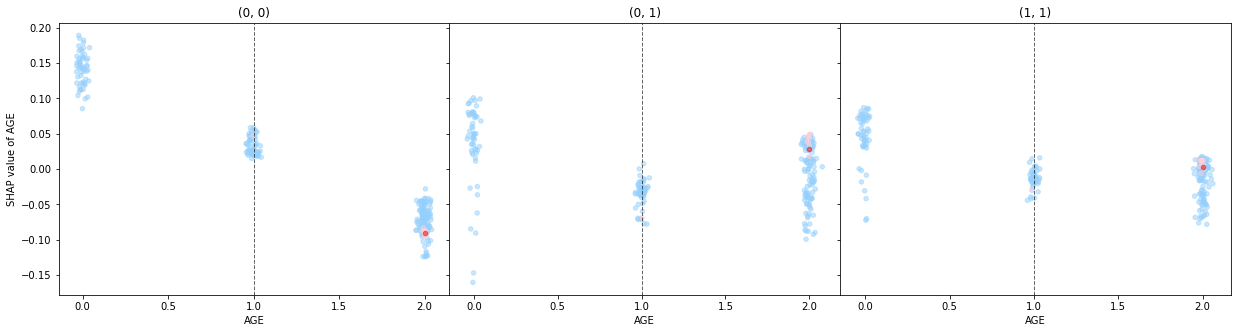

In [96]:
feature = next(feature_it)
plot(feature)

Locally, there is a linear relation of the outcome with AGE. Globally, different linear relations make up the total effect.

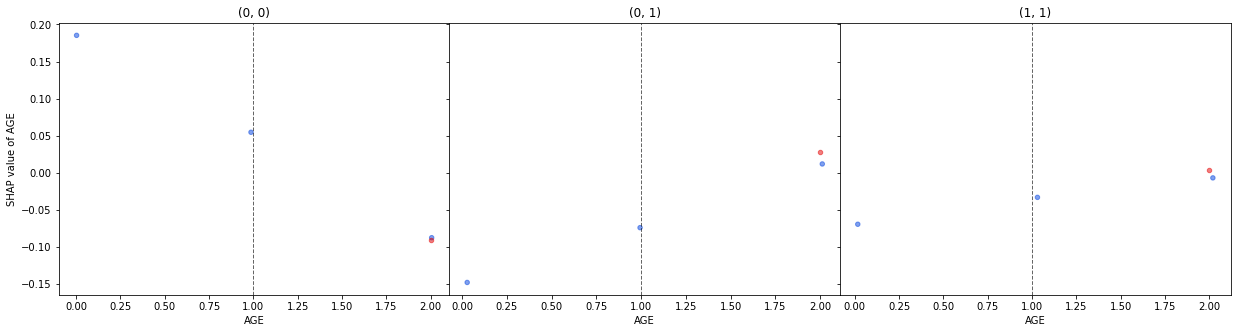

In [97]:
node.get_parent(2).plot_feature_dependence('AGE', alpha=0.5)

Stopping here, because I included already more than 3 additional features in the explanation rule, which should suffice.

In [98]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'ZN', 'CRIM', 'AGE', 'INDUS', 'TAX', 'INDUS', 'RAD', 'PTRATIO')
print(rule)
node.evaluate_rules(rule)

13.9 < LSTAT <= 16.12 and TAX > 499.0 and INDUS > 16.87 and RAD > 21.4 and ZN <= 0.0 and 16.71 < PTRATIO <= 20.73 and 3.0 < CRIM <= 6.0 and AGE > 1.0
              precision    recall  f1-score   support

        True       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



Precision  Recall  F1 Score  Support
False        0.0     0.0       0.0        0
True         1.0     1.0       1.0        1

In [99]:
explanations_l2.append((rule, constraint, instance_indices))

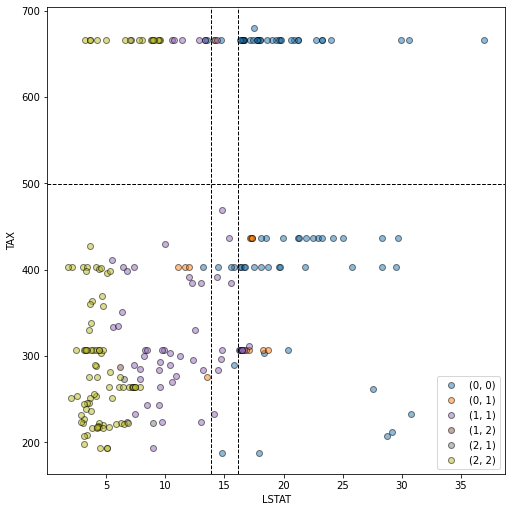

In [100]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Node 2.2 (LRRR)

In [101]:
node = node.root.get('LRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LRRR,
 (1, 1)    27
 (0, 1)     6
 (0, 0)     4
 dtype: int64,
 5.239166439717542)

In [102]:
feature_it = iter(node.features_with_counterfactuals)

similar to parent

11.1 <= LSTAT <= 17.066695066513088
[Lower CF: LSTAT == 10.24 --> {'(1, 1)': 6},
 Upper CF: LSTAT == 19.17 --> {'(0, 0)': 6}]


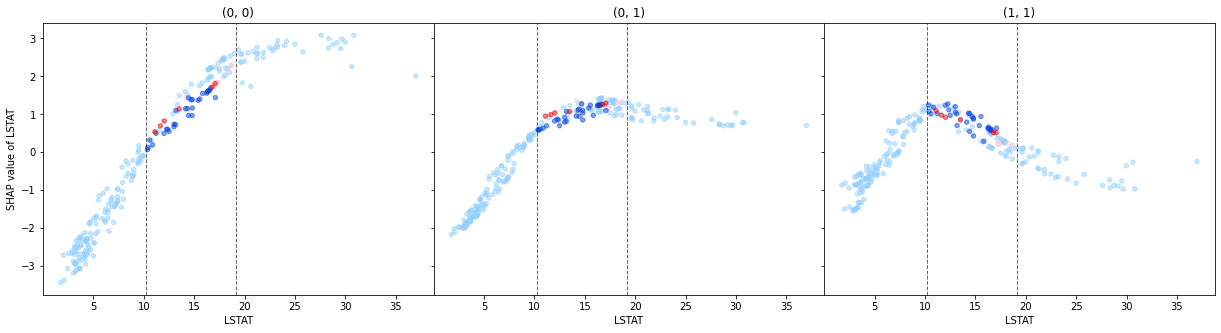

In [103]:
feature = next(feature_it)
plot(feature)

equal to parent

ZN == 0.0
[Upper CF: ZN == 5.0 --> {'(1, 1)': 6}]


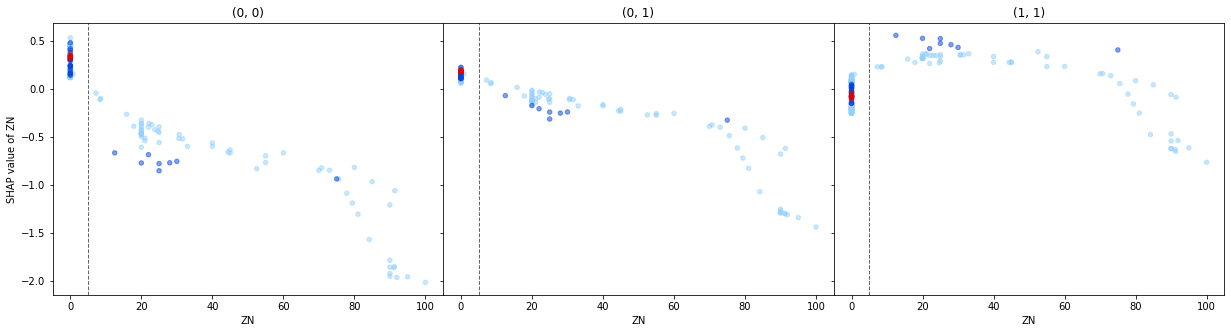

In [104]:
feature = next(feature_it)
plot(feature)

similar to parent

8.14 <= INDUS <= 19.58
[Lower CF: INDUS == 7.25 --> {'(1, 1)': 6}]


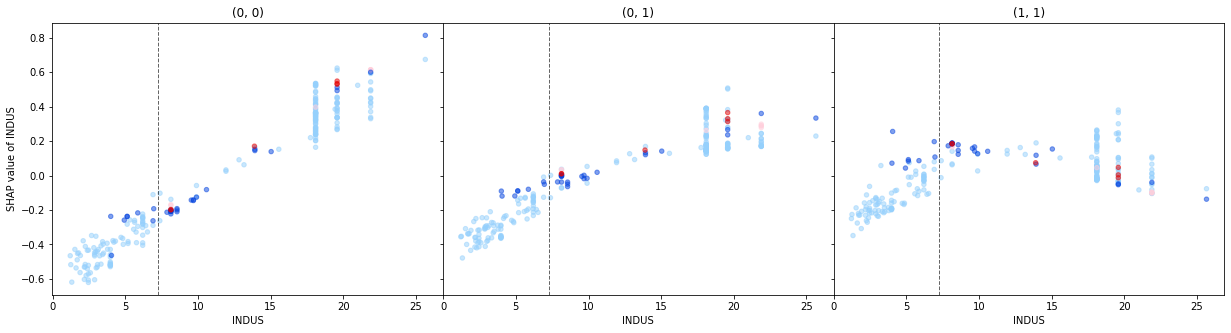

In [105]:
feature = next(feature_it)
plot(feature)

upper cf is lower than in parent

0.0456 <= CRIM <= 2.3139
[Upper CF: CRIM == 5.0 --> {'(0, 0)': 6}]


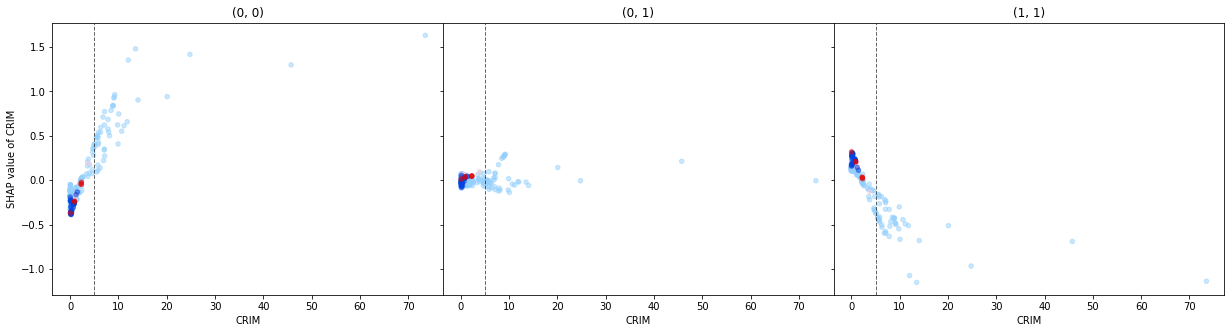

In [106]:
feature = next(feature_it)
plot(feature)

CF outside main distribution of feature values

14.7 <= PTRATIO <= 21.0
[Upper CF: PTRATIO == 21.37 --> {'(1, 1)': 6}]


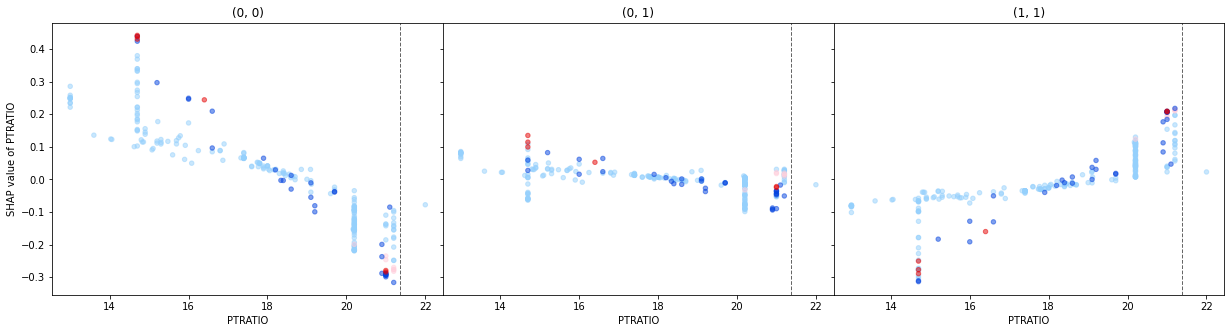

In [107]:
feature = next(feature_it)
plot(feature)

new upper cf

276.0 <= TAX <= 403.0
[Upper CF: TAX == 542.0 --> {'(1, 1)': 6}]


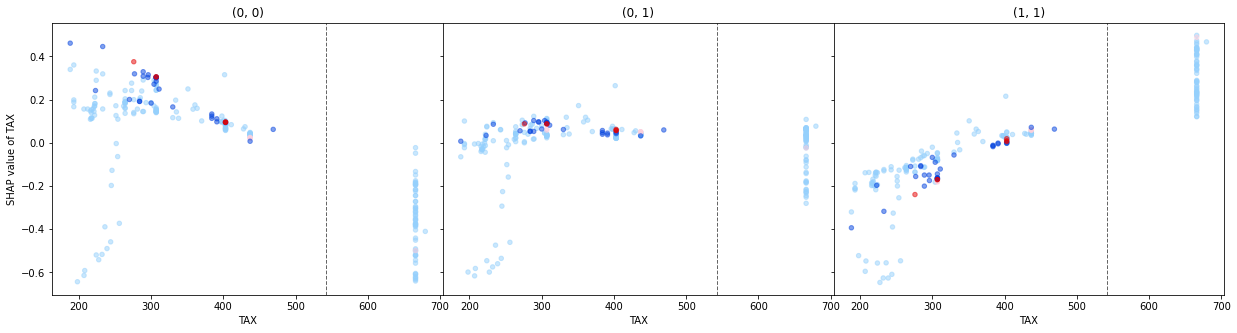

In [108]:
feature = next(feature_it)
plot(feature)

new upper cf

4.0 <= RAD <= 5.0
[Upper CF: RAD == 23.91 --> {'(0, 0)': 6}]


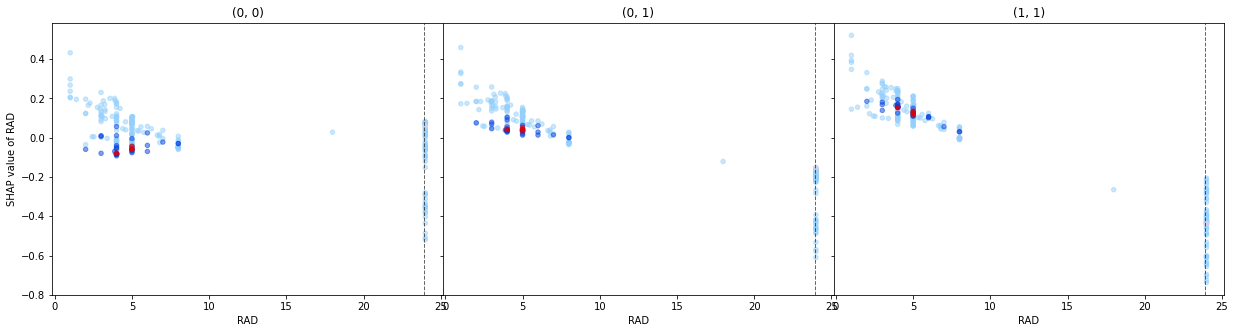

In [109]:
feature = next(feature_it)
plot(feature)

same as parent

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(1, 0)': 4, '(0, 0)': 2}]


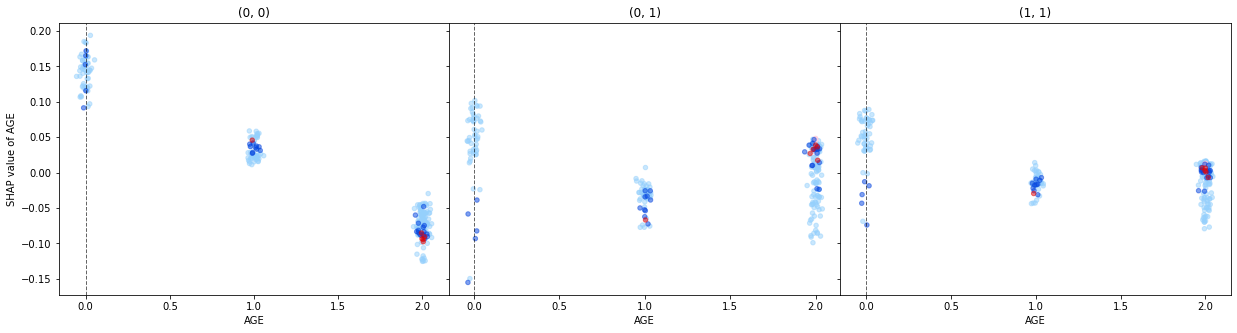

In [110]:
feature = next(feature_it)
plot(feature)

In [111]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'ZN', 'CRIM', 'AGE', 'INDUS', 'TAX', 'RAD')
print(rule)
node.evaluate_rules(rule)

10.24 < LSTAT <= 19.16 and ZN <= 4.0 and INDUS > 7.25 and CRIM <= 4.0 and TAX <= 541.0 and RAD <= 23.9 and AGE > 0.0
              precision    recall  f1-score   support

       False       1.00      0.39      0.56        31
        True       0.24      1.00      0.39         6

    accuracy                           0.49        37
   macro avg       0.62      0.69      0.47        37
weighted avg       0.88      0.49      0.53        37



Precision    Recall  F1 Score  Support
False       1.00  0.387097  0.558140       31
True        0.24  1.000000  0.387097        6

In [112]:
explanations_l2.append((rule, constraint, instance_indices))

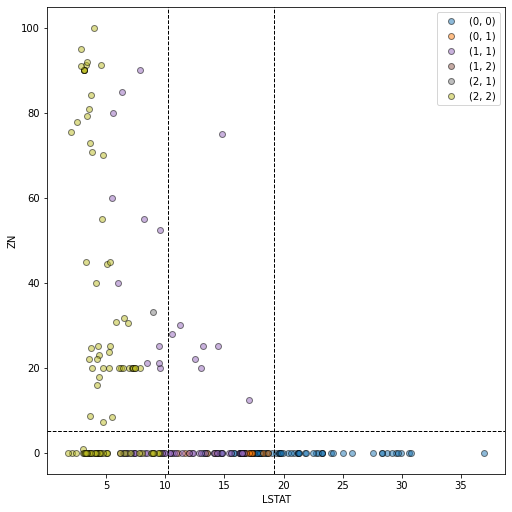

In [113]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Node 2.2.1 (LRRRLR)

In [114]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LRRRLR,
 (1, 1)    11
 (0, 1)     3
 (0, 0)     1
 dtype: int64,
 1.3659596012574418)

In [115]:
feature_it = iter(node.features_with_counterfactuals)

still covers a broad range of SHAP values for instances classified differently. Counterfactuals for the higher values and the lower values might be closer to the instances.

13.51 <= LSTAT <= 17.066695066513088
[Lower CF: LSTAT == 13.14 --> {'(1, 1)': 3},
 Upper CF: LSTAT == 19.17 --> {'(0, 0)': 3}]


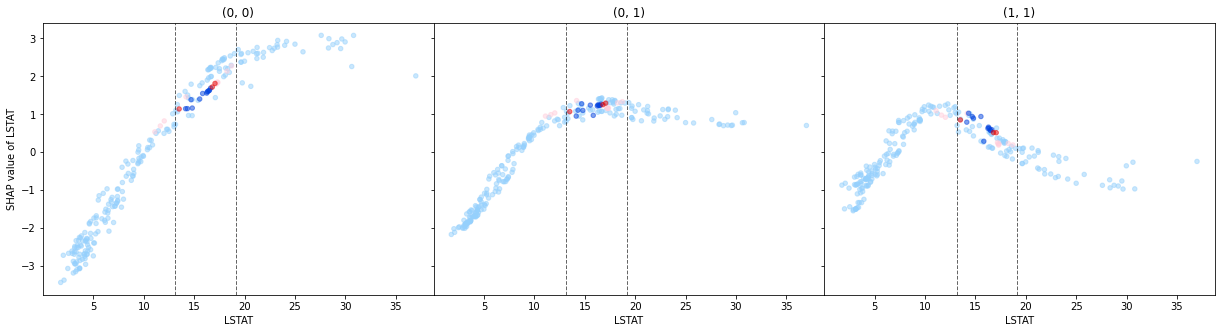

In [116]:
feature = next(feature_it)
plot(feature)

Addionally, since I suspect that the differences in LSTAT are of a local nature and change easily if its value is increased or decreased, I check the two children of the node.

LSTAT == 13.51
[Lower CF: LSTAT == 13.14 --> {'(1, 1)': 1},
 Upper CF: LSTAT == 14.1 --> {'(0, 0)': 1}]


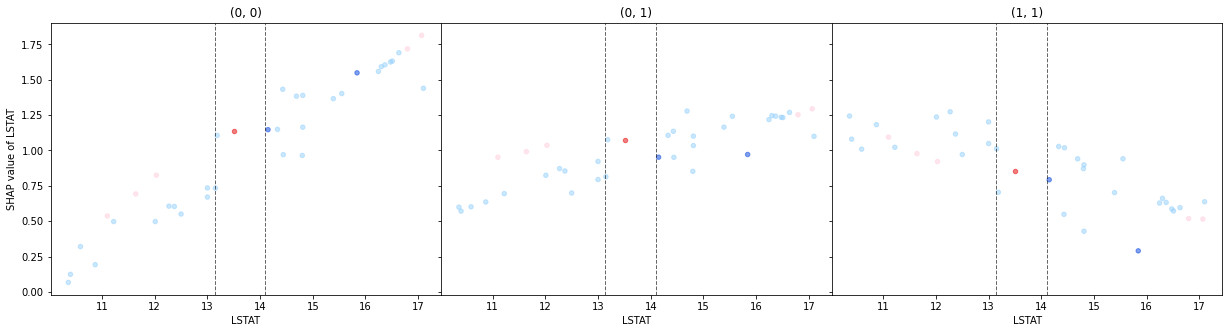

In [117]:
child = node.get_left()
child.describe_feature_differences('LSTAT')
pprint(child.counterfactuals['LSTAT'])
node.parent.parent.plot_feature_dependence('LSTAT', focus=child, alpha=0.5)

16.79698376047181 <= LSTAT <= 17.066695066513088
[Lower CF: LSTAT == 16.63 --> {'(1, 1)': 2},
 Upper CF: LSTAT == 19.17 --> {'(0, 0)': 2}]


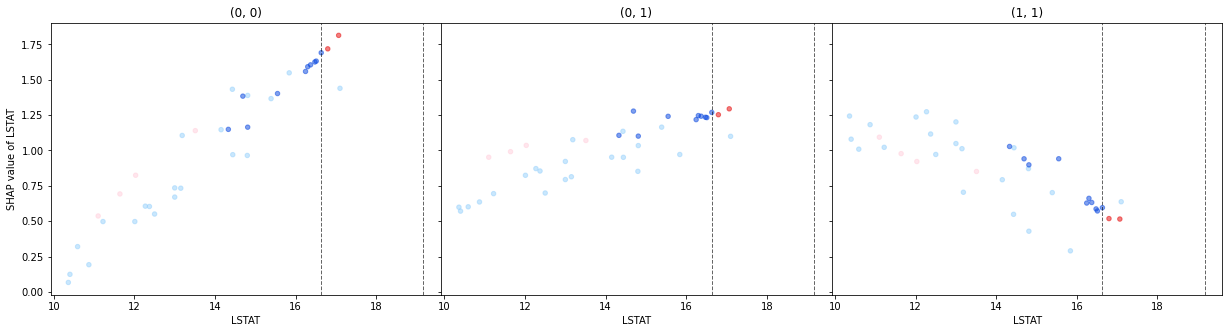

In [118]:
child = node.get_right()
child.describe_feature_differences('LSTAT')
pprint(child.counterfactuals['LSTAT'])
node.parent.parent.plot_feature_dependence('LSTAT', focus=child, alpha=0.5)

This confirms the theory, that LSTAT differences are local and flip easily when LSTAT is increased or decreased a bit.

upper cf is lower

0.0456 <= CRIM <= 0.9110390848154124
[Upper CF: CRIM == 4.0 --> {'(0, 0)': 3}]


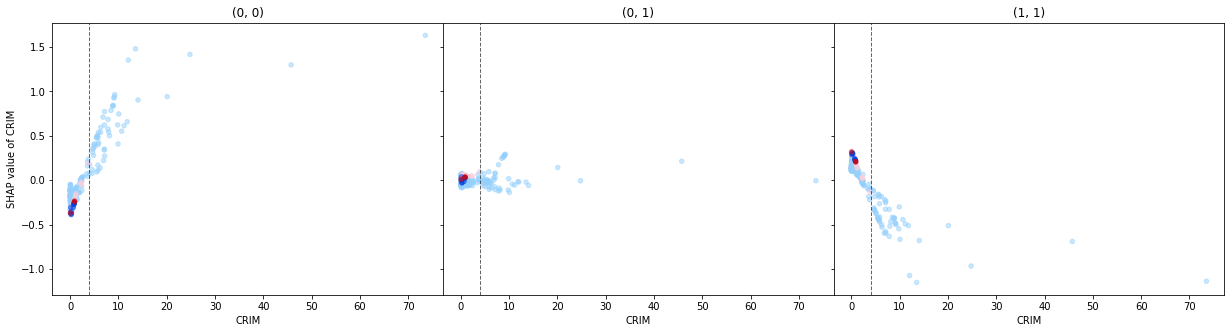

In [119]:
feature = next(feature_it)
plot(feature)

upper cf is lower

ZN == 0.0
[Upper CF: ZN == 1.0 --> {'(1, 1)': 3}]


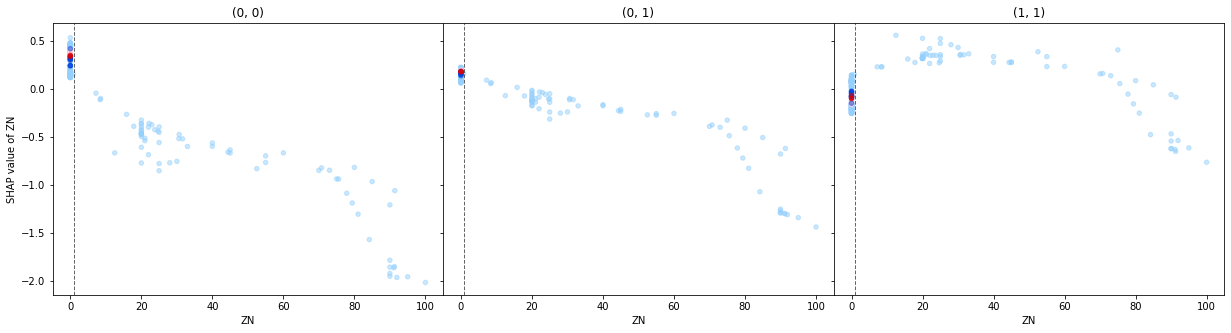

In [120]:
feature = next(feature_it)
plot(feature)

upper cf is lower

276.0 <= TAX <= 307.0
[Upper CF: TAX == 324.0 --> {'(1, 1)': 3}]


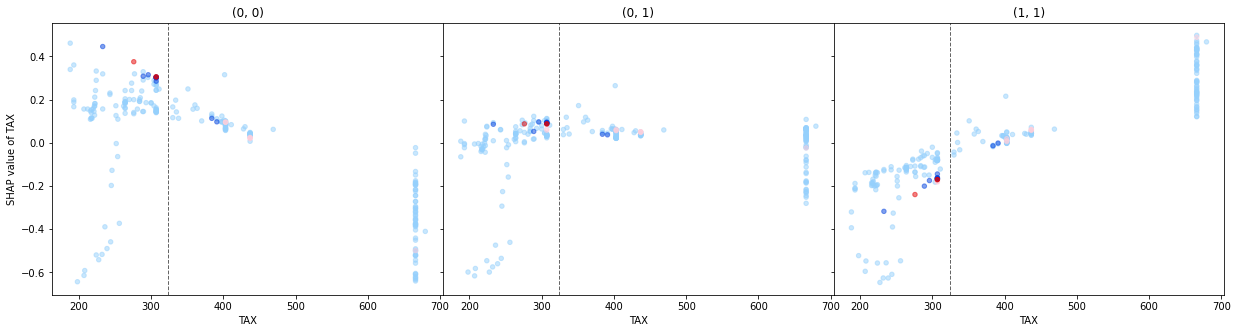

In [121]:
feature = next(feature_it)
plot(feature)

new upper CF

8.14 <= INDUS <= 13.89
[Lower CF: INDUS == 7.25 --> {'(1, 1)': 3},
 Upper CF: INDUS == 18.44 --> {'(0, 0)': 3}]


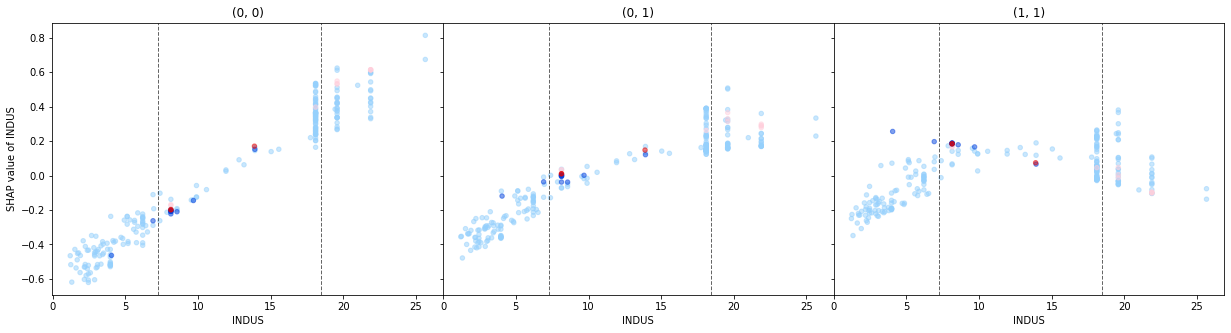

In [122]:
feature = next(feature_it)
plot(feature)

CFs on the very edges of the feature values, not using this feature

16.4 <= PTRATIO <= 21.0
[Lower CF: PTRATIO == 15.36 --> {'(0, 0)': 3},
 Upper CF: PTRATIO == 21.37 --> {'(1, 1)': 3}]


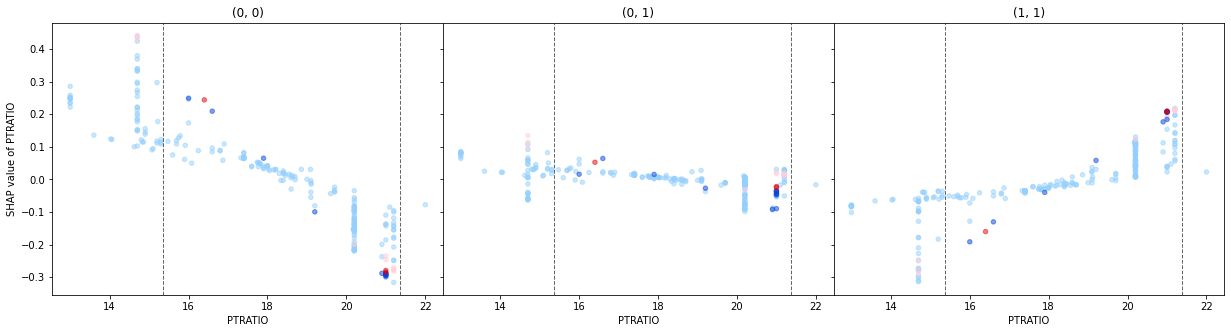

In [123]:
feature = next(feature_it)
plot(feature)

5.614908882373981 <= RM <= 6.020228054266438
[Upper CF: RM == 6.52 --> {'(1, 1)': 3}]


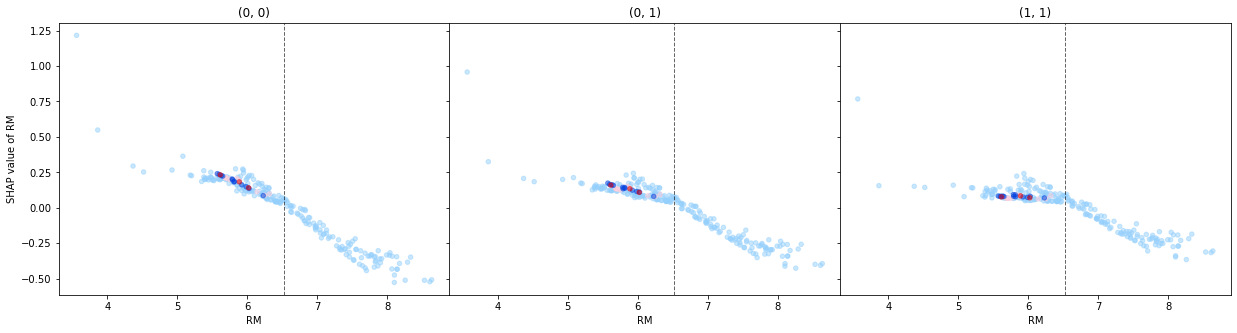

In [124]:
feature = next(feature_it)
plot(feature)

4.0 <= RAD <= 5.0
[Lower CF: RAD == 2.03 --> {'(1, 1)': 3},
 Upper CF: RAD == 22.86 --> {'(0, 0)': 3}]


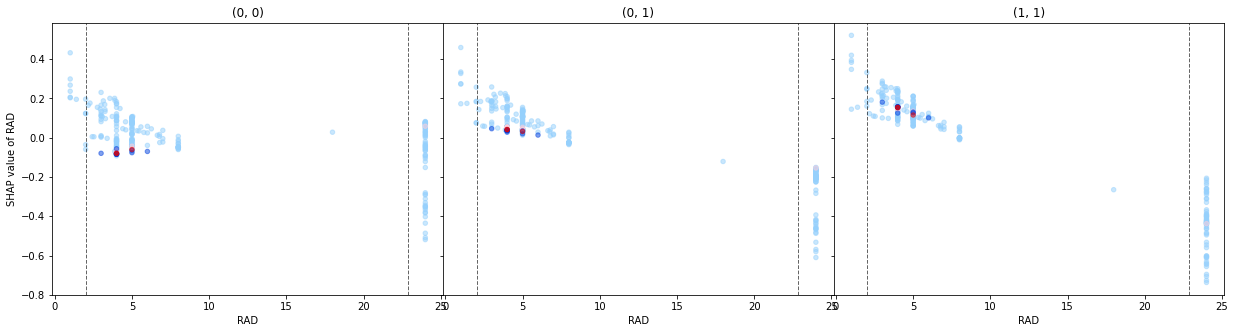

In [125]:
feature = next(feature_it)
plot(feature)

same as parent

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(1, 0)': 3}]


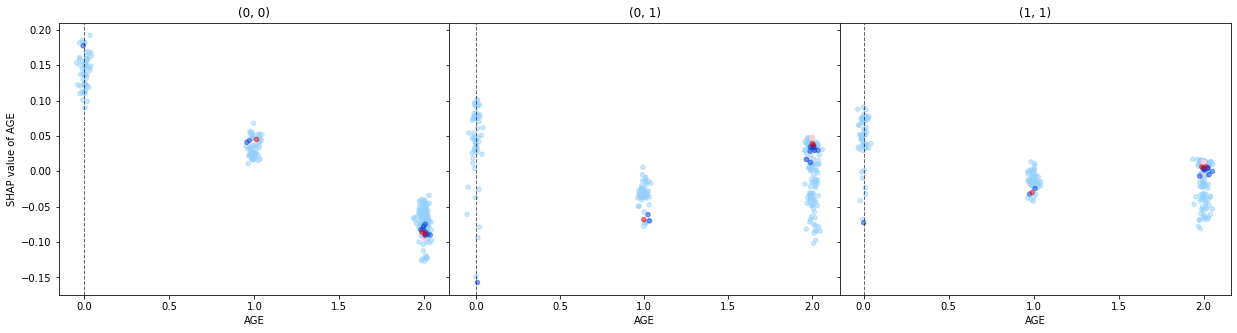

In [126]:
feature = next(feature_it)
plot(feature)

3.1121 <= DIS <= 4.44168999446776
[Upper CF: DIS == 5.83 --> {'(1, 1)': 3}]


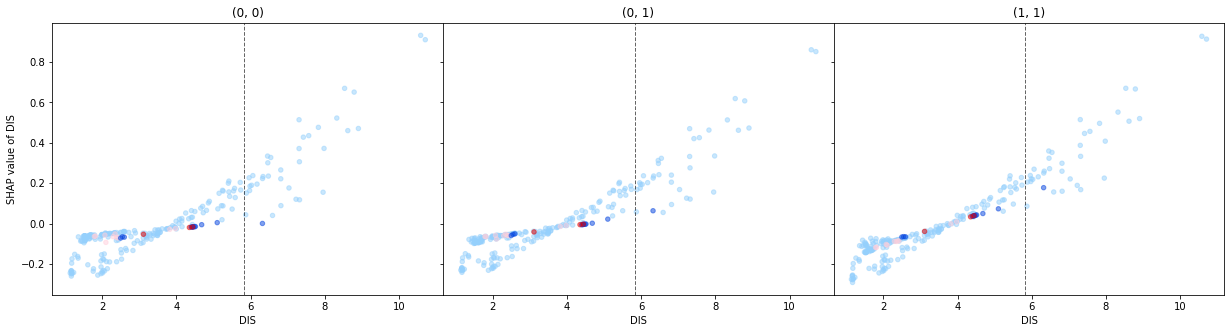

In [127]:
feature = next(feature_it)
plot(feature)

In [128]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'ZN', 'CRIM', 'AGE', 'INDUS', 'TAX', 'RAD', 'RM', 'DIS')
print(rule)
node.evaluate_rules(rule)

13.14 < LSTAT <= 19.16 and CRIM <= 3.0 and ZN <= 0.0 and TAX <= 323.0 and 7.25 < INDUS <= 18.43 and RM <= 6.51 and 2.03 < RAD <= 22.85 and AGE > 0.0 and DIS <= 5.82
              precision    recall  f1-score   support

       False       1.00      0.42      0.59        12
        True       0.30      1.00      0.46         3

    accuracy                           0.53        15
   macro avg       0.65      0.71      0.52        15
weighted avg       0.86      0.53      0.56        15



Precision    Recall  F1 Score  Support
False        1.0  0.416667  0.588235       12
True         0.3  1.000000  0.461538        3

In [129]:
explanations_l3 = explanations_l2[:-1] + [(rule, constraint, instance_indices)]

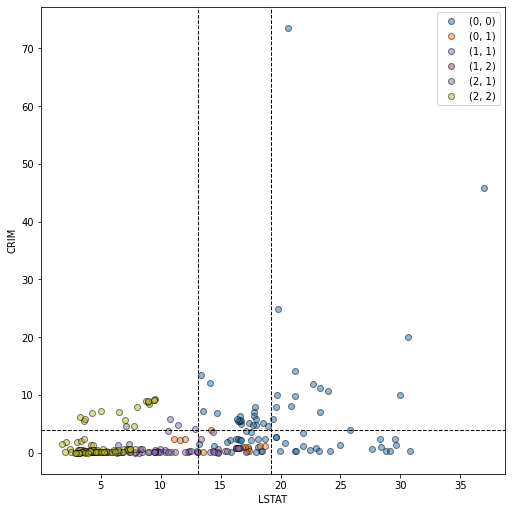

In [130]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Node 2.2.2 (LRRRRLL)

In [131]:
node = node.root.get('LRRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LRRRRLL,
 (0, 1)    3
 dtype: int64,
 0.14714275651087264)

In [132]:
feature_it = iter(node.features_with_counterfactuals)

differences are in lower part of parent's range

11.1 <= LSTAT <= 12.03
[Lower CF: LSTAT == 10.24 --> {'(1, 1)': 3},
 Upper CF: LSTAT == 13.14 --> {'(0, 0)': 3}]


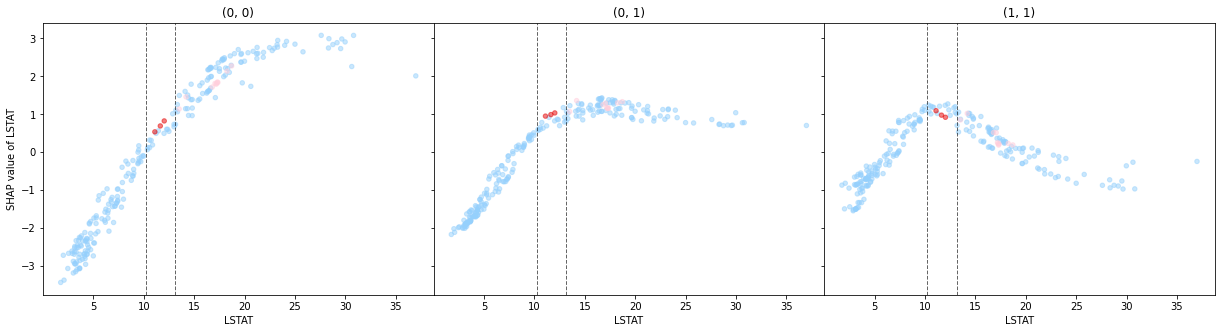

In [133]:
plot(next(feature_it))

differences are in upper part of parent's range

INDUS == 19.58
[Lower CF: INDUS == 12.03 --> {'(1, 1)': 3}]


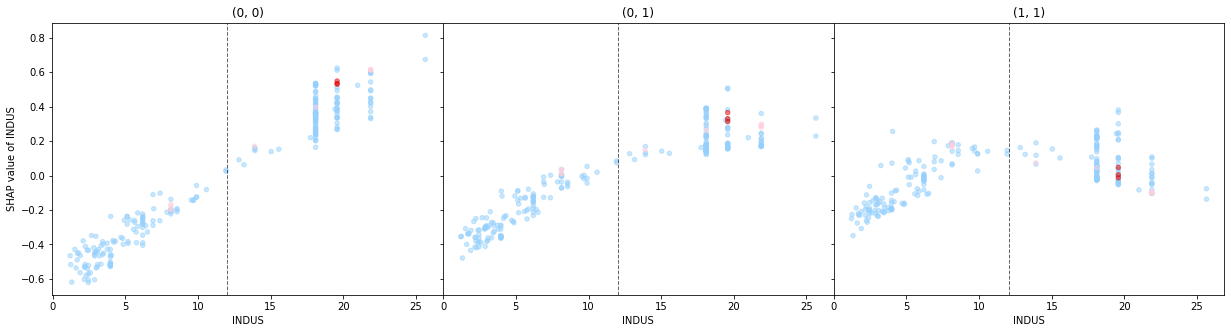

In [134]:
plot(next(feature_it))

dependence curve is steeper than for other clusters; differences are in lower part

PTRATIO == 14.7
[Upper CF: PTRATIO == 17.93 --> {'(1, 1)': 3}]


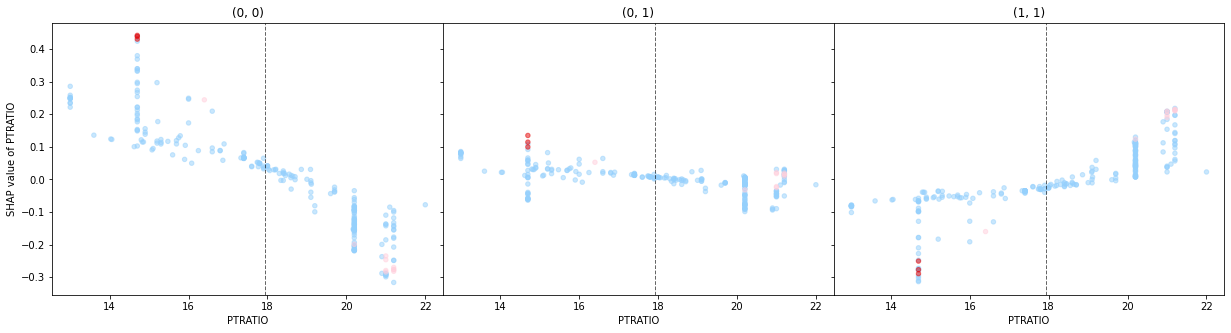

In [135]:
plot(next(feature_it))

Same as parent

ZN == 0.0
[Upper CF: ZN == 5.0 --> {'(1, 1)': 3}]


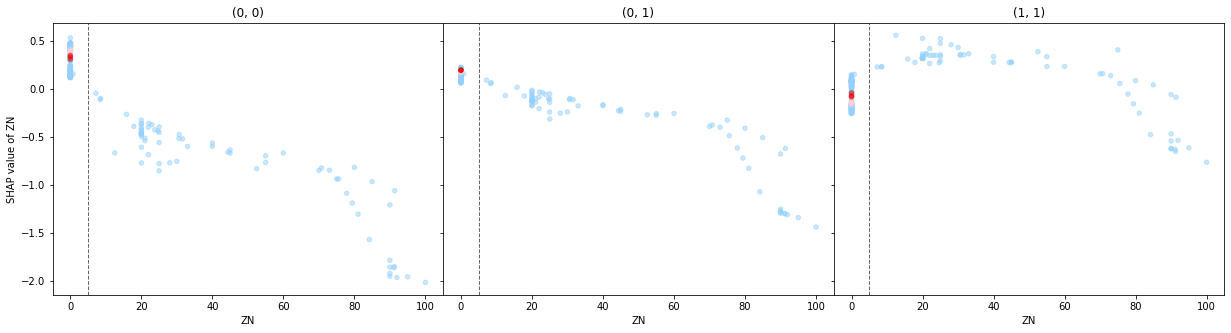

In [136]:
plot(next(feature_it))

same as parent

RAD == 5.0
[Upper CF: RAD == 23.91 --> {'(0, 0)': 3}]


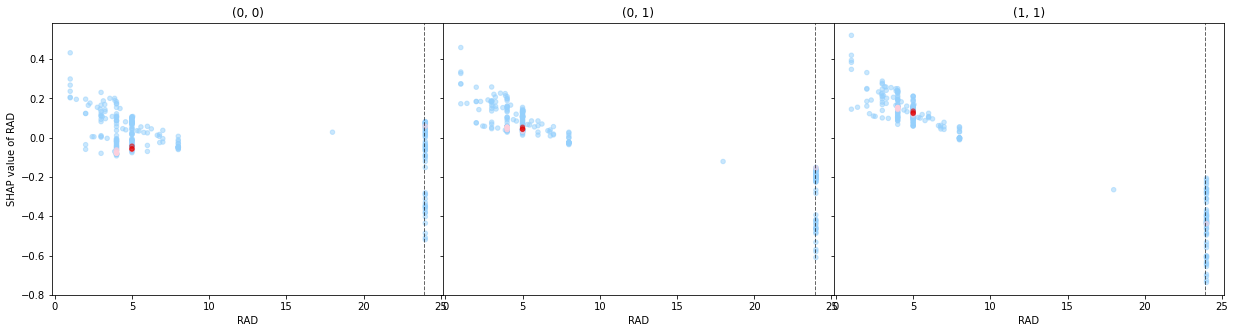

In [137]:
plot(next(feature_it))

same as parent

AGE == 2.0
[Lower CF: AGE == 0.0 --> {'(0, 0)': 2, '(1, 0)': 1}]


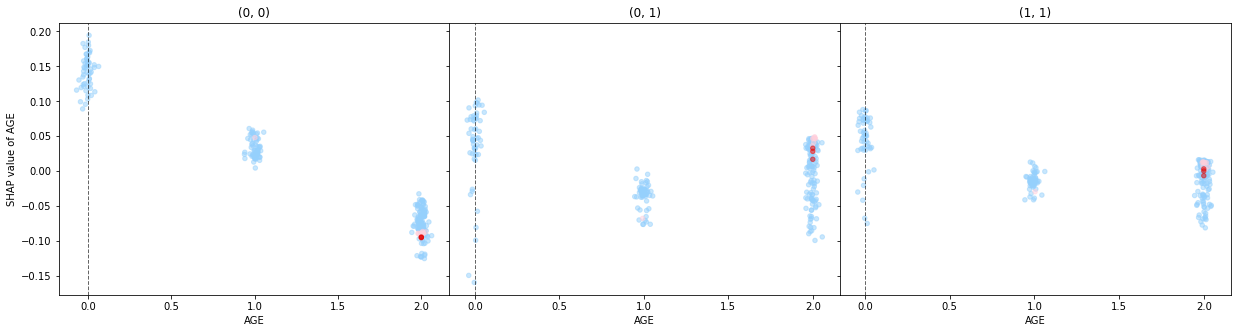

In [138]:
plot(next(feature_it))

now has a lower cf as well

TAX == 403.0
[Lower CF: TAX == 222.0 --> {'(0, 0)': 3},
 Upper CF: TAX == 542.0 --> {'(1, 1)': 3}]


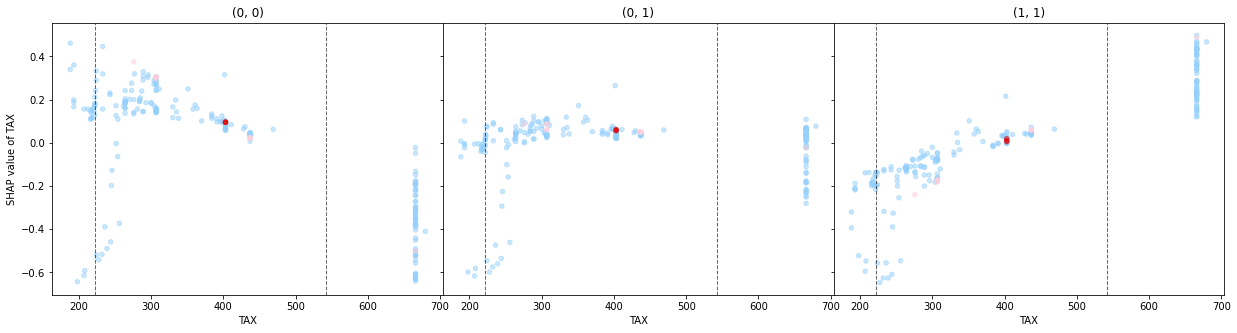

In [139]:
plot(next(feature_it))

2.24236 <= CRIM <= 2.3139
[Lower CF: CRIM == 0.0 --> {'(1, 1)': 3},
 Upper CF: CRIM == 5.0 --> {'(0, 0)': 3}]


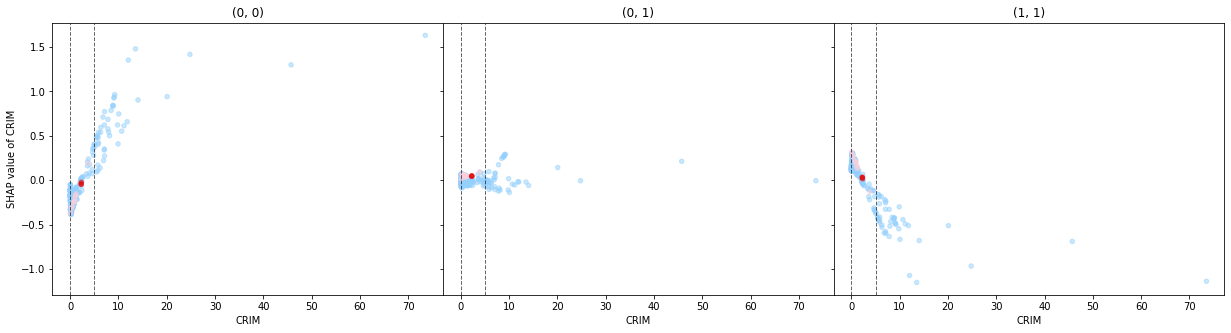

In [140]:
plot(next(feature_it))

In [141]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'ZN', 'CRIM', 'AGE', 'INDUS', 'TAX', 'RAD', 'PTRATIO')
print(rule)
node.evaluate_rules(rule)

10.24 < LSTAT <= 13.13 and INDUS > 12.03 and PTRATIO <= 17.92 and ZN <= 4.0 and RAD <= 23.9 and AGE > 0.0 and 222.0 < TAX <= 541.0 and 0.0 < CRIM <= 4.0
              precision    recall  f1-score   support

        True       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



Precision  Recall  F1 Score  Support
False        0.0     0.0       0.0        0
True         1.0     1.0       1.0        3

In [142]:
explanations_l3.append((rule, constraint, instance_indices))

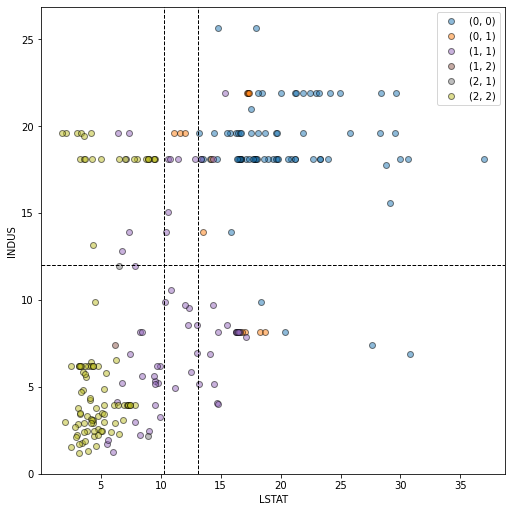

In [143]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Evaluation

#### Global

In [144]:
level = 0
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [145]:
print_rules(rules)
global_fidelities[(level, node.diff_class)] = node.root.evaluate_rules(*rules)

1. 10.24 < LSTAT <= 19.16 and ZN <= 5.0 and CRIM <= 6.0 and AGE > 0.0
              precision    recall  f1-score   support

       False       1.00      0.78      0.87       233
        True       0.20      1.00      0.33        13

    accuracy                           0.79       246
   macro avg       0.60      0.89      0.60       246
weighted avg       0.96      0.79      0.85       246



In [147]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
local_fidelities[(level, node.diff_class)] = statistics
statistics

invalid value encountered in true_divide
invalid value encountered in true_divide


RMSE       BMR  BAR
CRIM     4.169486  0.315789  0.0
ZN       3.088440  0.000000  0.0
INDUS         NaN  1.000000  NaN
NOX           NaN       NaN  NaN
RM            NaN  1.000000  NaN
AGE      0.919866  0.000000  0.0
DIS           NaN  1.000000  NaN
RAD           NaN  1.000000  NaN
TAX           NaN  1.000000  NaN
PTRATIO       NaN  1.000000  NaN
LSTAT    4.104498  0.000000  0.0

In [148]:
res = get_complexity(constraints)
complexities[(level, node.diff_class)] = res
res

Rules          1
Constraints    5
dtype: int64

#### Level 1

In [149]:
level = 1
rules, constraints, instance_indices_per_rule = zip(*explanations_l1)

In [150]:
print_rules(rules)
global_fidelities[(level, node.diff_class)] = node.root.evaluate_rules(*rules)

1. 14.9 < LSTAT <= 18.94 and ZN <= 5.0 and CRIM <= 1.0 and PTRATIO > 19.53 and 260.0 < TAX <= 618.0 and RAD <= 12.4 and AGE > 1.0
2. 10.24 < LSTAT <= 19.16 and ZN <= 4.0 and INDUS > 7.25 and CRIM <= 6.0 and AGE > 0.0
              precision    recall  f1-score   support

       False       1.00      0.78      0.88       233
        True       0.20      1.00      0.34        13

    accuracy                           0.79       246
   macro avg       0.60      0.89      0.61       246
weighted avg       0.96      0.79      0.85       246



In [151]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
local_fidelities[(level, node.diff_class)] = statistics
statistics

invalid value encountered in true_divide
invalid value encountered in true_divide


RMSE       BMR  BAR
CRIM      2.417882  0.315789  0.0
ZN        2.433737  0.000000  0.0
INDUS     6.323947  0.650000  0.0
NOX            NaN       NaN  NaN
RM             NaN  1.000000  NaN
AGE       0.620174  0.000000  0.0
DIS            NaN  1.000000  NaN
RAD       4.120686  0.625000  0.0
TAX      98.064180  0.478261  0.0
PTRATIO   0.739031  0.666667  0.0
LSTAT     3.197597  0.000000  0.0

In [152]:
res = get_complexity(constraints)
complexities[(level, node.diff_class)] = res
res

Rules           2
Constraints    15
dtype: int64

#### Level 2

In [153]:
level = 2
rules, constraints, instance_indices_per_rule = zip(*explanations_l2)

In [154]:
print_rules(rules)
global_fidelities[(level, node.diff_class)] = node.root.evaluate_rules(*rules)

1. 16.39 < LSTAT <= 18.94 and ZN <= 5.0 and 260.0 < TAX <= 467.0 and PTRATIO > 20.07 and INDUS <= 10.63 and CRIM <= 1.0 and RAD <= 8.67 and AGE > 1.0
2. 14.9 < LSTAT <= 18.13 and INDUS > 11.88 and ZN <= 5.0 and CRIM <= 1.0 and PTRATIO > 19.53 and RAD <= 12.4 and AGE > 1.0 and 353.0 < TAX <= 618.0
3. 13.9 < LSTAT <= 16.12 and TAX > 499.0 and INDUS > 16.87 and RAD > 21.4 and ZN <= 0.0 and 16.71 < PTRATIO <= 20.73 and 3.0 < CRIM <= 6.0 and AGE > 1.0
4. 10.24 < LSTAT <= 19.16 and ZN <= 4.0 and INDUS > 7.25 and CRIM <= 4.0 and TAX <= 541.0 and RAD <= 23.9 and AGE > 0.0
              precision    recall  f1-score   support

       False       1.00      0.86      0.93       233
        True       0.29      1.00      0.45        13

    accuracy                           0.87       246
   macro avg       0.64      0.93      0.69       246
weighted avg       0.96      0.87      0.90       246



In [155]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
local_fidelities[(level, node.diff_class)] = statistics
statistics

invalid value encountered in true_divide
invalid value encountered in true_divide


RMSE       BMR  BAR
CRIM      1.195229  0.263158  0.0
ZN        2.166174  0.000000  0.0
INDUS     3.909539  0.350000  0.0
NOX            NaN       NaN  NaN
RM             NaN  1.000000  NaN
AGE       0.554700  0.000000  0.0
DIS            NaN  1.000000  NaN
RAD       5.683723  0.187500  0.0
TAX      95.014680  0.173913  0.0
PTRATIO   0.516261  0.555556  0.0
LSTAT     3.000542  0.000000  0.0

In [156]:
res = get_complexity(constraints)
complexities[(level, node.diff_class)] = res
res

Rules           4
Constraints    39
dtype: int64

#### Level 3

In [157]:
level = 3
rules, constraints, instance_indices_per_rule = zip(*explanations_l3)

In [158]:
print_rules(rules)
global_fidelities[(level, node.diff_class)] = node.root.evaluate_rules(*rules)

1. 16.39 < LSTAT <= 18.94 and ZN <= 5.0 and 260.0 < TAX <= 467.0 and PTRATIO > 20.07 and INDUS <= 10.63 and CRIM <= 1.0 and RAD <= 8.67 and AGE > 1.0
2. 14.9 < LSTAT <= 18.13 and INDUS > 11.88 and ZN <= 5.0 and CRIM <= 1.0 and PTRATIO > 19.53 and RAD <= 12.4 and AGE > 1.0 and 353.0 < TAX <= 618.0
3. 13.9 < LSTAT <= 16.12 and TAX > 499.0 and INDUS > 16.87 and RAD > 21.4 and ZN <= 0.0 and 16.71 < PTRATIO <= 20.73 and 3.0 < CRIM <= 6.0 and AGE > 1.0
4. 13.14 < LSTAT <= 19.16 and CRIM <= 3.0 and ZN <= 0.0 and TAX <= 323.0 and 7.25 < INDUS <= 18.43 and RM <= 6.51 and 2.03 < RAD <= 22.85 and AGE > 0.0 and DIS <= 5.82
5. 10.24 < LSTAT <= 13.13 and INDUS > 12.03 and PTRATIO <= 17.92 and ZN <= 4.0 and RAD <= 23.9 and AGE > 0.0 and 222.0 < TAX <= 541.0 and 0.0 < CRIM <= 4.0
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       233
        True       0.57      1.00      0.72        13

    accuracy                           0.96       246
   macr

In [159]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
local_fidelities[(level, node.diff_class)] = statistics
statistics

invalid value encountered in true_divide
invalid value encountered in true_divide


RMSE       BMR  BAR
CRIM      0.840168  0.105263  0.0
ZN        1.000000  0.000000  0.0
INDUS     2.070106  0.200000  0.0
NOX            NaN       NaN  NaN
RM        0.358934  0.785714  0.0
AGE       0.554700  0.000000  0.0
DIS       0.344480  0.400000  0.0
RAD       4.932629  0.000000  0.0
TAX      39.041353  0.043478  0.0
PTRATIO   0.803894  0.388889  0.0
LSTAT     1.423773  0.000000  0.0

In [160]:
res = get_complexity(constraints)
complexities[(level, node.diff_class)] = res
res

Rules           5
Constraints    54
dtype: int64

## Clustering of Class $(1,2)$ SHAP Values

In [36]:
focus_class = '(1, 2)'

In [37]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       focus_class, ['(1, 1)', '(1, 2)', '(2, 2)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
with open(f'clustering.{focus_class}.pickle', 'wb') as f:
    pickle.dump(node, f)
node.class_counts, node.distance

CPU times: user 2.23 s, sys: 36.1 ms, total: 2.26 s
Wall time: 2.31 s


((2, 2)    95
 (0, 0)    76
 (1, 1)    58
 (0, 1)    13
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 58.973744309154846)

In [38]:
with open(f'clustering.{focus_class}.pickle', 'rb') as f:
    node = pickle.load(f)
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

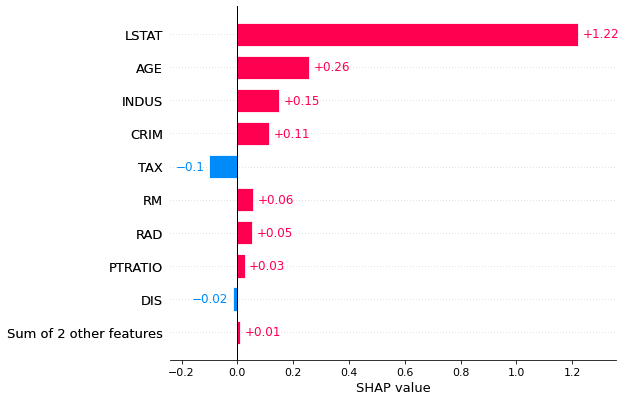

In [49]:
bar(node.shap_values[node.highlight, :, '(1, 2)'][0])

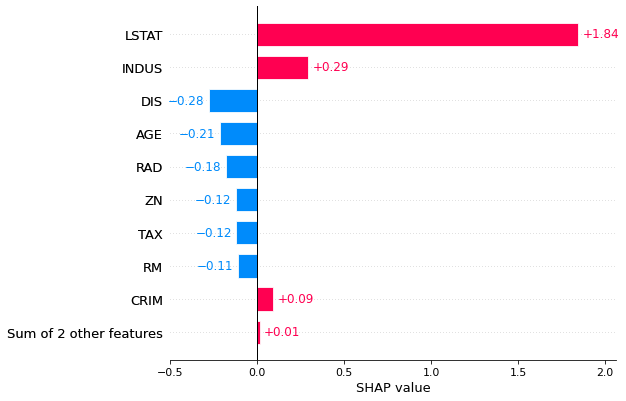

In [50]:
bar(node.shap_values[node.highlight, :, '(2, 2)'][0])

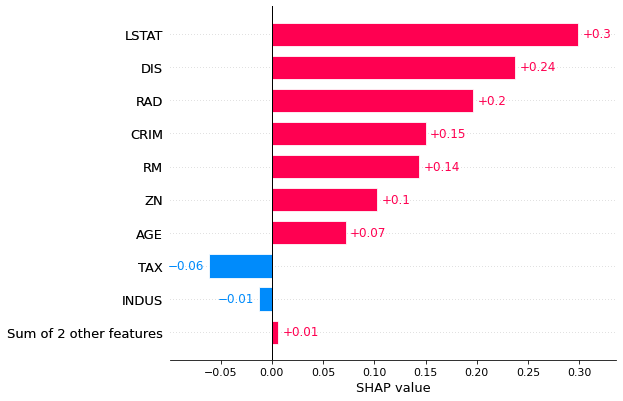

In [51]:
bar(node.shap_values[node.highlight, :, '(1, 1)'][0])

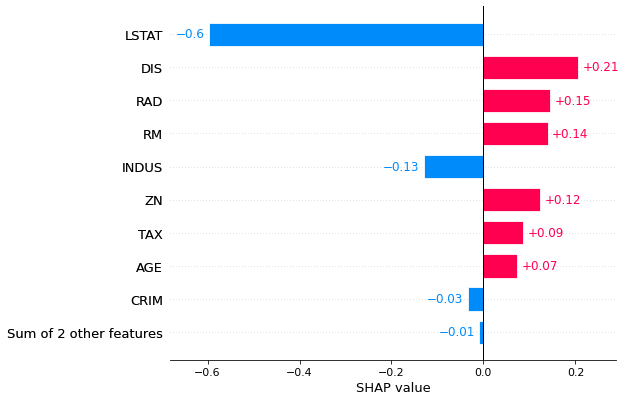

In [48]:
bar(node.shap_values[node.highlight, :, '(0, 1)'][0])

### Main Node (LRRRRRLL)

In [165]:
node = node.root.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LRRRRRLL,
 (1, 2)    1
 dtype: int64,
 0)

In [166]:
feature_it = iter(node.features_with_counterfactuals)

LSTAT is in a local high for the difference class at the value of the instance classified differently. The very close upper cf undermines this, with the comparison instance close behind.

LSTAT == 6.15
[Lower CF: LSTAT == 4.51 --> {'(2, 2)': 1},
 Upper CF: LSTAT == 6.28 --> {'(1, 1)': 1}]


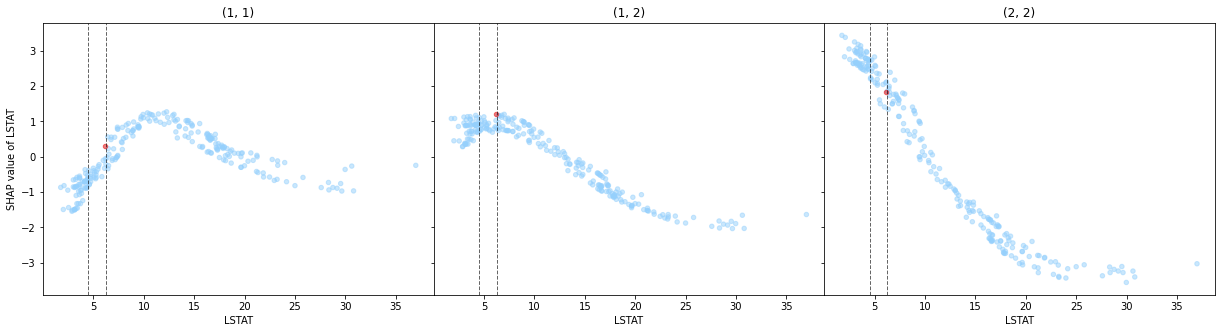

In [167]:
feature = next(feature_it)
plot(feature)

Judging by the global plot only the effect on the difference class is not clear. However, looking at the 4th parent cluster, the dependence curve is steepest for the instance classified differently and similar instances.

AGE == 0.0
[Upper CF: AGE == 1.0 --> {'(1, 1)': 1}]


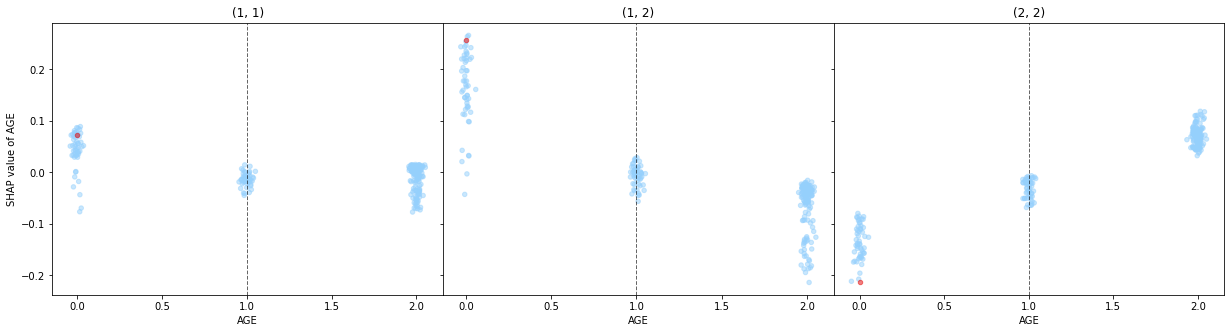

In [168]:
feature = next(feature_it)
plot(feature)

In [45]:
part = node.root.filter((4.51 < node.root.data['LSTAT']) & (node.root.data['LSTAT'] <= 6.27))

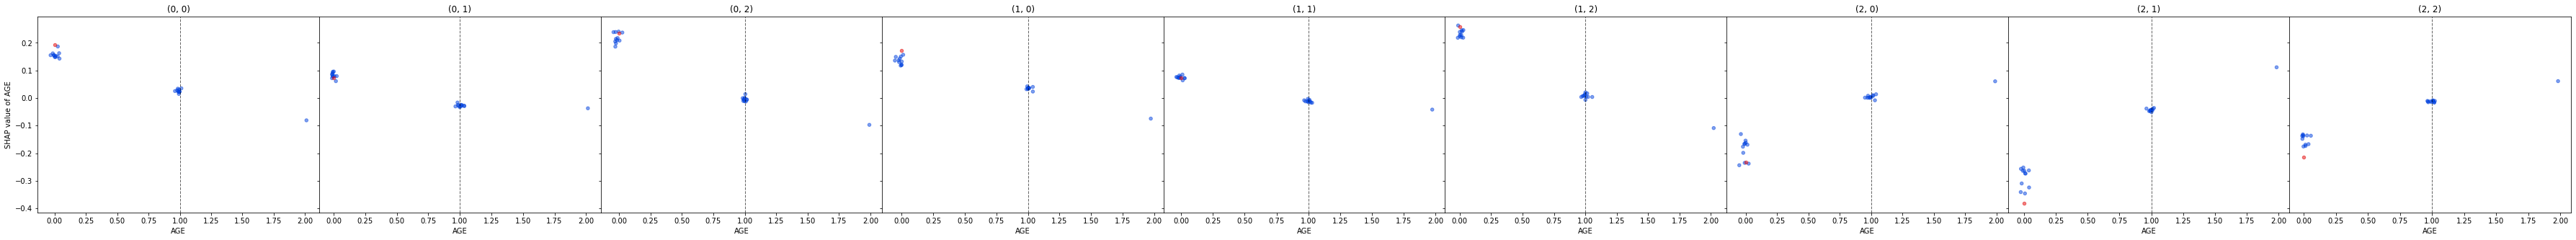

In [52]:
part.plot_feature_dependence('AGE', alpha=0.5, classes=comparer.class_names)

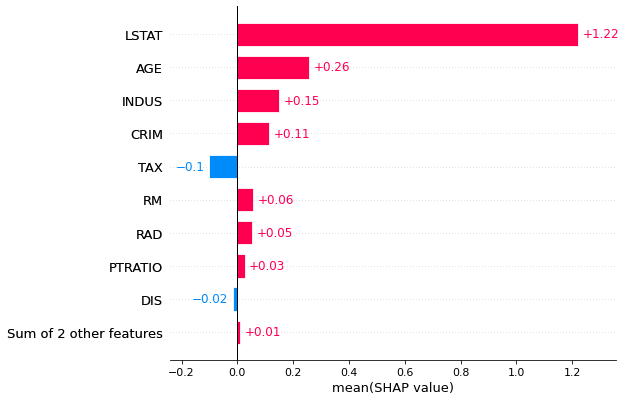

In [43]:
bar(part.shap_values[:, :, '(1, 2)'].mean(0))

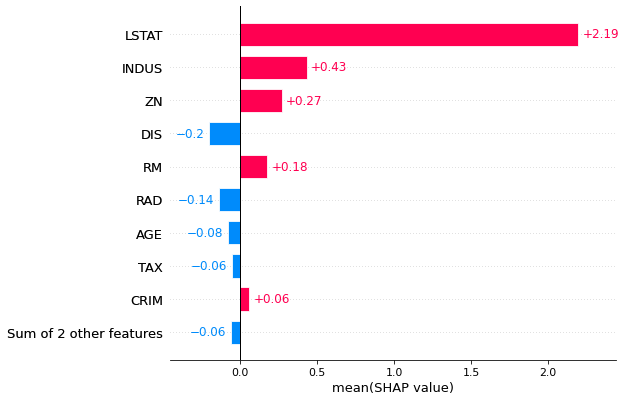

In [55]:
bar(part.shap_values[:, :, '(2, 2)'].mean(0))

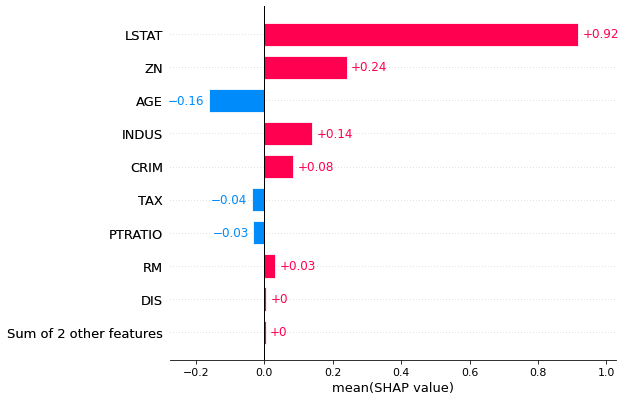

In [57]:
bar(part.shap_values[:, :, '(2, 1)'].mean(0))

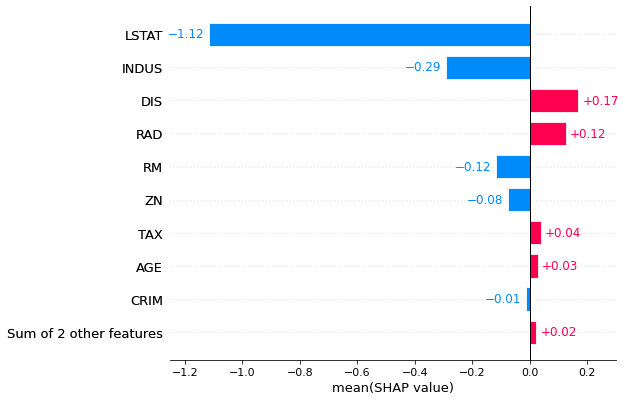

In [54]:
bar(part.shap_values[:, :, '(0, 1)'].mean(0))

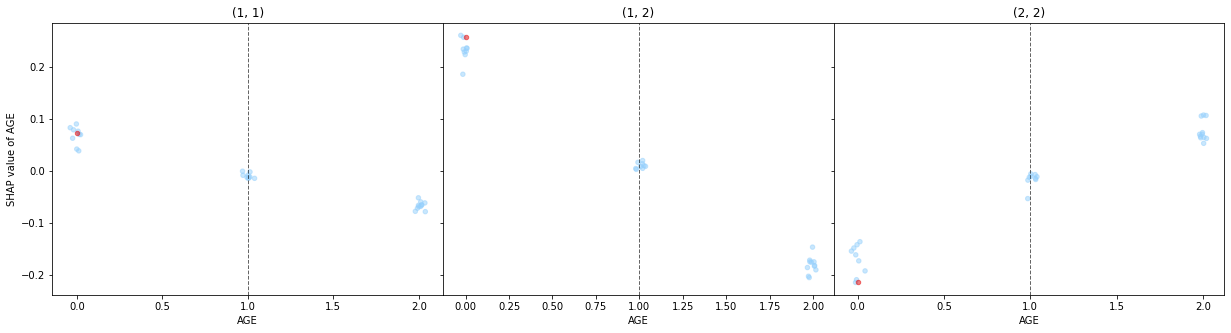

In [169]:
node.get_parent(4).plot_feature_dependence(feature, focus=node, alpha=0.5)

Again, in the global plot there are big interaction effects present, but locally the dependence curve behaves linearly.

DIS == 5.4159
[Lower CF: DIS == 1.9 --> {'(2, 2)': 1},
 Upper CF: DIS == 5.66 --> {'(1, 1)': 1}]


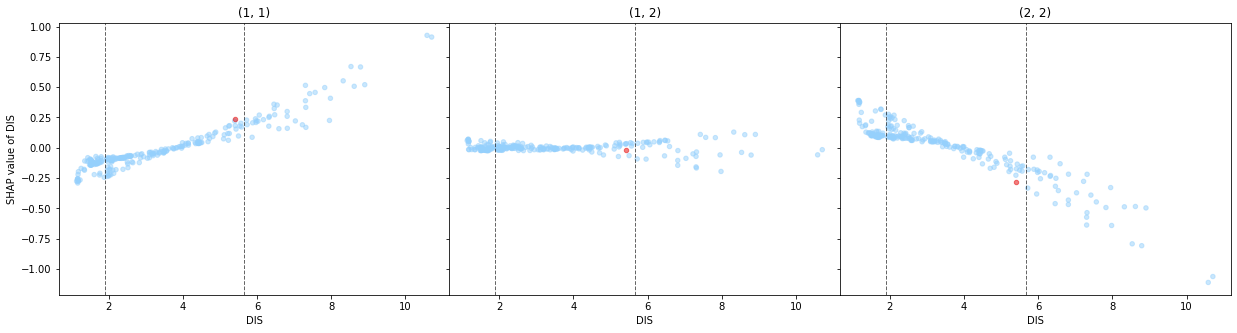

In [170]:
feature = next(feature_it)
plot(feature)

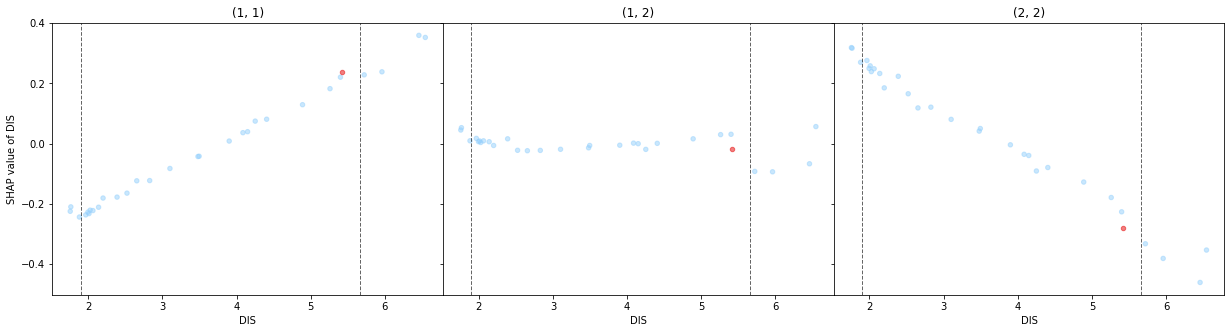

In [171]:
node.get_parent(4).plot_feature_dependence(feature, focus=node, alpha=0.5)

For INDUS there's a similar local linear effect.

INDUS == 7.38
[Upper CF: INDUS == 8.15 --> {'(1, 1)': 1}]


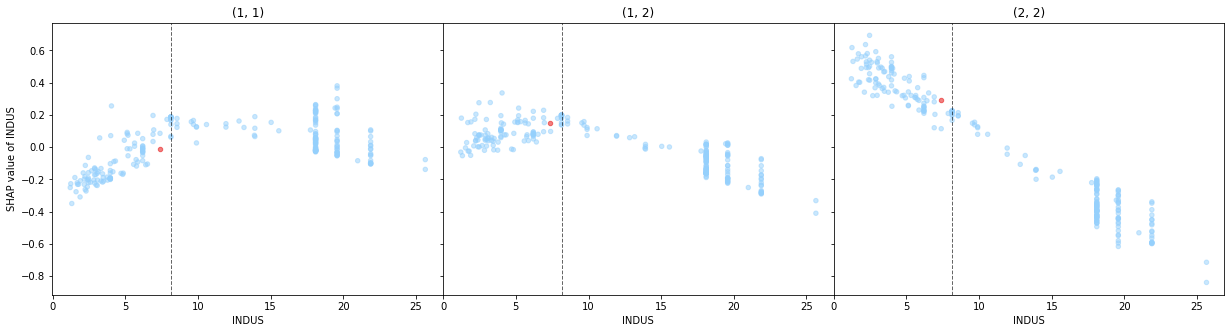

In [172]:
feature = next(feature_it)
plot(feature)

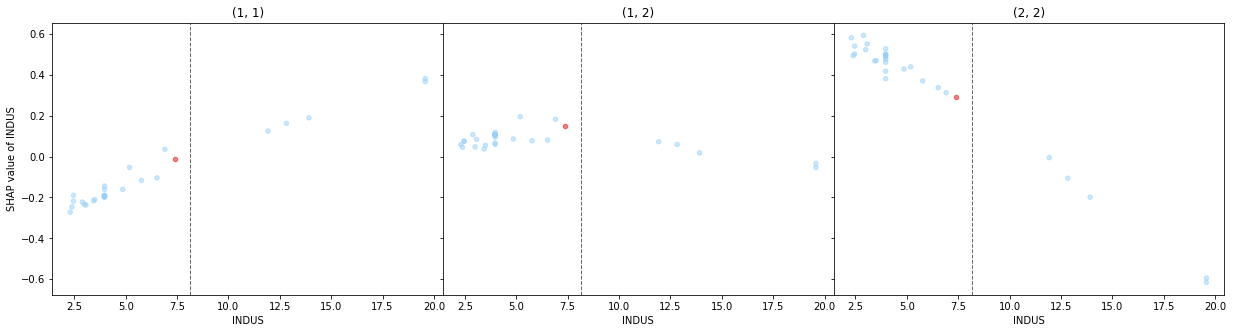

In [173]:
node.get_parent(4).plot_feature_dependence(feature, focus=node, alpha=0.5)

This counterfactual includes the majority of instances anyway, I'll not add it to the rule set.

CRIM == 0.30347
[Upper CF: CRIM == 15.0 --> {'(0, 0)': 1}]


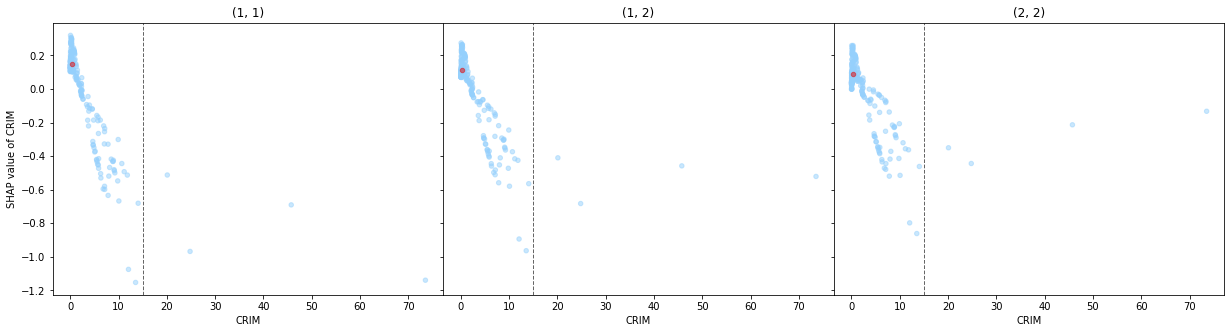

In [174]:
feature = next(feature_it)
plot(feature)

High values strongly tend to increase the outcome of $(2,2)$, while low values strongly tend to increase the outcome of $(1,1)$. The mids are thus more likely for differences.

RAD == 5.0
[Lower CF: RAD == 4.27 --> {'(1, 1)': 1},
 Upper CF: RAD == 12.73 --> {'(2, 2)': 1}]


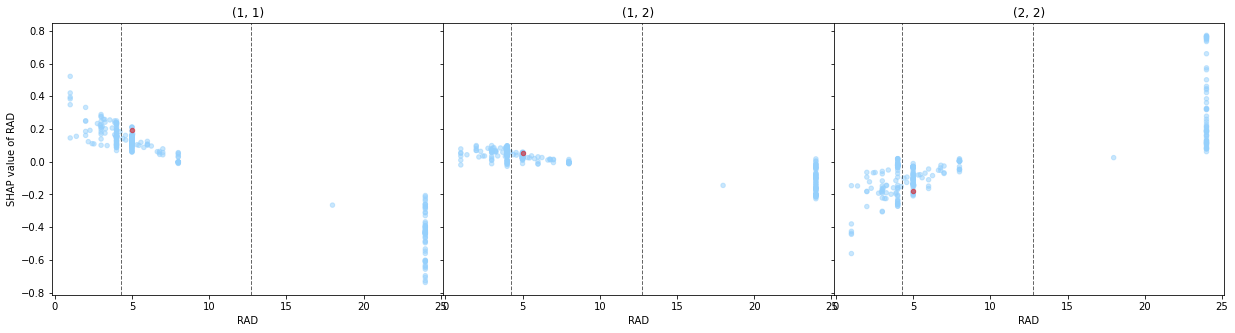

In [175]:
feature = next(feature_it)
plot(feature)

Very similar here.

RM == 6.312
[Lower CF: RM == 6.2 --> {'(1, 1)': 1}, Upper CF: RM == 7.75 --> {'(2, 2)': 1}]


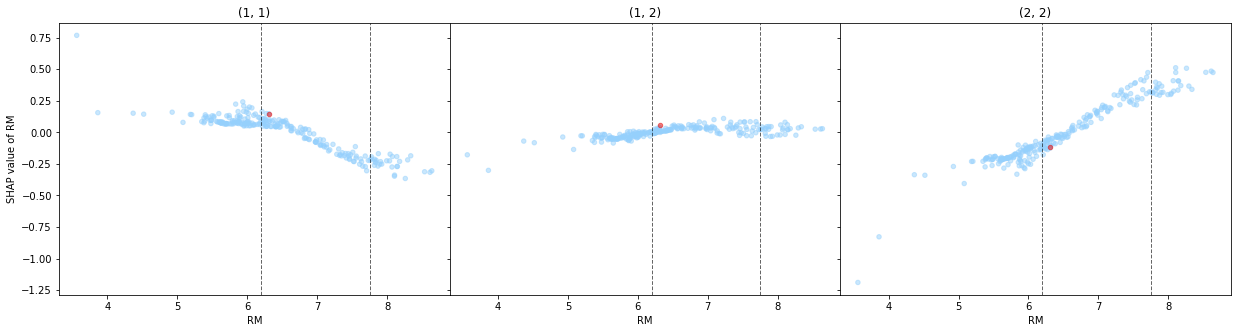

In [176]:
feature = next(feature_it)
plot(feature)

The counterfactual is on the far edge of the value range, I'll not add it.

ZN == 0.0
[Upper CF: ZN == 90.0 --> {'(2, 2)': 1}]


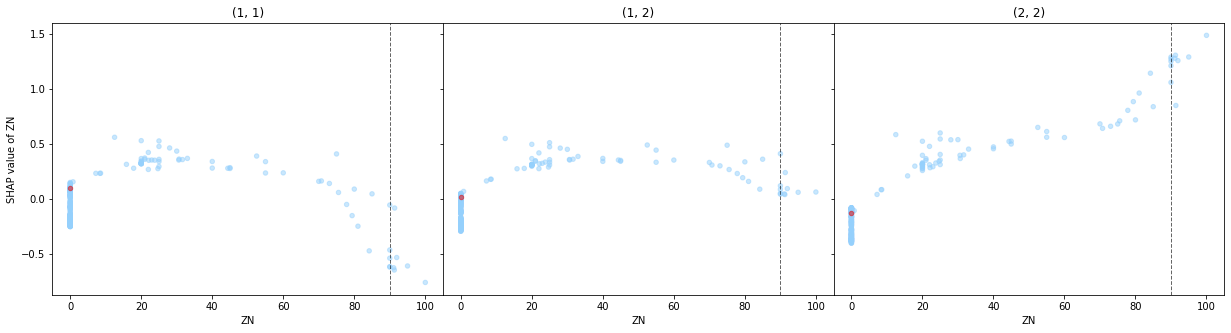

In [177]:
feature = next(feature_it)
plot(feature)

Globally there is a high spread, which means many feature interactions. Locally I see that every class outcome has a linear relation, but with different degrees of steepness. The difference class outcome is in the middle, with the lower cf pointing out a boundary.

PTRATIO == 19.6
[Lower CF: PTRATIO == 17.34 --> {'(1, 1)': 1}]


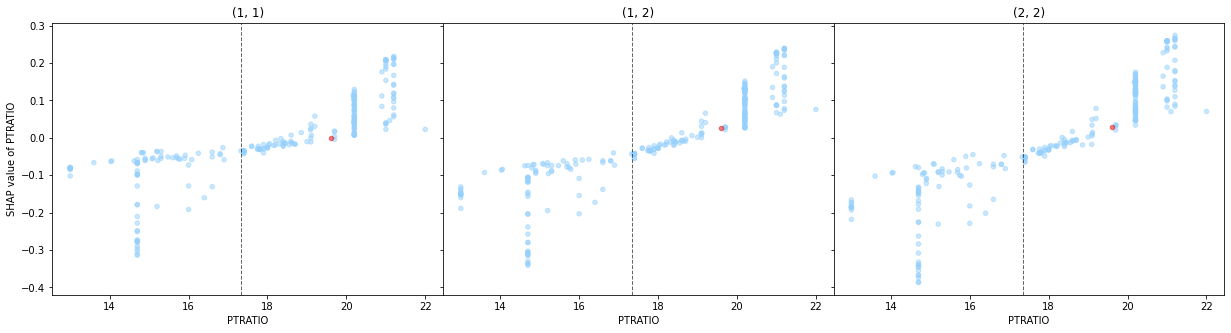

In [178]:
feature = next(feature_it)
plot(feature)

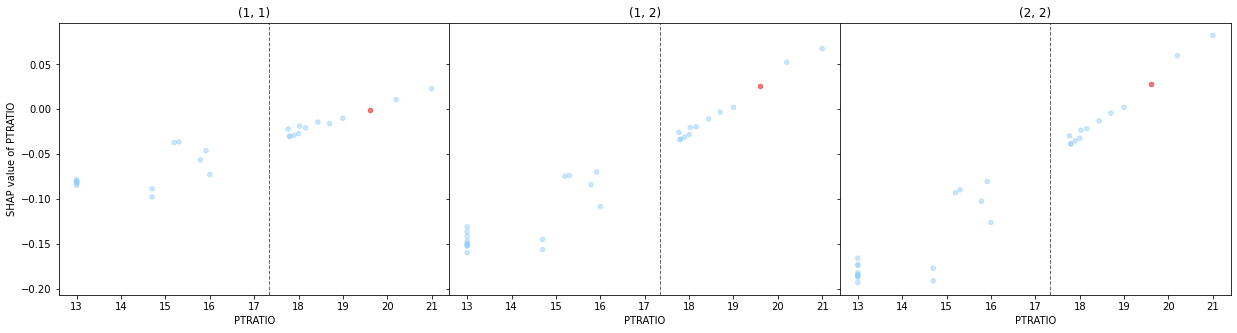

In [179]:
node.get_parent(4).plot_feature_dependence(feature, focus=node, alpha=0.5)

In [180]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'AGE', 'DIS', 'INDUS', 'RAD', 'RM', 'PTRATIO')
print(rule)
node.evaluate_rules(rule)

4.51 < LSTAT <= 6.27 and AGE <= 0.0 and 1.9 < DIS <= 5.65 and INDUS <= 8.14 and 4.27 < RAD <= 12.72 and 6.2 < RM <= 7.74 and PTRATIO > 17.34
              precision    recall  f1-score   support

        True       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



Precision  Recall  F1 Score  Support
False        0.0     0.0       0.0        0
True         1.0     1.0       1.0        1

In [181]:
explanations_global = [(rule, constraint, instance_indices)]

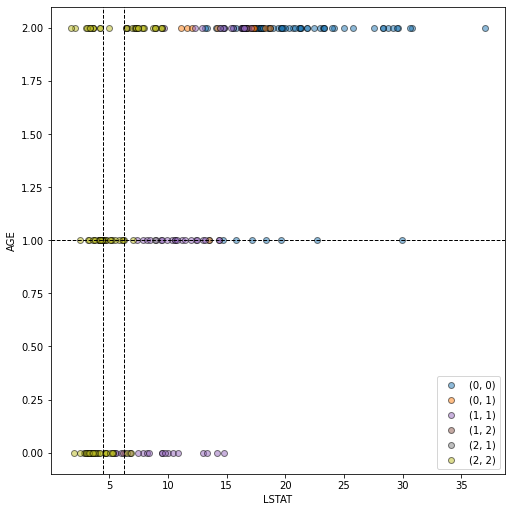

In [182]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Evaluation

In [183]:
level = 0
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [185]:
print_rules(rules)
global_fidelities[(level, node.diff_class)] = node.root.evaluate_rules(*rules)

1. 4.51 < LSTAT <= 6.27 and AGE <= 0.0 and 1.9 < DIS <= 5.65 and INDUS <= 8.14 and 4.27 < RAD <= 12.72 and 6.2 < RM <= 7.74 and PTRATIO > 17.34
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       245
        True       1.00      1.00      1.00         1

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246



In [186]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
local_fidelities[(level, node.diff_class)] = statistics
statistics

invalid value encountered in true_divide
invalid value encountered in true_divide


RMSE  BMR  BAR
CRIM      NaN  1.0  NaN
ZN        NaN  1.0  NaN
INDUS     0.0  0.0  0.0
NOX       NaN  NaN  NaN
RM        0.0  0.0  0.0
AGE       0.0  0.0  0.0
DIS       0.0  0.0  0.0
RAD       0.0  0.0  0.0
TAX       NaN  NaN  NaN
PTRATIO   0.0  0.0  0.0
LSTAT     0.0  0.0  0.0

In [187]:
res = get_complexity(constraints)
complexities[(level, node.diff_class)] = res
res

Rules           1
Constraints    11
dtype: int64

## Clustering of Class $(2,1)$ SHAP Values

In [63]:
focus_class = '(2, 1)'

In [64]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       focus_class, ['(1, 1)', '(2, 1)', '(2, 2)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
with open(f'clustering.{focus_class}.pickle', 'wb') as f:
    pickle.dump(node, f)
node.class_counts, node.distance

CPU times: user 4.89 s, sys: 51.8 ms, total: 4.94 s
Wall time: 5.38 s


((2, 2)    95
 (0, 0)    76
 (1, 1)    58
 (0, 1)    13
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 59.58275464415261)

In [65]:
with open(f'clustering.{focus_class}.pickle', 'rb') as f:
    node = pickle.load(f)
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

### Main Node (LR)

In [66]:
node = node.root.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(LR,
 (1, 1)    28
 (2, 2)    11
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 12.212893429781056)

In [192]:
feature_it = iter(node.features_with_counterfactuals)

The difference class curve is in a global higher for the instances of this cluster. 

6.48 <= LSTAT <= 8.93
[Lower CF: LSTAT == 5.97 --> {'(2, 2)': 3},
 Upper CF: LSTAT == 9.06 --> {'(1, 1)': 3}]


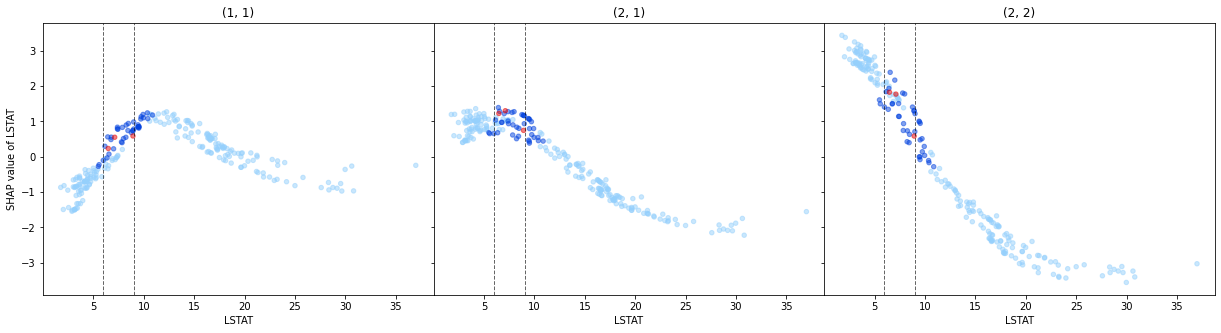

In [193]:
feature = next(feature_it)
plot(feature)

The local INDUS dependence curves look already nearly linear, with low values tending towards $(2,2)$ and to a lesser extent towards $(2,1)$ and high values towards $(2,2)$.

2.18 <= INDUS <= 18.1
[Upper CF: INDUS == 19.62 --> {'(1, 1)': 3}]


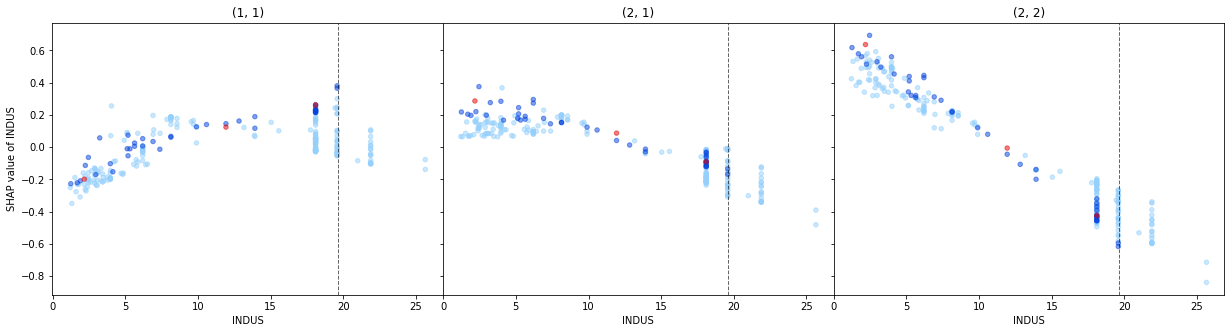

In [194]:
feature = next(feature_it)
plot(feature)

similar. I suspect, that LSTAT is interacting with this feature, and I can visualize this by coloring each instance by its LSTAT value.

1.6132 <= DIS <= 3.37
[Upper CF: DIS == 4.18 --> {'(1, 1)': 3}]


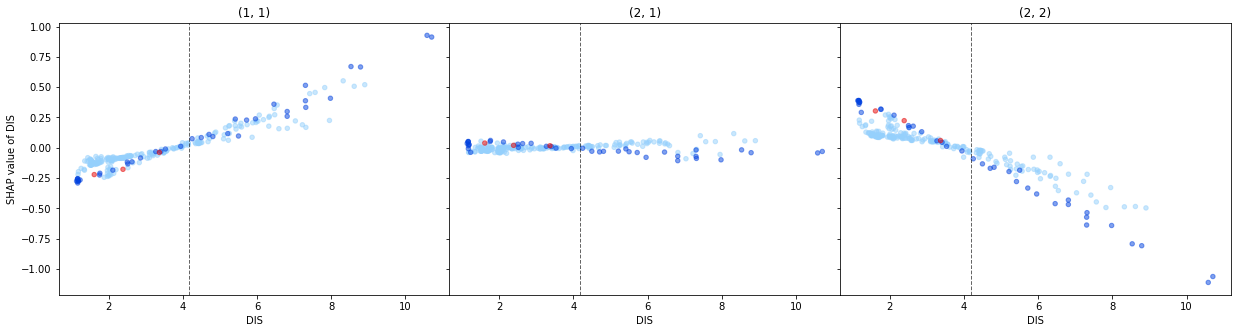

In [195]:
feature = next(feature_it)
plot(feature)

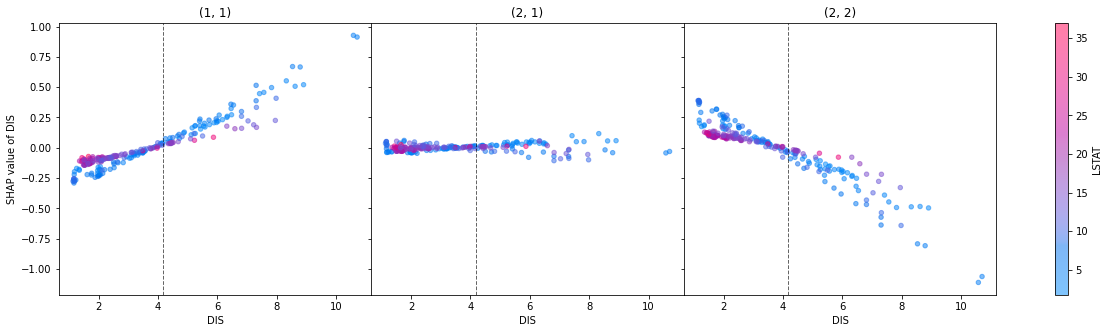

In [196]:
node.root.plot_feature_dependence(feature, alpha=0.5, color='LSTAT')

Only the very high values clearly tend to increase $(2,2)$ with the rest being indifferent. Not including it in rule.

ZN <= 33.0
[Upper CF: ZN == 82.0 --> {'(2, 2)': 3}]


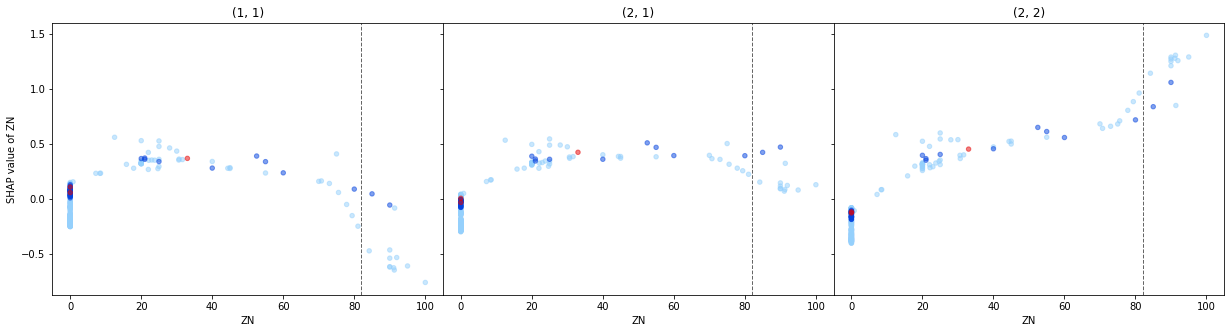

In [197]:
feature = next(feature_it)
plot(feature)

This feature too has low explanatory power, not including it.

0.05479 <= CRIM <= 4.55587
[Upper CF: CRIM == 13.0 --> {'(2, 2)': 2, '(0, 1)': 1}]


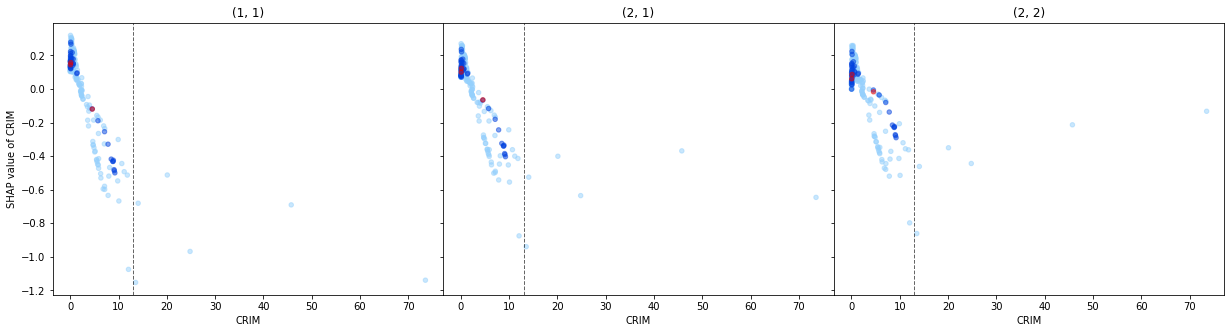

In [198]:
feature = next(feature_it)
plot(feature)

High values tend to increase the outcome of $(2,1)$ and to a lesser extent of $(2,2)$.

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(1, 2)': 3}]


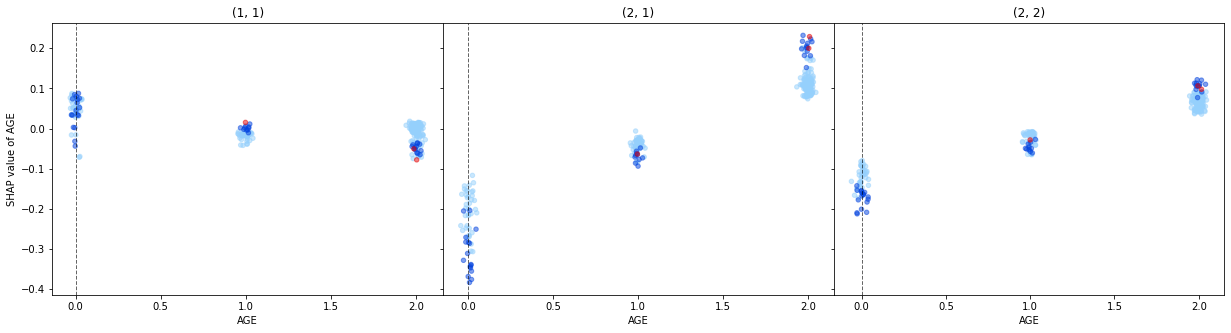

In [199]:
feature = next(feature_it)
plot(feature)

In [68]:
part = node.root.filter((5.97 < node.root.data['LSTAT']) & (node.root.data['LSTAT'] <= 9.05))

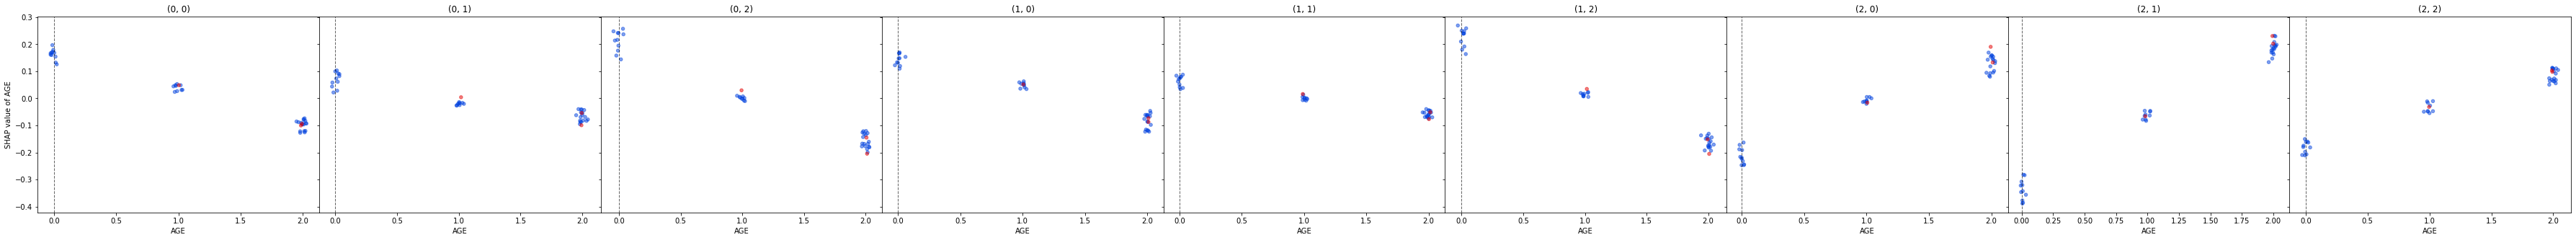

In [69]:
part.plot_feature_dependence('AGE', alpha=0.5, classes=comparer.class_names)

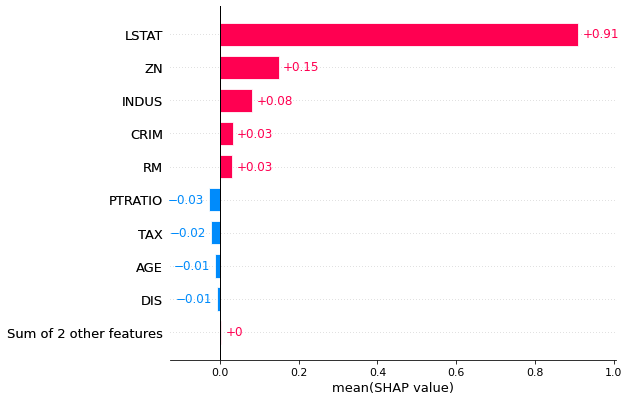

In [70]:
bar(part.shap_values[:, :, '(1, 2)'].mean(0))

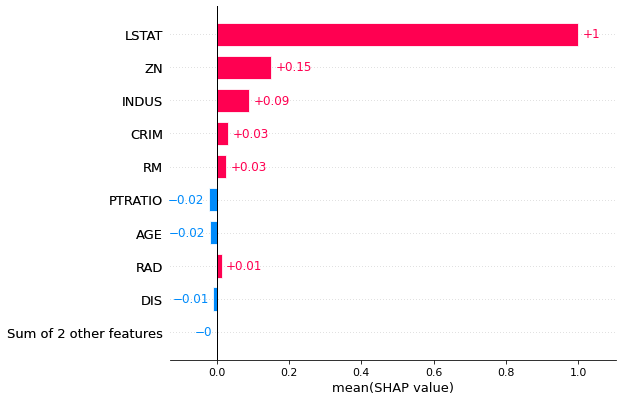

In [71]:
bar(part.shap_values[:, :, '(2, 1)'].mean(0))

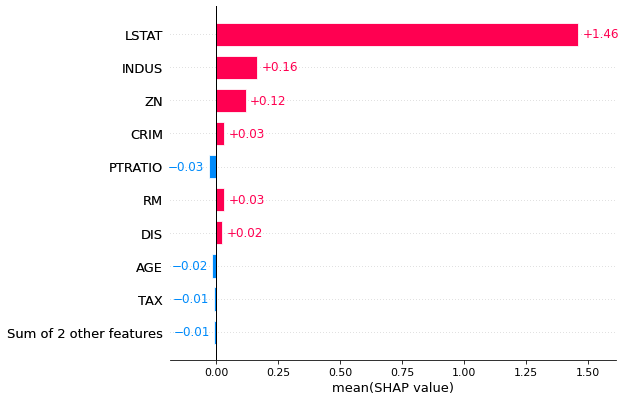

In [72]:
bar(part.shap_values[:, :, '(2, 2)'].mean(0))

Here we clearly see an outlier. But the local linear dependency is still present. I can zoom in on the sub-cluster, where this instance is separated from the other two. There, the upper cf is much lower.

RM <= 6.794
[Upper CF: RM == 7.22 --> {'(2, 2)': 3}]


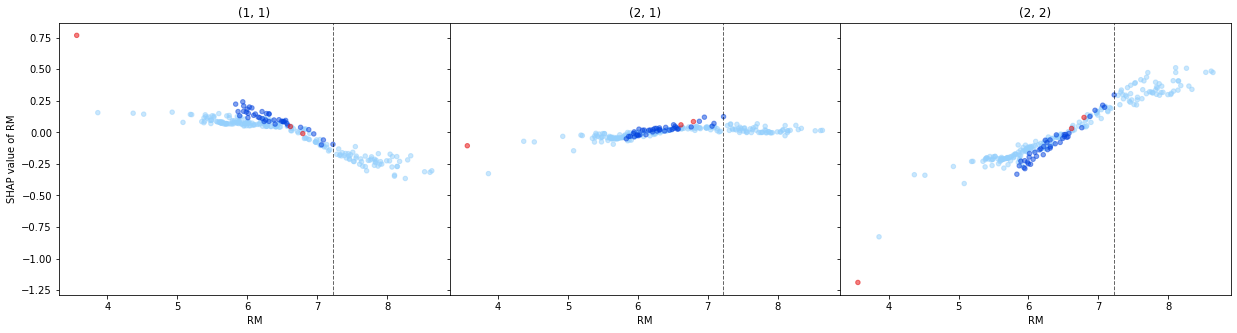

In [200]:
feature = next(feature_it)
plot(feature)

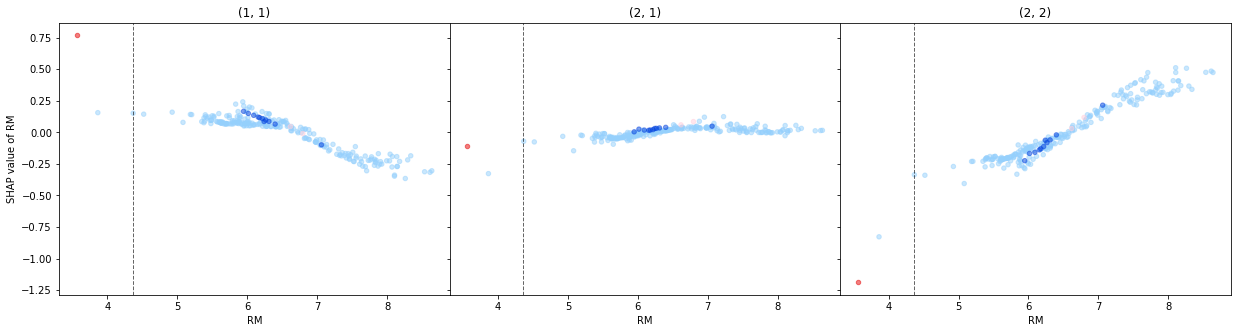

In [201]:
node.root.plot_feature_dependence('RM', focus=node.get('LL'), alpha=0.5)

In [202]:
rule, constraint, instance_indices = node.rule_from_counterfactuals('LSTAT', 'INDUS', 'DIS', 'AGE', 'RM')
print(rule)
node.evaluate_rules(rule)

5.97 < LSTAT <= 9.05 and INDUS <= 19.61 and DIS <= 4.17 and AGE > 0.0 and RM <= 7.21
              precision    recall  f1-score   support

       False       1.00      0.70      0.82        40
        True       0.20      1.00      0.33         3

    accuracy                           0.72        43
   macro avg       0.60      0.85      0.58        43
weighted avg       0.94      0.72      0.79        43



Precision  Recall  F1 Score  Support
False        1.0     0.7  0.823529       40
True         0.2     1.0  0.333333        3

In [203]:
explanations_global = [(rule, constraint, instance_indices)]

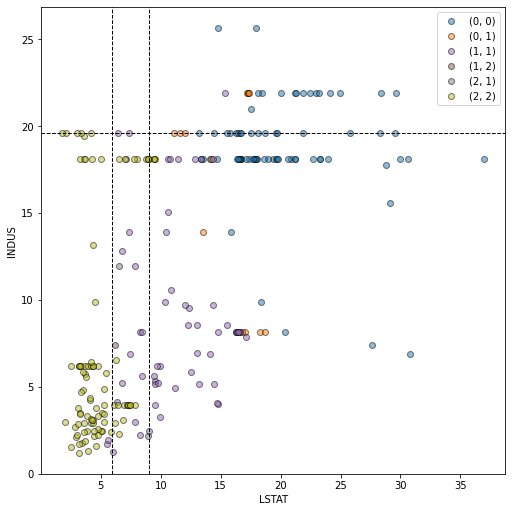

In [204]:
plot_2d(node, *node.features_with_counterfactuals[:2])

### Evaluation

In [205]:
level = 0
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

In [206]:
print_rules(rules)
global_fidelities[(level, node.diff_class)] = node.root.evaluate_rules(*rules)

1. 5.97 < LSTAT <= 9.05 and INDUS <= 19.61 and DIS <= 4.17 and AGE > 0.0 and RM <= 7.21
              precision    recall  f1-score   support

       False       1.00      0.95      0.97       243
        True       0.19      1.00      0.32         3

    accuracy                           0.95       246
   macro avg       0.59      0.97      0.64       246
weighted avg       0.99      0.95      0.96       246



In [207]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)
local_fidelities[(level, node.diff_class)] = statistics
statistics

invalid value encountered in true_divide
invalid value encountered in true_divide


RMSE  BMR  BAR
CRIM          NaN  1.0  NaN
ZN            NaN  1.0  NaN
INDUS    9.862177  0.4  0.0
NOX           NaN  NaN  NaN
RM       1.659116  0.4  0.0
AGE      0.816497  0.0  0.0
DIS      1.155537  0.4  0.0
RAD           NaN  1.0  NaN
TAX           NaN  1.0  NaN
PTRATIO       NaN  1.0  NaN
LSTAT    1.438616  0.0  0.0

In [208]:
res = get_complexity(constraints)
complexities[(level, node.diff_class)] = res
res

Rules          1
Constraints    6
dtype: int64

# Summary

In [209]:
def map_index(index):
    class_, level_in = index[0], index[1]
    if class_ == '(0, 1)' and level_in == 0:
        level = 'global'
    elif class_ == '(0, 1)' and level_in == 3:
        level = 'local'
    elif class_ == '(1, 2)' and level_in == 0:
        level = 'global'
    elif class_ == '(2, 1)' and level_in == 0:
        level = 'global'
    else:
        level = None
    return (class_, level) if len(index) == 2 else (class_, level, index[2])

## Global Fidelity

In [210]:
global_fidelity = pd.concat(global_fidelities.values(), keys=global_fidelities.keys(), names=('level', 'class'))
global_fidelity = global_fidelity[global_fidelity.index.get_level_values(2).astype(int) == 1]
global_fidelity.index = global_fidelity.index.droplevel(2)
global_fidelity = global_fidelity.reorder_levels(['class', 'level']).sort_index()
global_fidelity

Precision  Recall  F1 Score  Support
class  level                                      
(0, 1) 1       0.203125     1.0  0.337662       13
       2       0.288889     1.0  0.448276       13
       3       0.565217     1.0  0.722222       13
(1, 2) 0       1.000000     1.0  1.000000        1
(2, 1) 0       0.187500     1.0  0.315789        3

## Local Fidelity

In [211]:
local_fidelity = pd.concat(local_fidelities.values(), keys=local_fidelities.keys(), names=('level', 'class', 'feature'))
local_fidelity = local_fidelity.reorder_levels(['class', 'level', 'feature']).sort_index()
pd.set_option('display.max_rows', None)
local_fidelity

RMSE       BMR  BAR
class  level feature                          
(0, 1) 0     AGE       0.919866  0.000000  0.0
             CRIM      4.169486  0.315789  0.0
             DIS            NaN  1.000000  NaN
             INDUS          NaN  1.000000  NaN
             LSTAT     4.104498  0.000000  0.0
             NOX            NaN       NaN  NaN
             PTRATIO        NaN  1.000000  NaN
             RAD            NaN  1.000000  NaN
             RM             NaN  1.000000  NaN
             TAX            NaN  1.000000  NaN
             ZN        3.088440  0.000000  0.0
       1     AGE       0.620174  0.000000  0.0
             CRIM      2.417882  0.315789  0.0
             DIS            NaN  1.000000  NaN
             INDUS     6.323947  0.650000  0.0
             LSTAT     3.197597  0.000000  0.0
             NOX            NaN       NaN  NaN
             PTRATIO   0.739031  0.666667  0.0
             RAD       4.120686  0.625000  0.0
             RM             NaN  1.000000  NaN
             TAX      98.064180  0.478261  0.0
             ZN        2.433737  0.000000  0.0
       2     AGE       0.554700  0.000000  0.0
             CRIM      1.195229  0.263158  0.0
             DIS            NaN  1.000000  NaN
             INDUS     3.909539  0.350000  0.0
             LSTAT     3.000542  0.000000  0.0
             NOX            NaN       NaN  NaN
             PTRATIO   0.516261  0.555556  0.0
             RAD       5.683723  0.187500  0.0
             RM             NaN  1.000000  NaN
             TAX      95.014680  0.173913  0.0
             ZN        2.166174  0.000000  0.0
       3     AGE       0.554700  0.000000  0.0
             CRIM      0.840168  0.105263  0.0
             DIS       0.344480  0.400000  0.0
             INDUS     2.070106  0.200000  0.0
             LSTAT     1.423773  0.000000  0.0
             NOX            NaN       NaN  NaN
             PTRATIO   0.803894  0.388889  0.0
             RAD       4.932629  0.000000  0.0
             RM        0.358934  0.785714  0.0
             TAX      39.041353  0.043478  0.0
             ZN        1.000000  0.000000  0.0
(1, 2) 0     AGE       0.000000  0.000000  0.0
             CRIM           NaN  1.000000  NaN
             DIS       0.000000  0.000000  0.0
             INDUS     0.000000  0.000000  0.0
             LSTAT     0.000000  0.000000  0.0
             NOX            NaN       NaN  NaN
             PTRATIO   0.000000  0.000000  0.0
             RAD       0.000000  0.000000  0.0
             RM        0.000000  0.000000  0.0
             TAX            NaN       NaN  NaN
             ZN             NaN  1.000000  NaN
(2, 1) 0     AGE       0.816497  0.000000  0.0
             CRIM           NaN  1.000000  NaN
             DIS       1.155537  0.400000  0.0
             INDUS     9.862177  0.400000  0.0
             LSTAT     1.438616  0.000000  0.0
             NOX            NaN       NaN  NaN
             PTRATIO        NaN  1.000000  NaN
             RAD            NaN  1.000000  NaN
             RM        1.659116  0.400000  0.0
             TAX            NaN  1.000000  NaN
             ZN             NaN  1.000000  NaN

## Complexity

In [212]:
complexity = pd.concat(complexities.values(), axis=1, keys=complexities.keys(), names=('level', 'class')).T
complexity = complexity.reorder_levels(['class', 'level']).sort_index()
complexity

Rules  Constraints
class  level                    
(0, 1) 0          1            5
       1          2           15
       2          4           39
       3          5           54
(1, 2) 0          1           11
(2, 1) 0          1            6

## Generation Time

Total: approx. 8min

In [213]:
global_fidelity.index = global_fidelity.index.map(map_index)
global_fidelity = global_fidelity[global_fidelity.index.get_level_values('level').notnull()]

local_fidelity.index = local_fidelity.index.map(map_index)
local_fidelity = local_fidelity[local_fidelity.index.get_level_values('level').notnull()]

complexity.index = complexity.index.map(map_index)
complexity = complexity[complexity.index.get_level_values('level').notnull()]

with open('results.proposed.pickle', 'wb') as f:
    pickle.dump((global_fidelity, local_fidelity, complexity), f)